In [1]:
import numpy as np
from torch import nn
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
import itertools
%matplotlib inline

In [2]:
torch.cuda.empty_cache()

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [4]:
visited_mark = 0.8  # Cells visited by the rat will be painted by gray 0.8
rat_mark = 0.5      # The current rat cell will be painteg by gray 0.5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

# Exploration factor
epsilon = 0.1

In [5]:
# maze is a 2d Numpy array of floats between 0.0 to 1.0
# 1.0 corresponds to a free cell, and 0.0 an occupied cell
# rat = (row, col) initial rat position (defaults to (0,0))

class Qmaze(object):
    def __init__(self, maze, rat=(0,0)):
        self._maze = np.array(maze)
        nrows, ncols = self._maze.shape
        self.walls = 1 - self._maze
        self.target = (nrows-1, ncols-1)   # target cell where the "cheese" is
        self.free_cells = [(r,c) for r in range(nrows) for c in range(ncols) if self._maze[r,c] == 1.0]
        self.free_cells.remove(self.target)
        if self._maze[self.target] == 0.0:
            raise Exception("Invalid maze: target cell cannot be blocked!")
        if not rat in self.free_cells:
            raise Exception("Invalid Rat Location: must sit on a free cell")
        self.reset(rat)
        self.coverage = np.zeros(self._maze.shape)

    def reset(self, rat):
        self.rat = rat
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        row, col = rat
        self.maze[row, col] = rat_mark
        self.state = (row, col, 'start')
        self.min_reward = -0.5 * self.maze.size
        self.total_reward = 0
        self.visited = set()

    def update_state(self, action):
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = rat_row, rat_col, mode = self.state

        if self.maze[rat_row, rat_col] > 0.0:
            self.visited.add((rat_row, rat_col))  # mark visited cell

        valid_actions = self.valid_actions()

        if not valid_actions:
            nmode = 'blocked'
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 1
            elif action == UP:
                nrow -= 1
            if action == RIGHT:
                ncol += 1
            elif action == DOWN:
                nrow += 1
        else:                  # invalid action, no change in rat position
            mode = 'invalid'

        # new state
        self.state = (nrow, ncol, nmode)
        self.coverage[nrow][ncol] += 1

    def get_reward(self):
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        rew = 0
        if rat_row == nrows-1 and rat_col == ncols-1:
          rew = 1.0
        if mode == 'blocked':
          rew = 0
        if (rat_row, rat_col) in self.visited:
          rew = 0.
        if mode == 'invalid':
          rew = 0.
        if mode == 'valid':
          rew = 0.

        return rew

    def act(self, action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        envstate = self.observe()
        return envstate, reward, status

    def observe(self):
        canvas = self.draw_env()
        canvas = 2 * (self._maze - canvas)
        envstate = np.stack([self._maze, self.walls, canvas], axis=0)
        return envstate

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0
        # draw the rat
        row, col, valid = self.state
        canvas[row, col] = rat_mark
        return canvas

    def game_status(self):
        if self.total_reward < self.min_reward:
            return 'lose'
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 'win'

        return 'not_over'

    def valid_actions(self, cell=None):
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        actions = [0, 1, 2, 3]
        nrows, ncols = self.maze.shape
        if row == 0:
            actions.remove(1)
        elif row == nrows-1:
            actions.remove(3)

        if col == 0:
            actions.remove(0)
        elif col == ncols-1:
            actions.remove(2)

        if row>0 and self.maze[row-1,col] == 0.0:
            actions.remove(1)
        if row<nrows-1 and self.maze[row+1,col] == 0.0:
            actions.remove(3)

        if col>0 and self.maze[row,col-1] == 0.0:
            actions.remove(0)
        if col<ncols-1 and self.maze[row,col+1] == 0.0:
            actions.remove(2)

        return actions

In [6]:
from IPython.display import clear_output
import time
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    rat_row, rat_col, _ = qmaze.state
    canvas[rat_row, rat_col] = 0.3   # rat cell
    canvas[nrows-1, ncols-1] = 0.9 # cheese cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

In [11]:
class Network(nn.Module):
    def __init__(self, input_size, kernel_size, num_filters, out_features, device=device):
        super(Network, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, num_filters, kernel_size),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(int(num_filters*(input_size[0]-kernel_size+1)*(input_size[1]-kernel_size+1)/4), 32),
            nn.PReLU(),
            nn.Linear(32, out_features)

        )
        self.to(device)

    def forward(self, x):
        return self.net(x)

    def act(self, obs):
        obs_t = torch.as_tensor(obs, dtype=torch.float32).to(device)
        q_values = self.forward(obs_t.unsqueeze(0))
        max_q_index = torch.argmax(q_values, dim=1)[0]
        action = max_q_index.detach().item()
        return action

class DQNAgent():
    def __init__(self, env, epsilon_start, epsilon_end, epsilon_decay, gamma, lr):
        input_size = env.maze.shape
        out_features = 4
        kernel_size = 3
        num_filters = 6
        self.num_actions = out_features
        self.gamma = gamma
        self.targets = None
        self.action_qvalues = None
        self.online_net = Network(input_size, kernel_size, num_filters, out_features)
        self.target_net = Network(input_size, kernel_size, num_filters, out_features)
        self.target_net.load_state_dict(self.online_net.state_dict())
        self.optimizer = torch.optim.Adam(self.online_net.parameters(), lr=lr)
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.counter = 1

    def choose_action(self, time, obs):
        epsilon = np.interp(time, [0, self.epsilon_decay], [self.epsilon_start, self.epsilon_end])
        rnd_sample = random.random()
        if rnd_sample <= epsilon:
            action = random.randrange(self.num_actions)
        else:
            action = self.online_net.act(obs)

        return action

    def calculate_target(self, new_obses_t, rews_t, dones_t, var):
        target_qvalues = self.target_net(new_obses_t)
        self.target_qvalues = target_qvalues

        max_val = target_qvalues.max().item() * var

        ### Method 1
        # means = target_qvalues.mean(axis=1).view(BATCH_SIZE, 1)
        # bias_vals = means - target_qvalues
        # for i in range(4):
        #   noise = torch.tensor(np.random.multivariate_normal(bias_vals[:, i].detach().cpu().numpy(), max_val * np.identity(BATCH_SIZE))).to(device)
        #   target_qvalues[:, i] += noise
        # max_target_qvalues = target_qvalues.max(dim=1, keepdim=True)[0]

        ### Method 2
        # noise = torch.from_numpy(np.random.normal(0, 10 * var, target_qvalues.size())).to(device)
        # noisy_target_qvalues = target_qvalues + noise
        # max_target_qvalues = noisy_target_qvalues.max(dim=1, keepdim=True)[0]

        ### Method 3
        max_target_qvalues = target_qvalues.max(dim=1, keepdim=True)[0]
        noise = torch.from_numpy(np.random.normal(0, 10 * var, max_target_qvalues.size())).to(device)
        max_target_qvalues += noise

        if self.counter % 1000 == 0:
          print(self.online_net(new_obses_t)[0,:])
          for g in self.optimizer.param_groups:
            g['lr'] *= 0.85
            print(g['lr'])

        self.targets = rews_t + self.gamma * (1 - dones_t) * max_target_qvalues

    def calculate_action_qvalues(self, obses_t, actions_t):
        q_values = self.online_net(obses_t)
        self.action_qvalues = torch.gather(input=q_values, dim=1, index=actions_t)

    def optimize_network(self):
        loss = nn.functional.smooth_l1_loss(self.action_qvalues, self.targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_net.load_state_dict(self.online_net.state_dict())

In [12]:
GAMMA = 0.9
BATCH_SIZE = 32
BUFFER_SIZE = 100000
MIN_REPLAY_SIZE = 1000
EPSILON_START = 0.0001
EPSILON_END = 0.0001
EPSILON_DECAY = 5000
TARGET_UPDATE_FREQ = 200

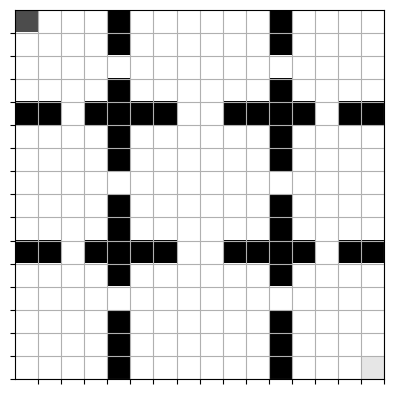

In [13]:
maze = [
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  1., 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  1., 1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1., 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
]
env = Qmaze(maze)
show(env)

trained 1-500 0 times - ep num = 0
tensor([5981.9810, 5152.1675, 4861.0981, 6005.4087], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.425
tensor([4356.0806, 4481.0659, 4472.9048, 4431.7773], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.36124999999999996
tensor([2687.6641, 2744.6846, 2774.5759, 2701.6804], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.30706249999999996
tensor([1767.5552, 1716.1058, 1757.4706, 1793.6742], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.26100312499999995
tensor([1091.9237, 1071.6979, 1088.6653, 1082.1320], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.22185265624999995


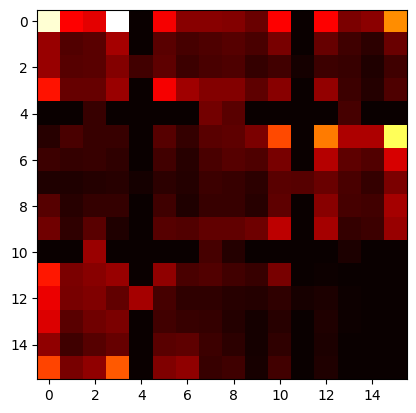

trained 1-500 0 times - ep num = 0
tensor([ 791.4575, -734.6968, -525.3020, 1569.4523], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.18857475781249994
tensor([322.6531, 507.2473, 538.4067, 171.5829], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.16028854414062493
tensor([1326.6969, 1290.9625, 1271.0515, 1282.6477], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.1362452625195312
tensor([767.1661, 769.2305, 760.0834, 765.5725], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.11580847314160152
tensor([489.4336, 443.7723, 396.8631, 443.5553], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.09843720217036128


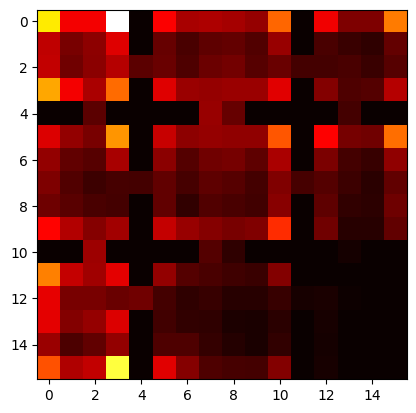

trained 1-500 0 times - ep num = 0
tensor([317.4514, 314.6920, 309.6416, 311.1294], device='cuda:0',
       grad_fn=<SliceBackward0>)
0.08367162184480709


KeyboardInterrupt: ignored

In [14]:
for sigma in [0.1, 0.5, 1]:
  for rate in [500, 1000, 5000]:
    avg_returns = []
    episodes = []
    current_coverage = []
    coverage_steps = [5000, 10000, 15000, 50000]
    prefix = f"{sigma}_{rate}_"

    # Noise defined
    for k in range(3):
        torch.cuda.empty_cache()
        current_return = []

        replay_buffer = deque(maxlen=BUFFER_SIZE)
        rew_buffer = []
        temp_episodes = []

        rat_cell = (0, 0)
        env = Qmaze(maze)
        env.reset(rat_cell)
        obs = env.observe()

        agent = DQNAgent(env, EPSILON_START, EPSILON_END, EPSILON_DECAY, GAMMA, 0.5)
        cnt = 0
        coverage_counter = 0
        episode = 0
        for step in itertools.count():
            agent.counter += 1
            action = agent.choose_action(step, obs)

            new_obs, rew, done = env.act(action)
            Transition = (obs, action, rew, done, new_obs)
            replay_buffer.append(Transition)
            obs = new_obs

            if done != 'not_over':
                rat_cell = (0,0)
                env.reset(rat_cell)
                obs = env.observe()
                rew_buffer.append(GAMMA**(cnt))
                episode += 1
                cnt = 0

            if len(replay_buffer) > BATCH_SIZE:
                transitions = random.sample(replay_buffer, BATCH_SIZE)
                obses = np.asarray([t[0] for t in transitions])
                actions = np.asarray([t[1] for t in transitions])
                rews = np.asarray([t[2] for t in transitions])
                dones = np.asarray([t[3] for t in transitions])
                new_obses = np.asarray([t[4] for t in transitions])

                converted_dones = [done != 'not_over' for done in dones]

                obses_t = torch.as_tensor(obses, dtype=torch.float32).to(device)
                actions_t = torch.as_tensor(actions, dtype=torch.int64).unsqueeze(-1).to(device)
                rews_t = torch.as_tensor(rews, dtype=torch.float32).unsqueeze(-1).to(device)
                dones_t = torch.as_tensor(converted_dones, dtype=torch.float32).unsqueeze(-1).to(device)
                new_obses_t = torch.as_tensor(new_obses, dtype=torch.float32).to(device)

                # Calculate noise
                var = sigma / np.ceil (agent.counter / rate)

                agent.calculate_target(new_obses_t, rews_t, dones_t, var)
                agent.calculate_action_qvalues(obses_t, actions_t)
                agent.optimize_network()

            if step % TARGET_UPDATE_FREQ == 0:
                agent.update_target_network()

            if step in coverage_steps:
                if k == 0:
                    current_coverage.append(np.copy(env.coverage.reshape(1, env.coverage.shape[0], env.coverage.shape[1])))
                else:
                    current_coverage[coverage_counter] = np.concatenate(
                        [current_coverage[coverage_counter], env.coverage.reshape(1, env.coverage.shape[0], env.coverage.shape[1])], axis=0)

                coverage_counter += 1

                plt.imshow(env.coverage, cmap='hot', interpolation='nearest')
                plt.show()

            if step > 55000:
                episodes.append(np.copy(temp_episodes))
                avg_returns.append(np.copy(rew_buffer))
                break
            cnt += 1

            if step % 5000 == 0:
                temp_episodes.append(episode)
                print(f"trained {sigma}-{rate} {k} times - ep num = {episode}")

    min_length = np.min([len(array) for array in avg_returns])
    np.save(prefix+"episodes.npy", np.mean(episodes, axis=0))
    np.save(prefix+"score.npy", np.mean([array[:min_length] for array in avg_returns], axis=0))
    for s in range(len(coverage_steps)):
        np.save(prefix+f"heat_{coverage_steps[s]}.npy", np.mean(current_coverage[s], axis=0))

In [34]:
plt.imshow(np.mean(current_coverage[1], axis=0)[0:][:], cmap='hot', interpolation='nearest')

IndexError: ignored

<ipython-input-174-4ba5ae3ef7bf>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


KeyboardInterrupt: ignored

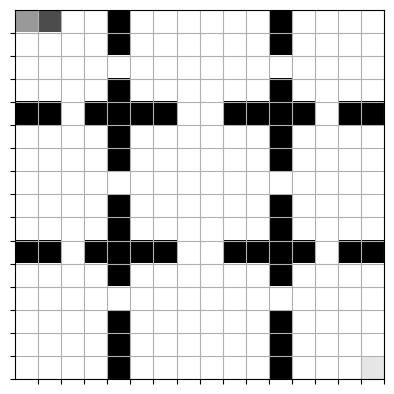

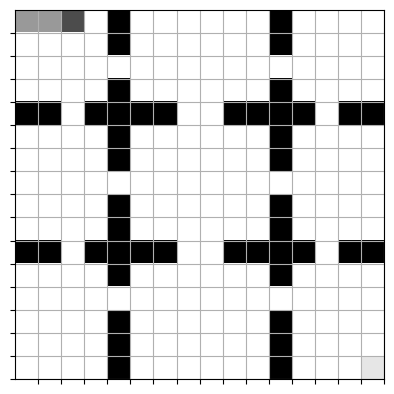

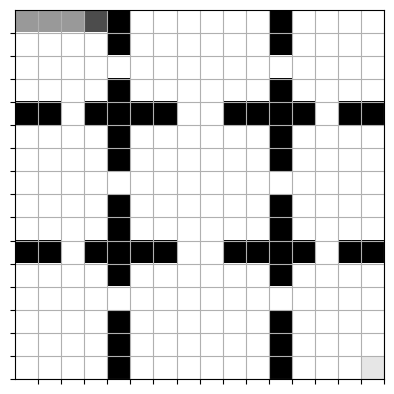

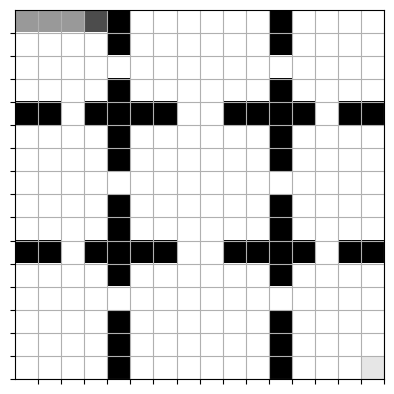

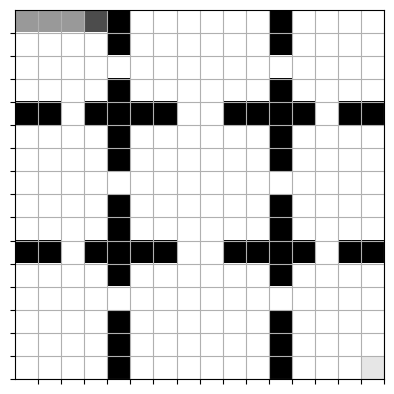

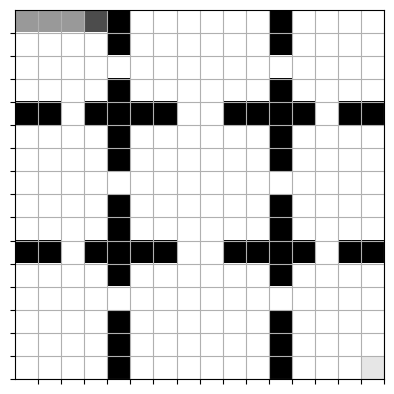

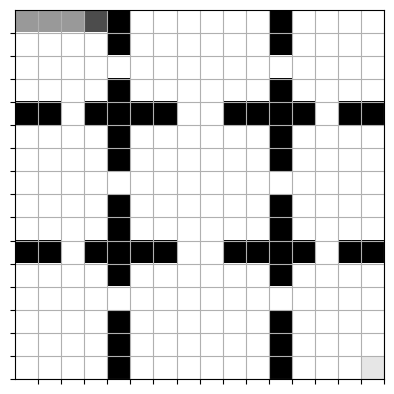

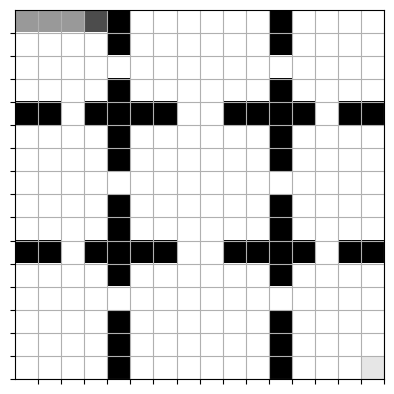

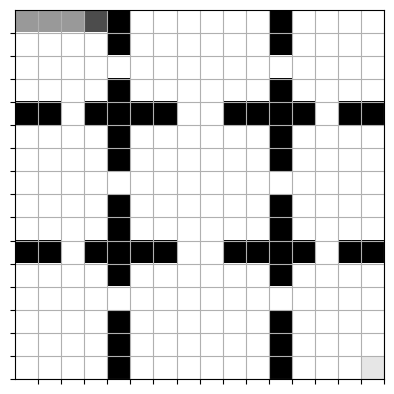

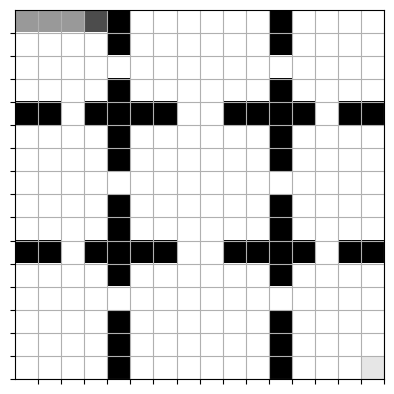

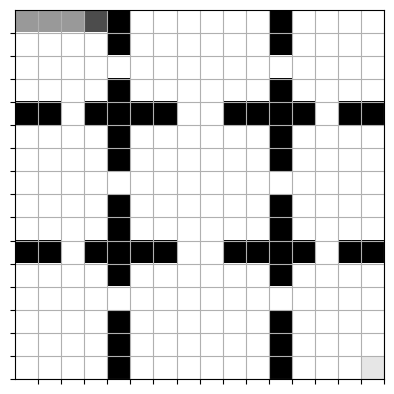

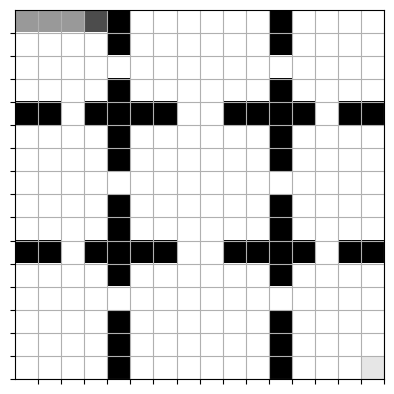

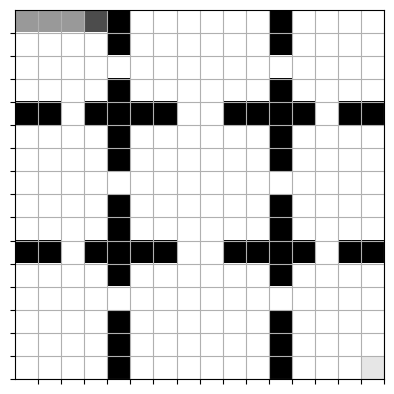

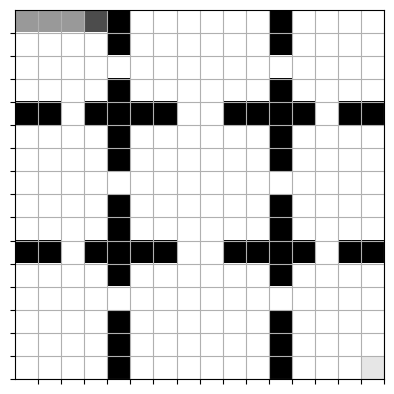

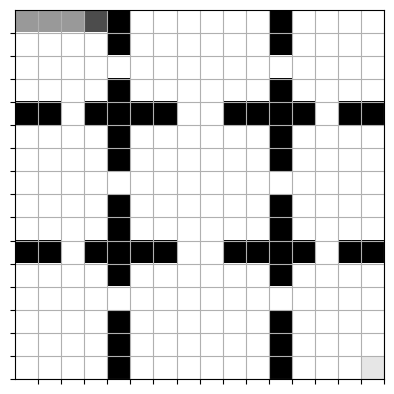

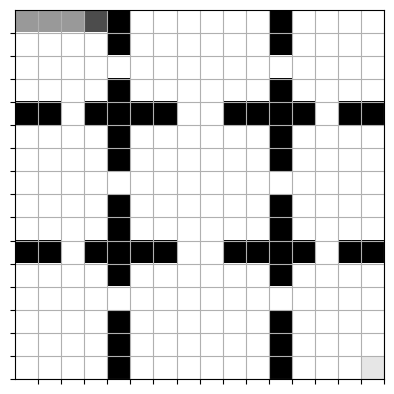

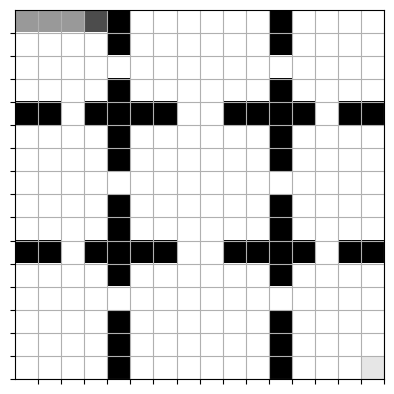

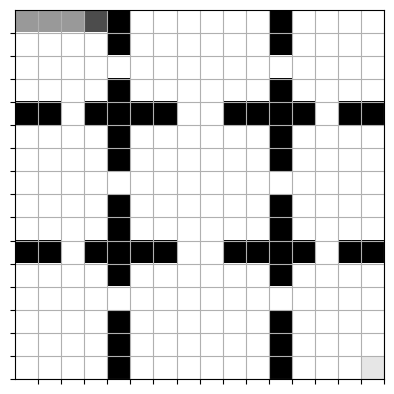

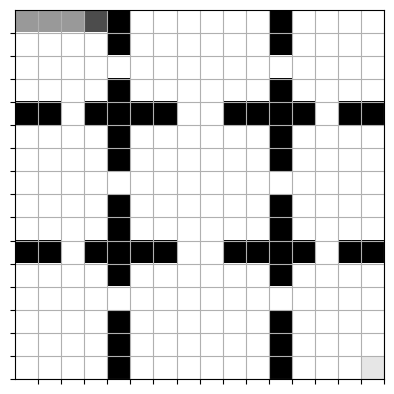

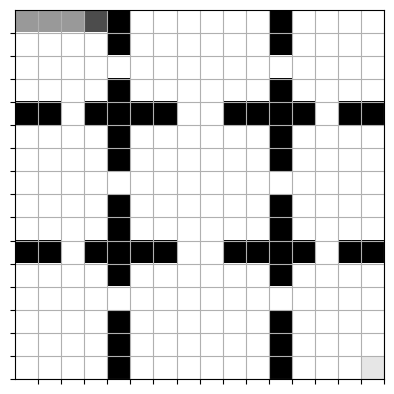

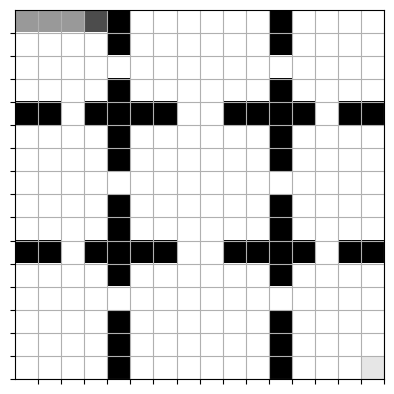

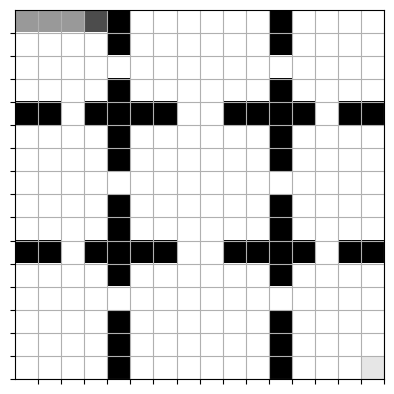

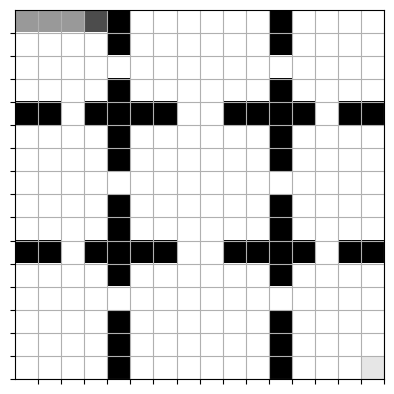

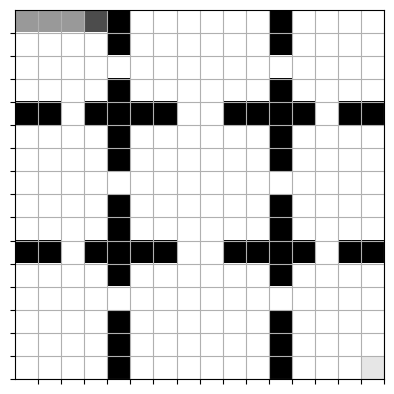

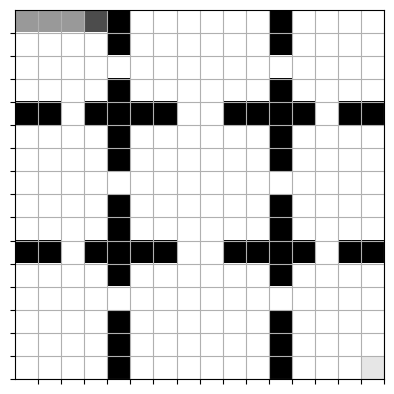

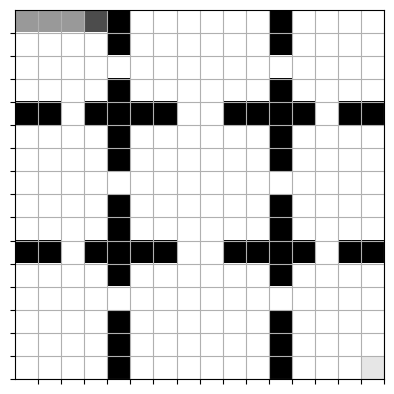

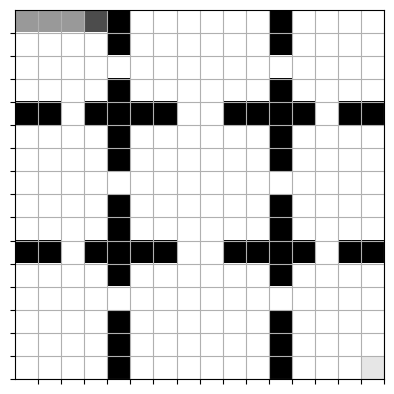

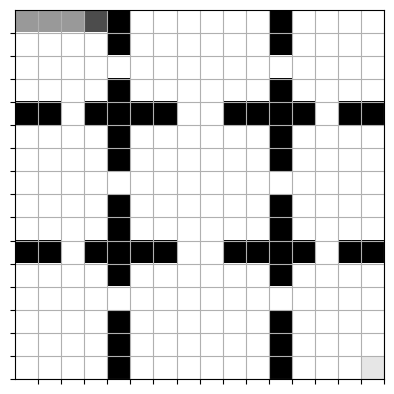

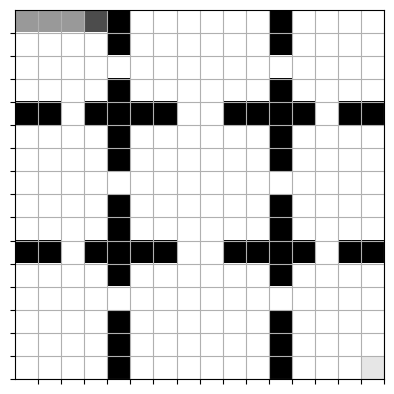

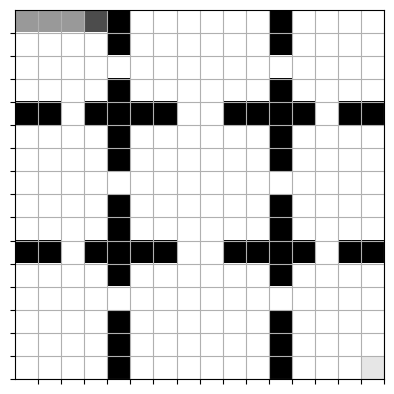

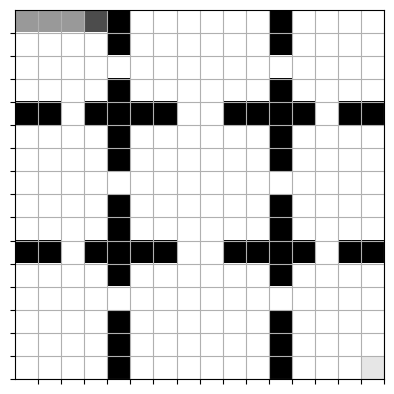

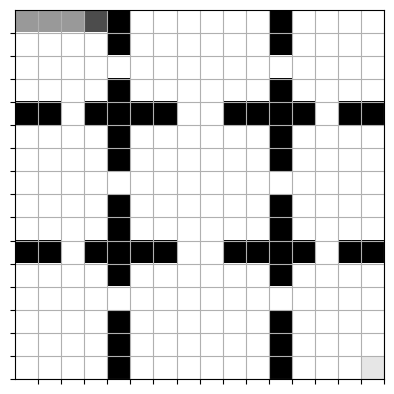

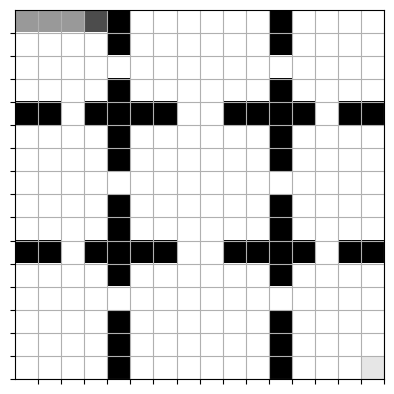

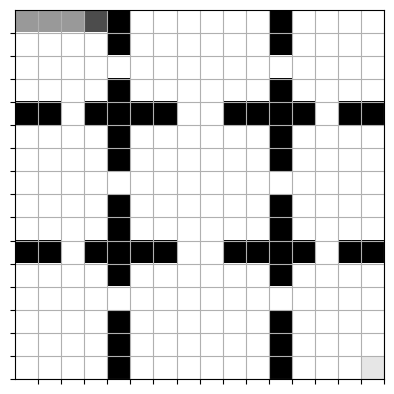

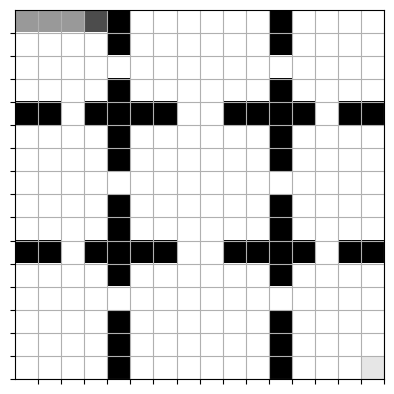

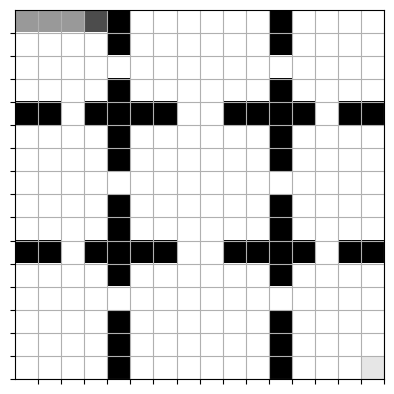

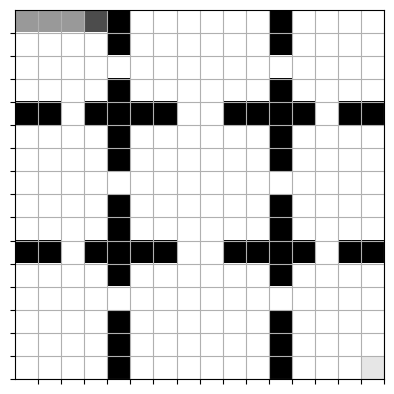

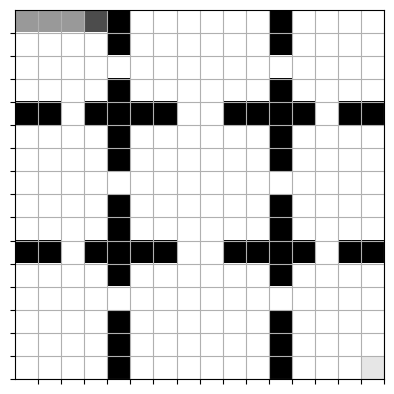

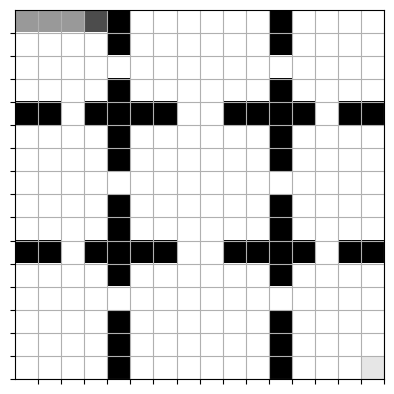

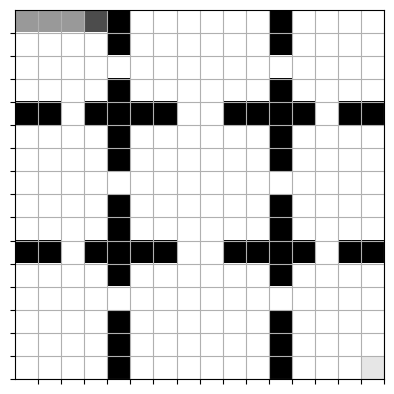

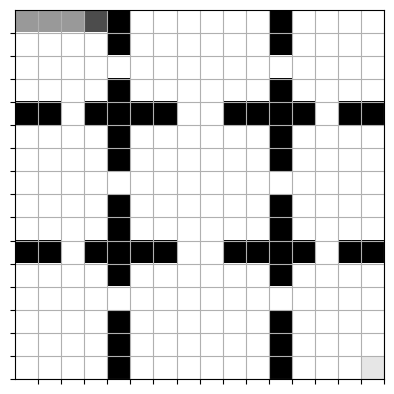

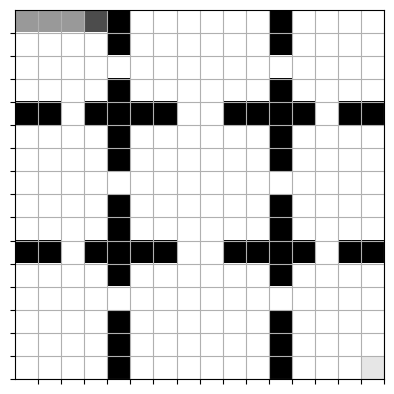

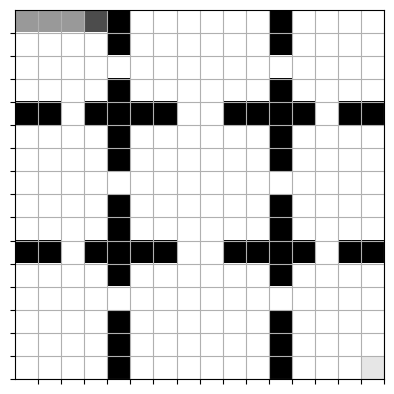

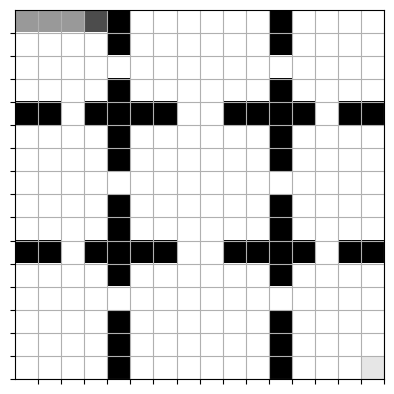

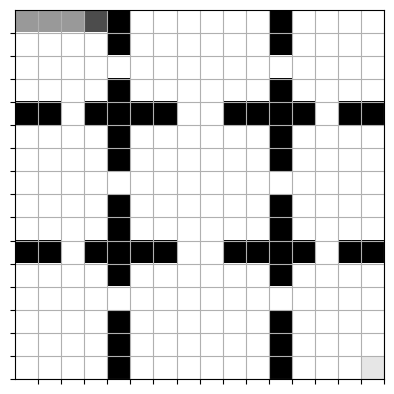

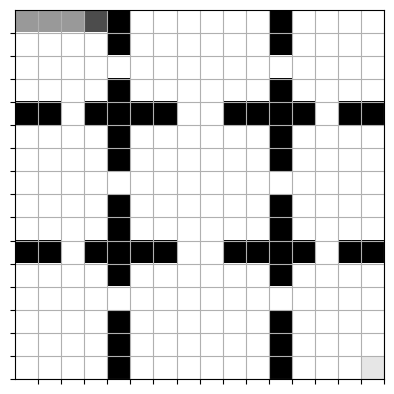

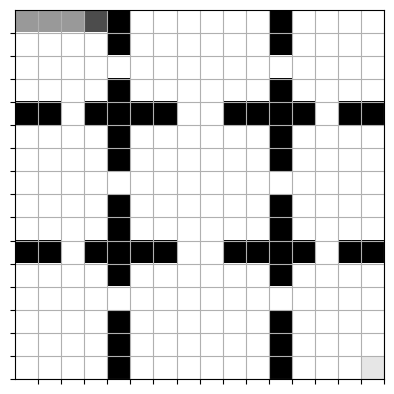

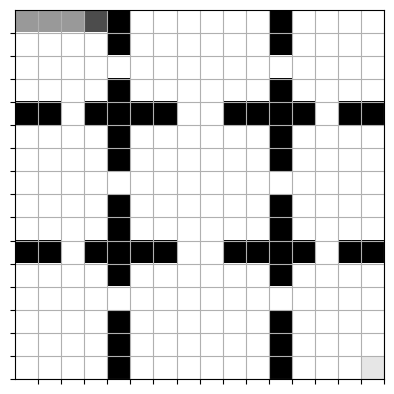

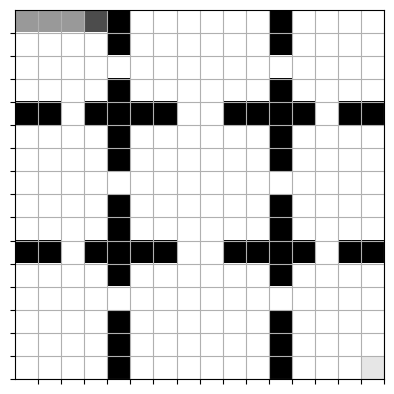

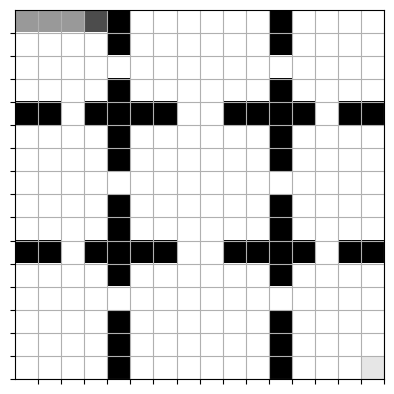

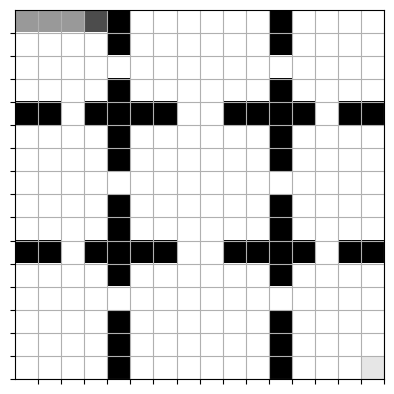

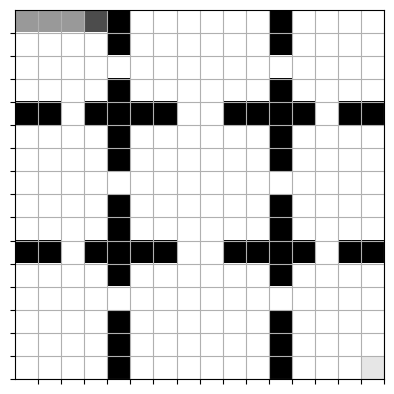

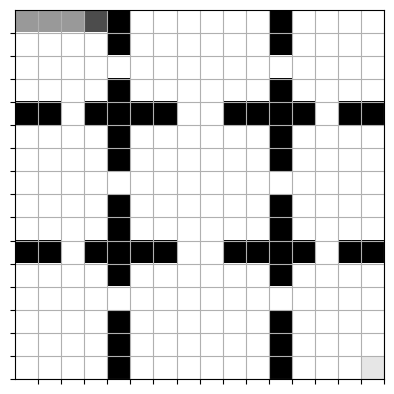

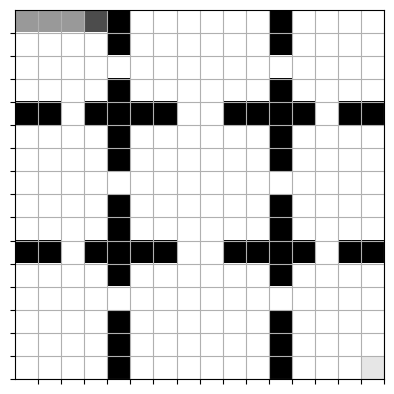

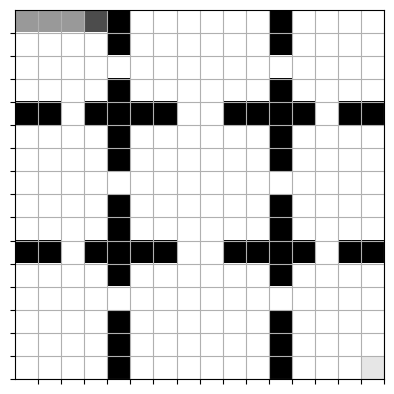

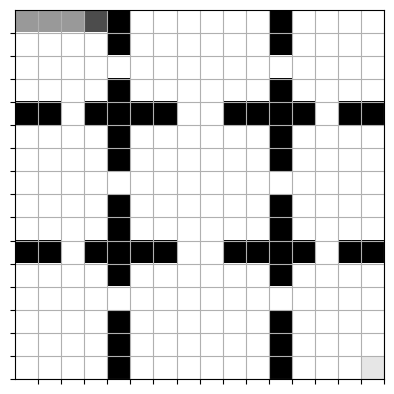

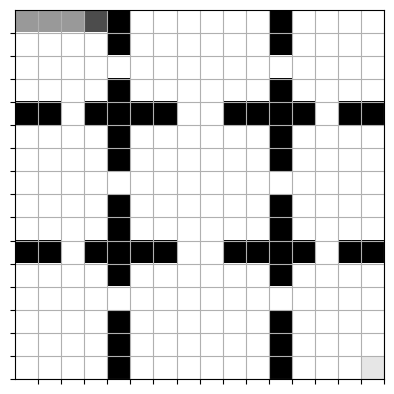

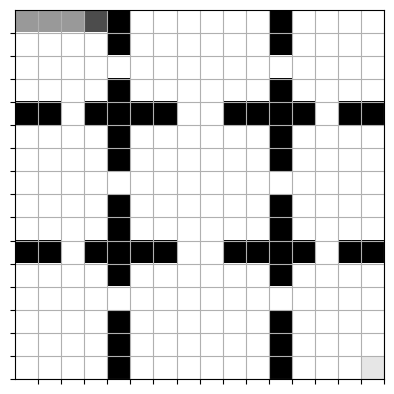

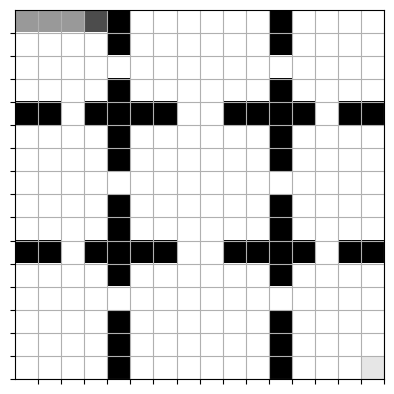

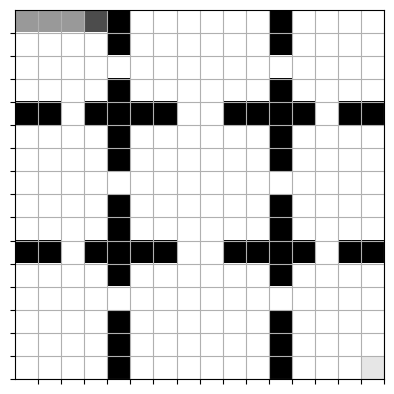

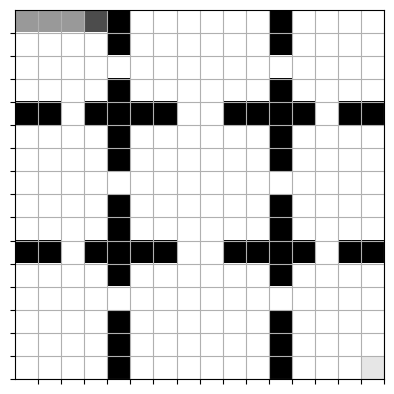

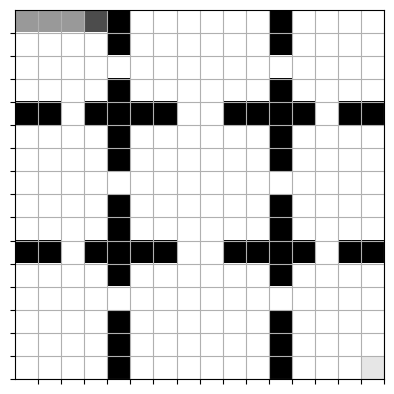

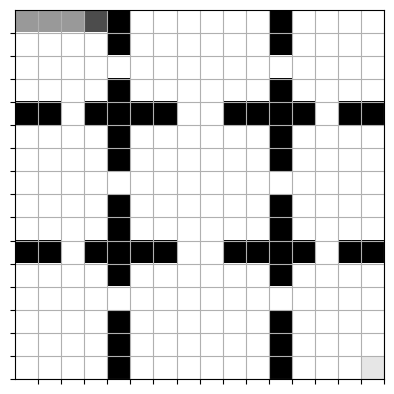

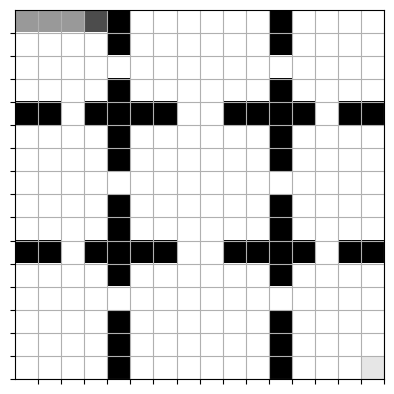

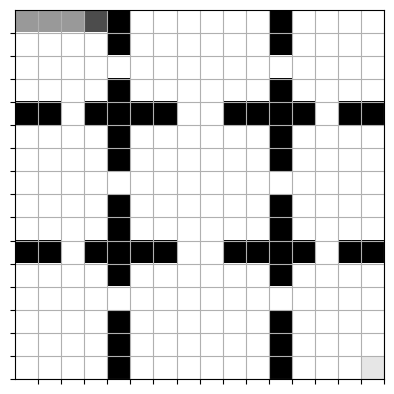

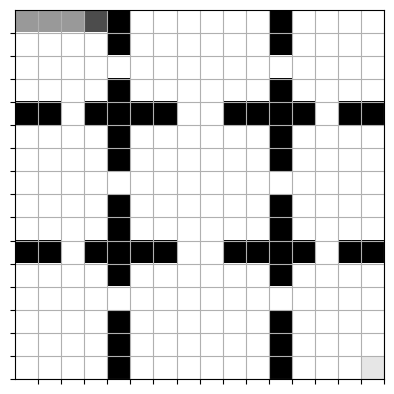

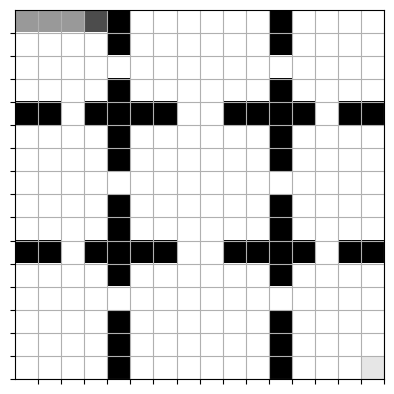

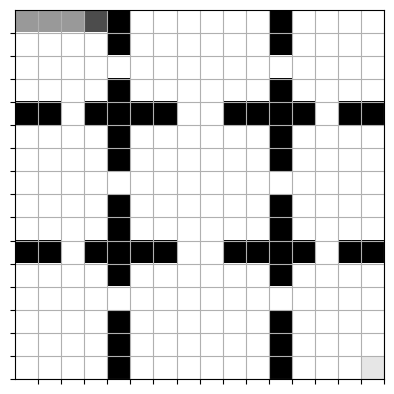

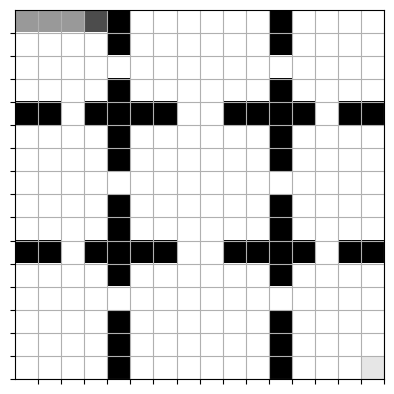

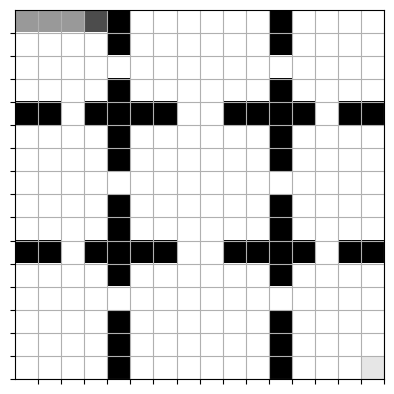

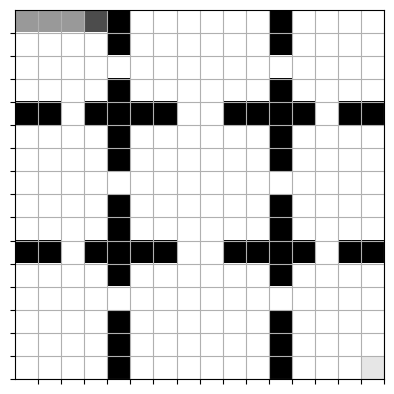

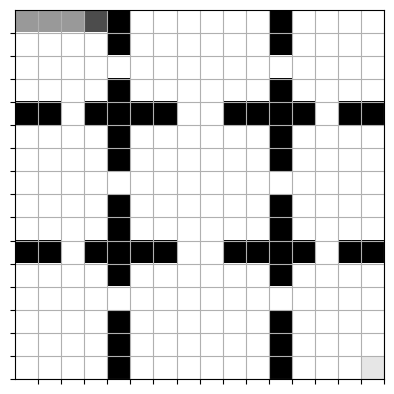

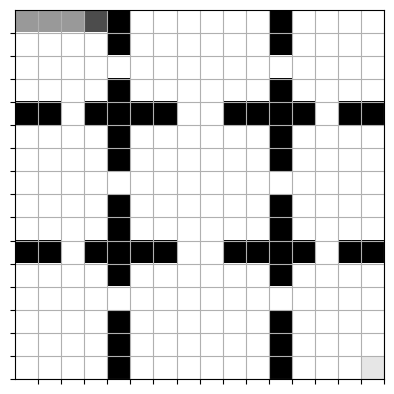

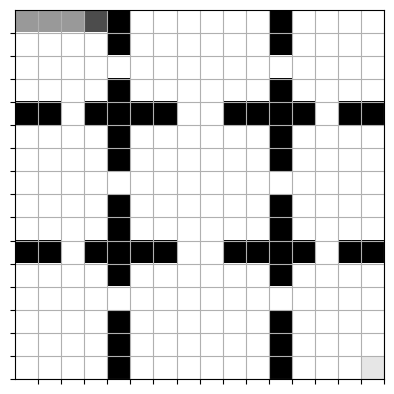

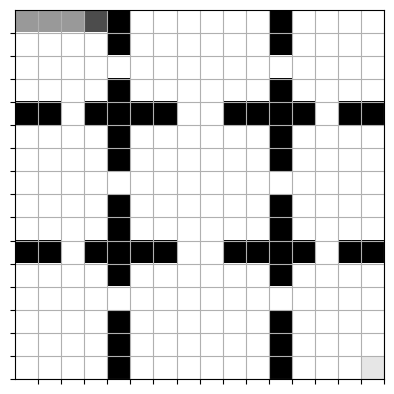

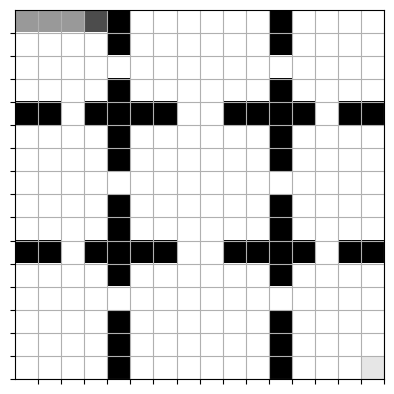

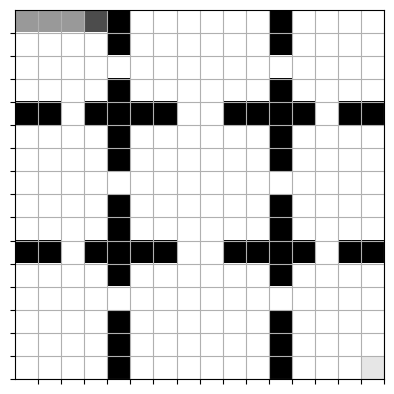

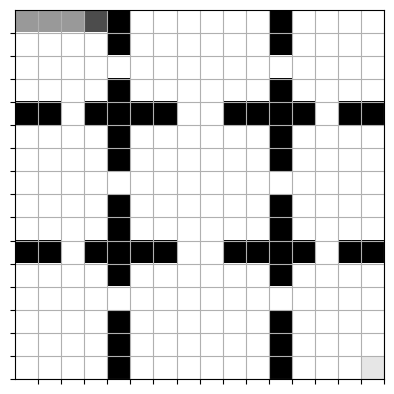

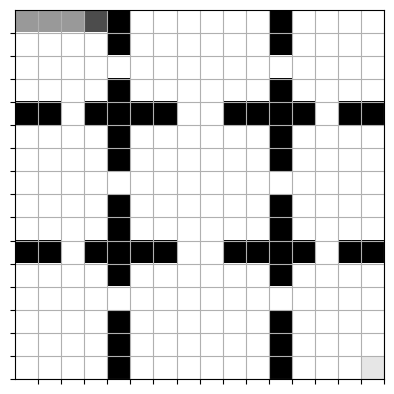

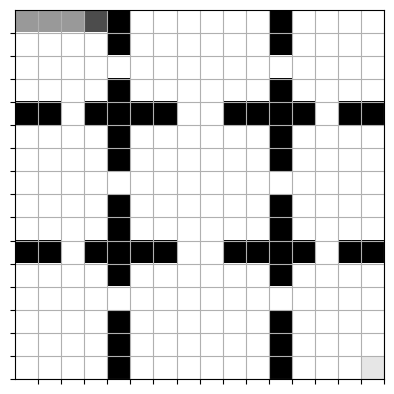

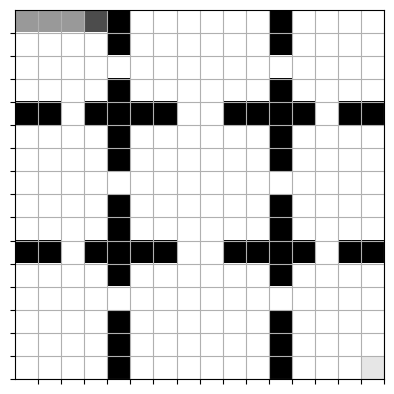

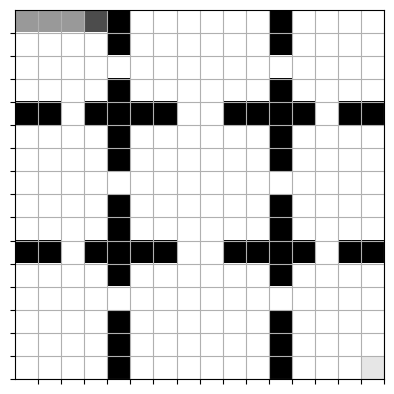

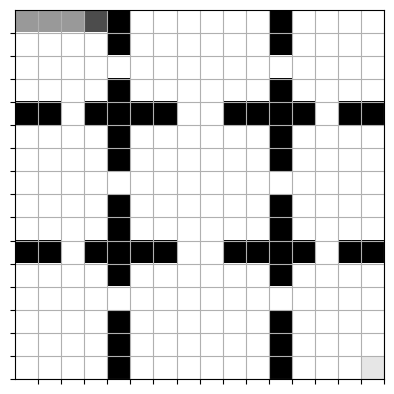

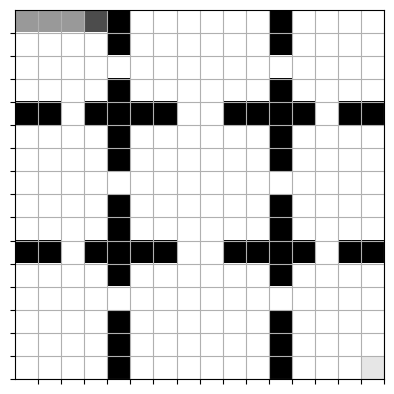

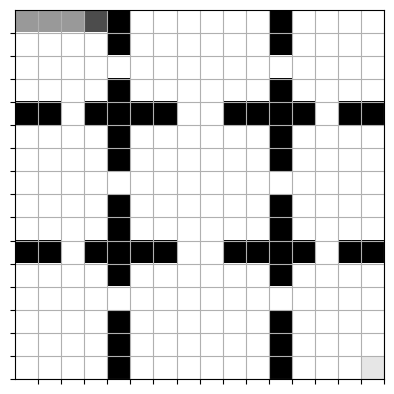

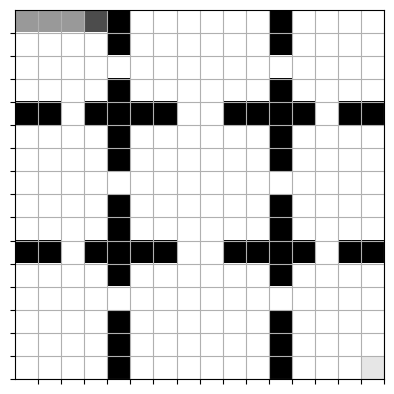

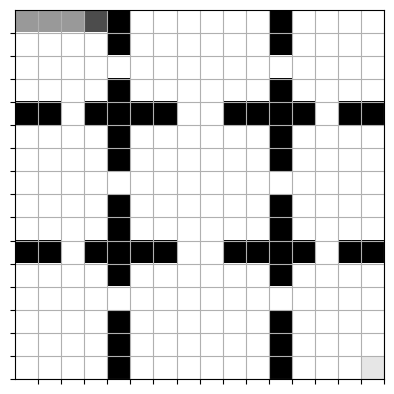

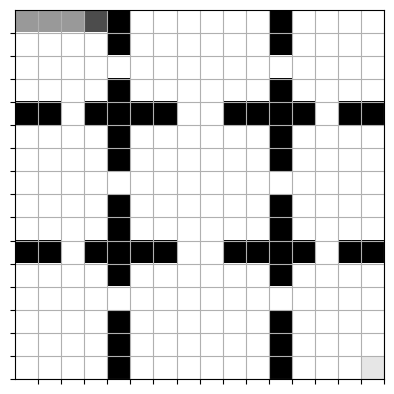

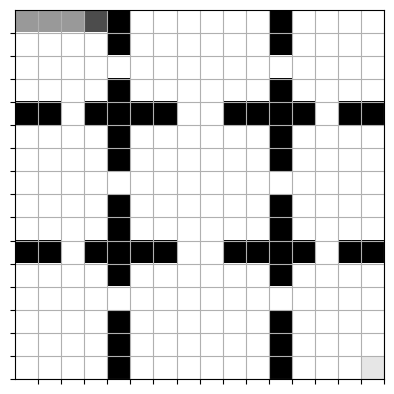

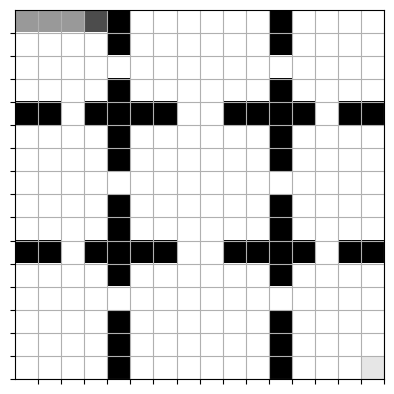

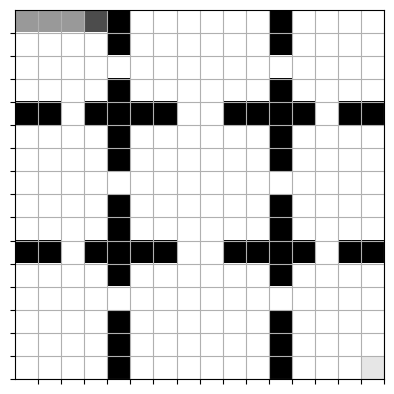

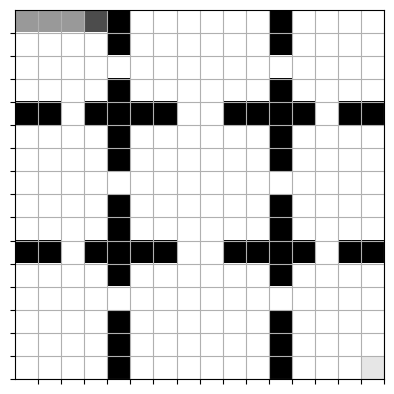

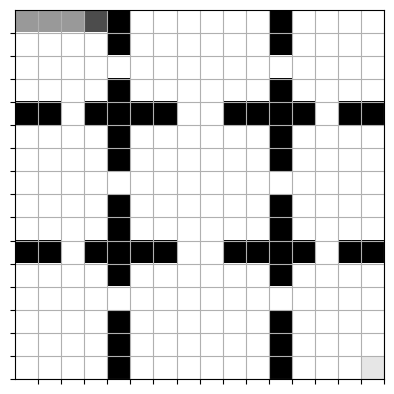

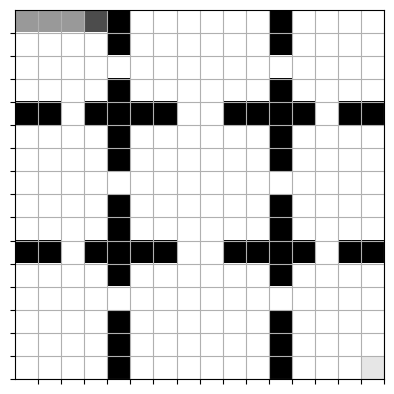

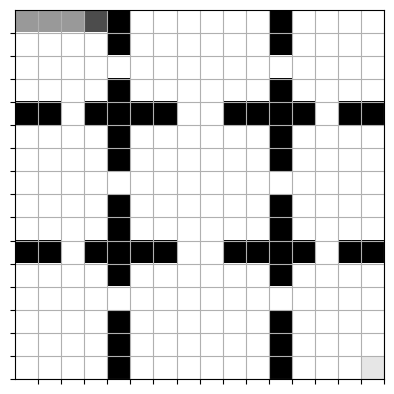

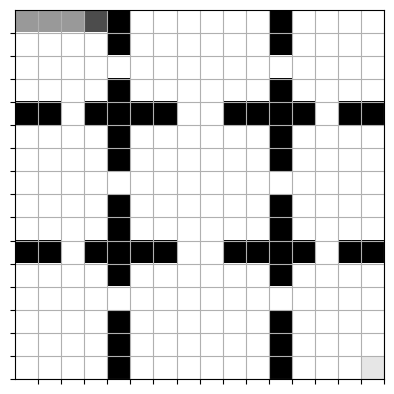

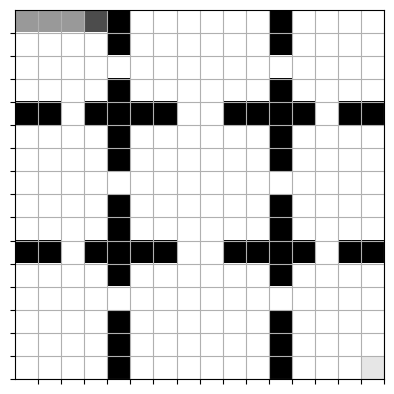

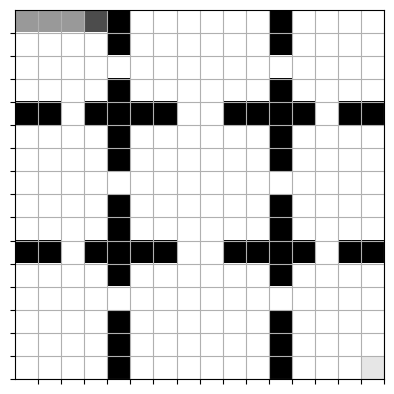

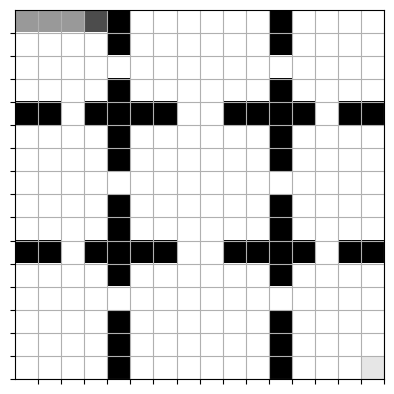

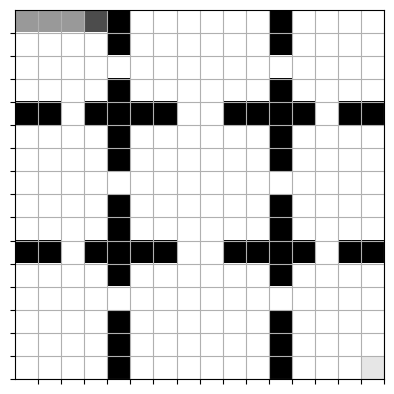

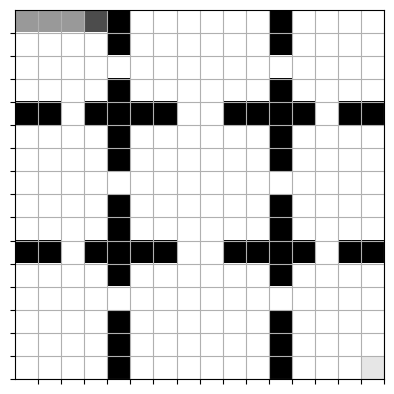

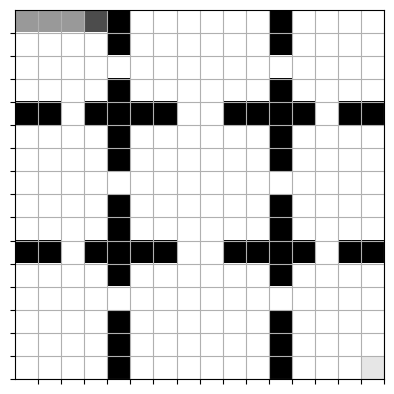

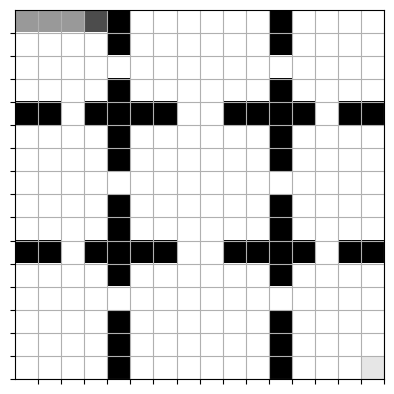

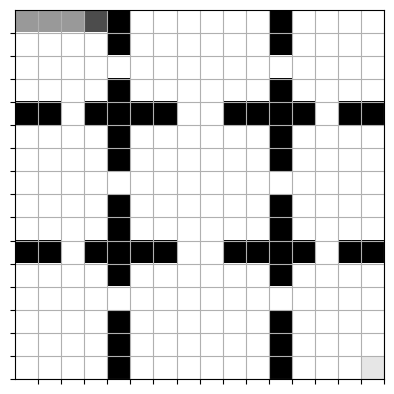

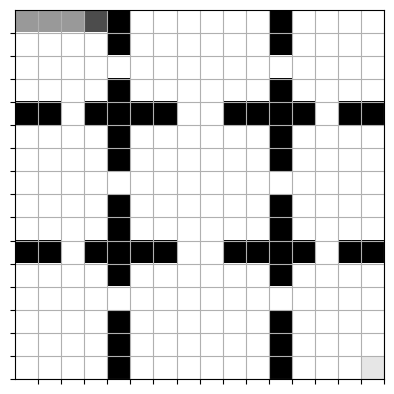

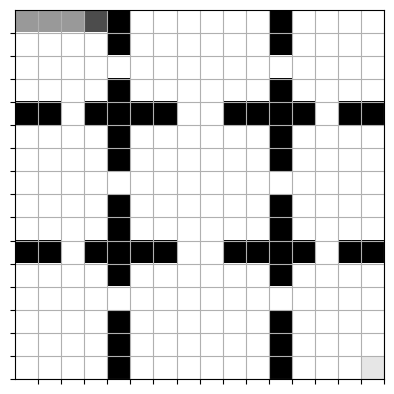

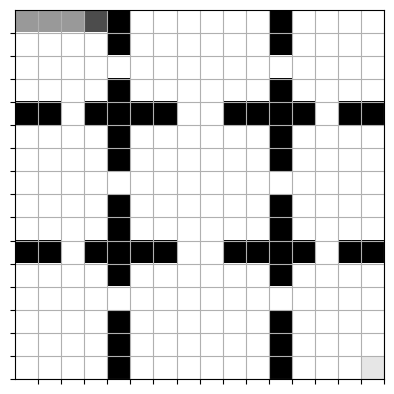

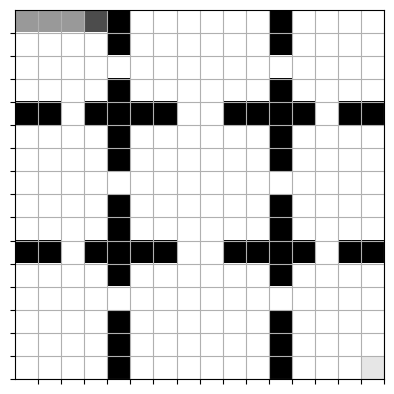

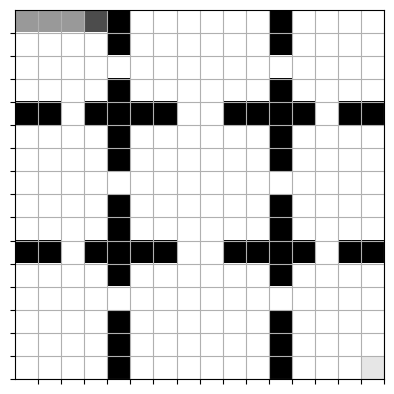

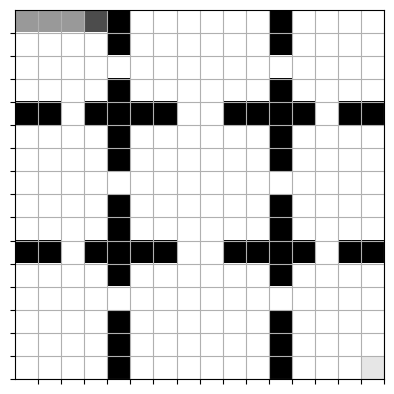

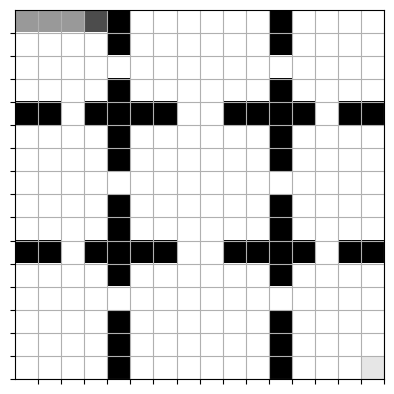

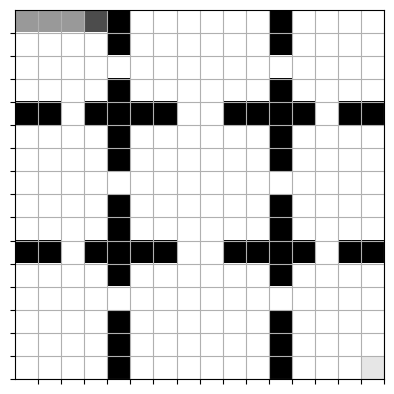

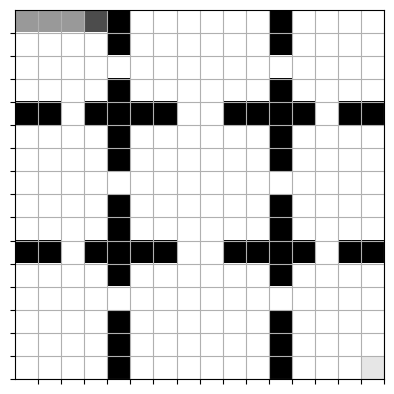

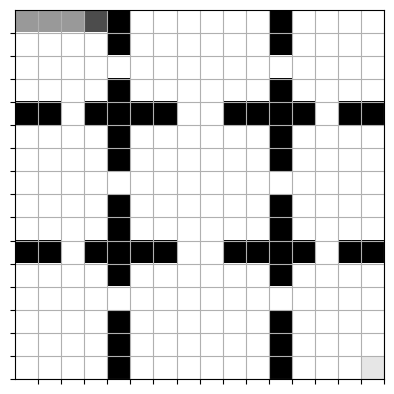

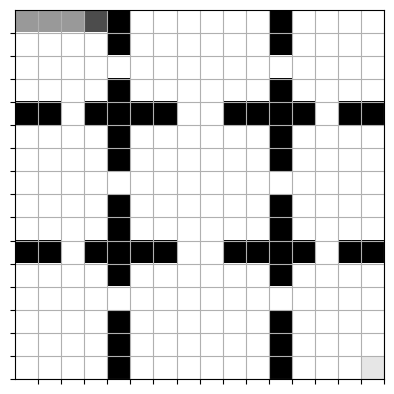

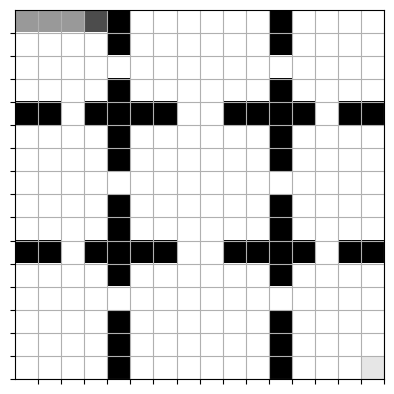

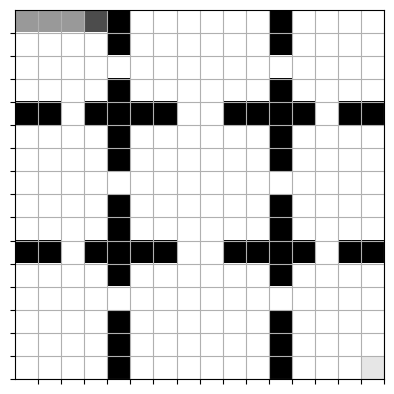

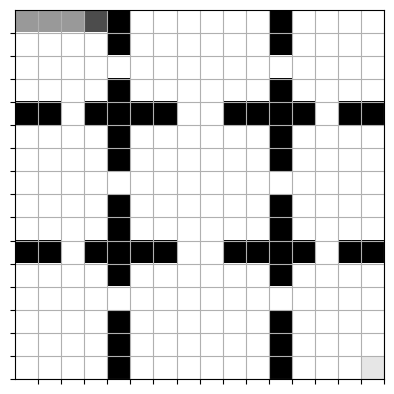

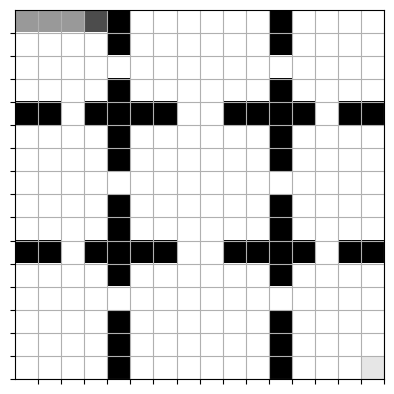

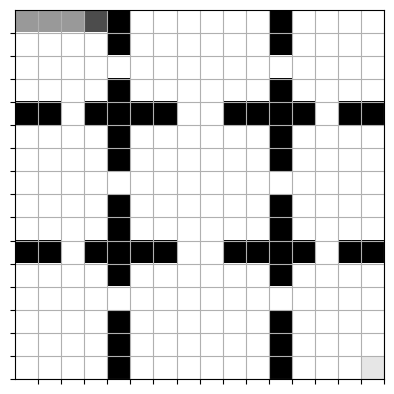

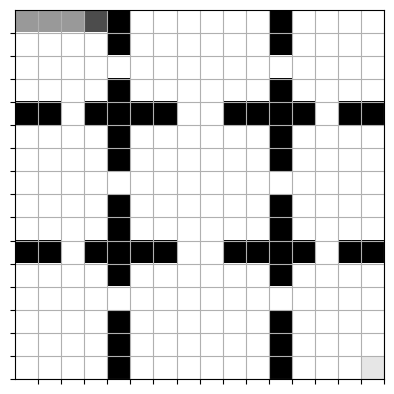

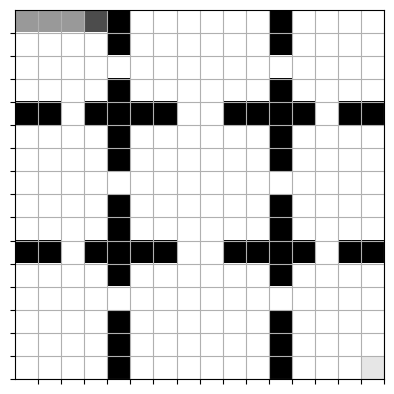

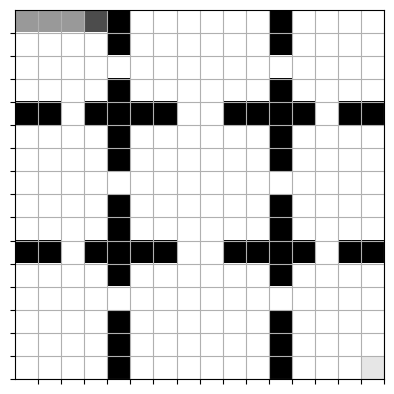

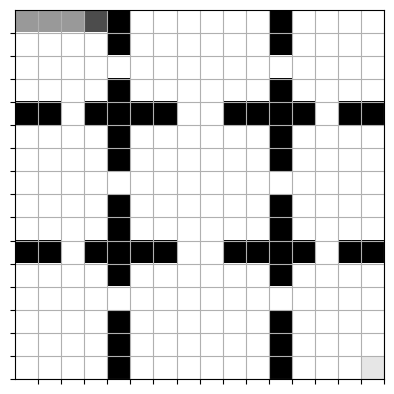

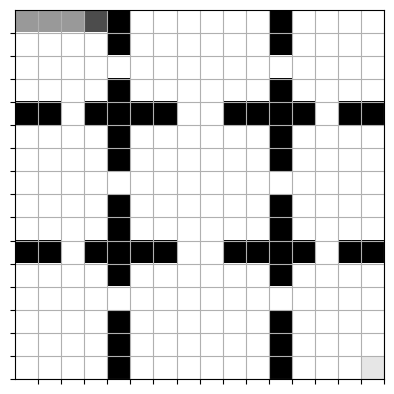

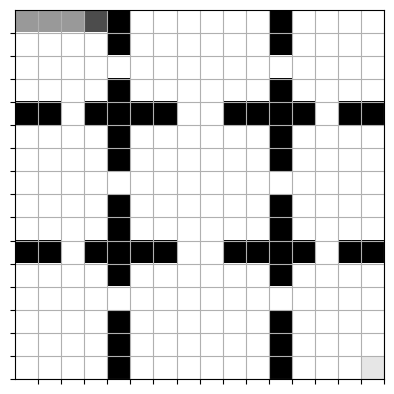

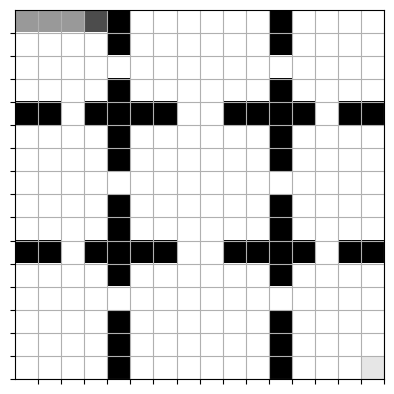

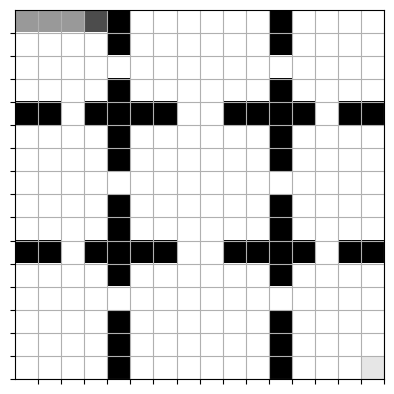

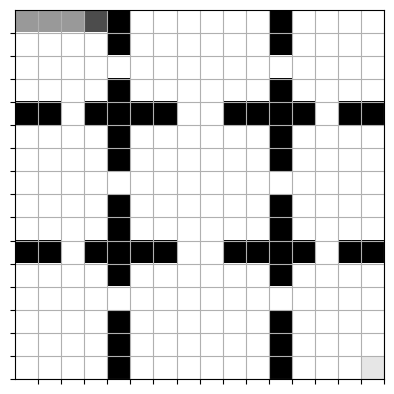

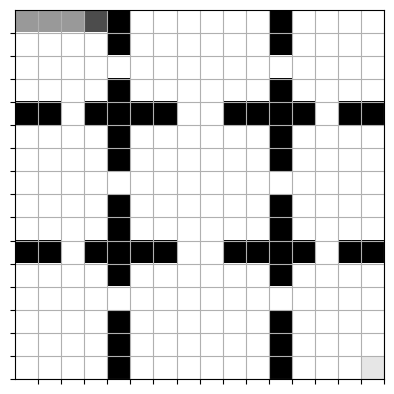

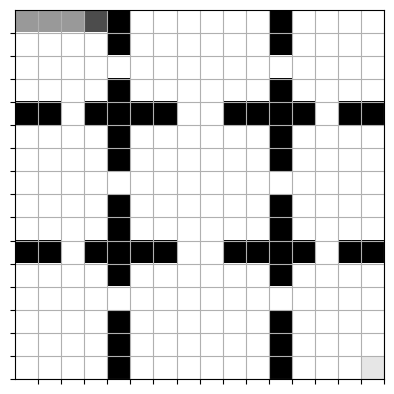

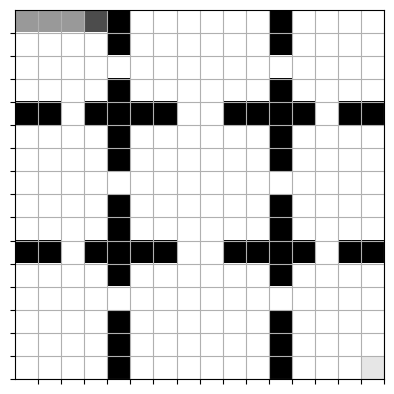

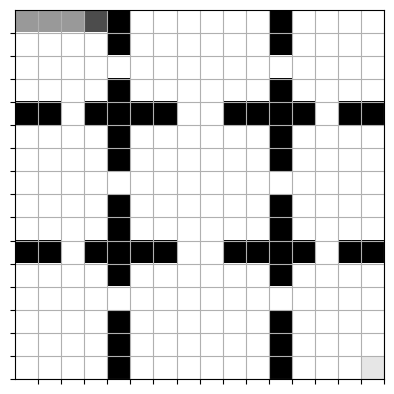

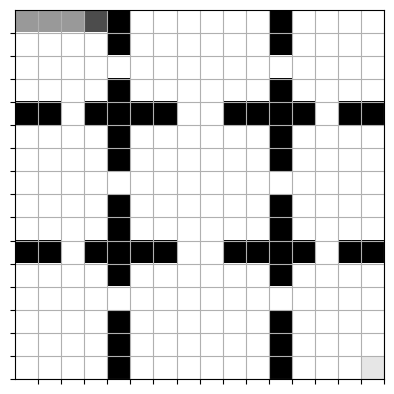

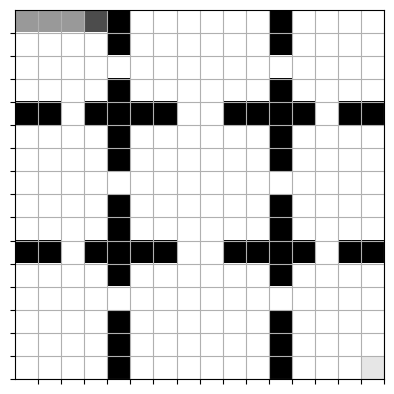

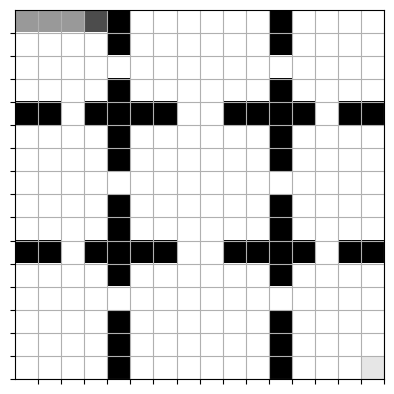

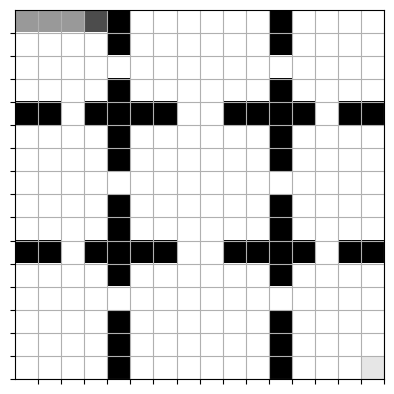

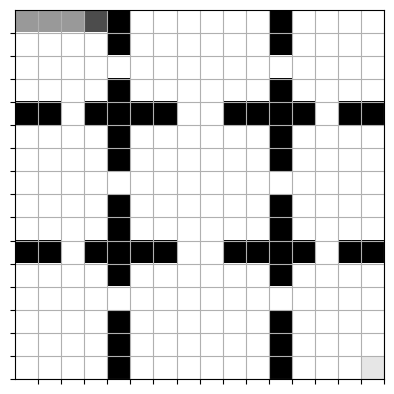

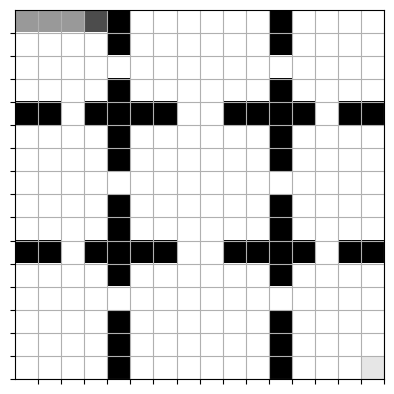

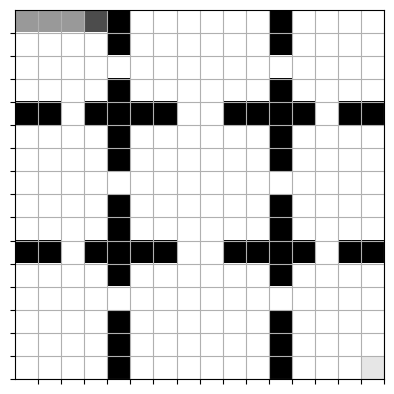

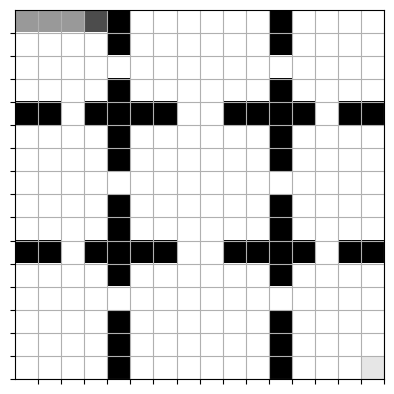

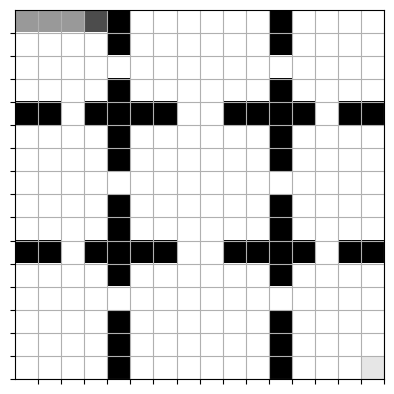

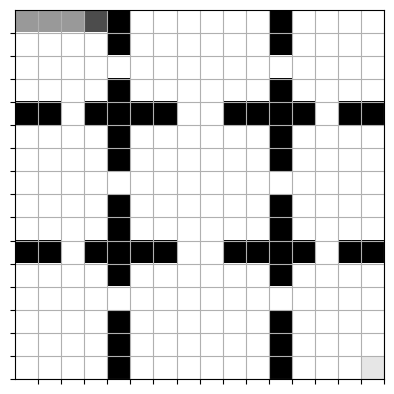

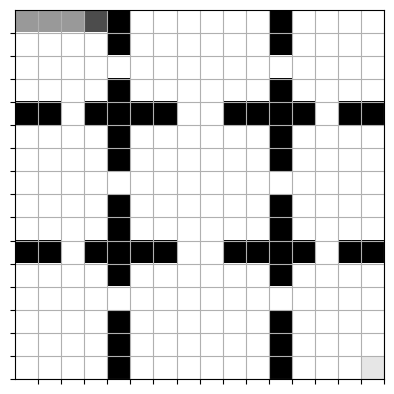

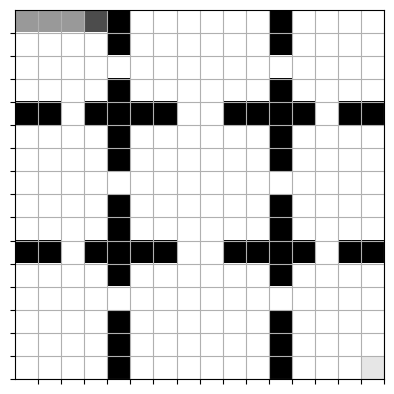

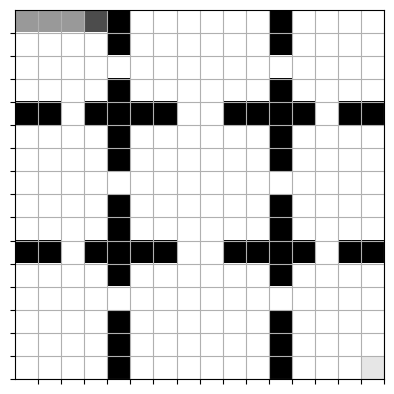

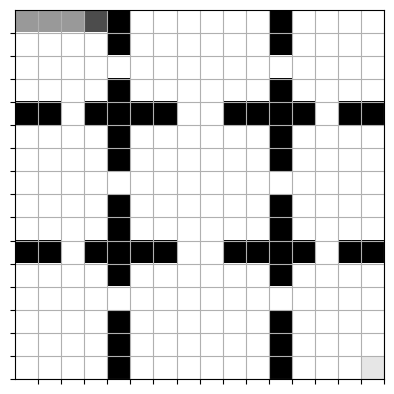

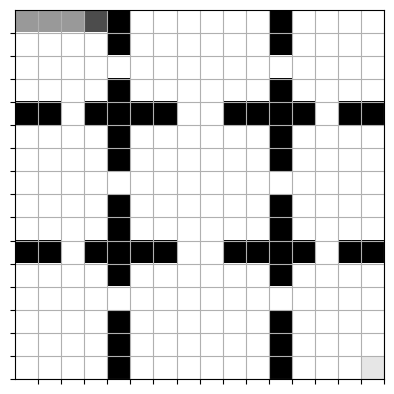

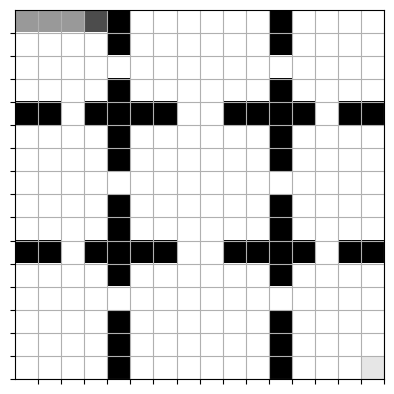

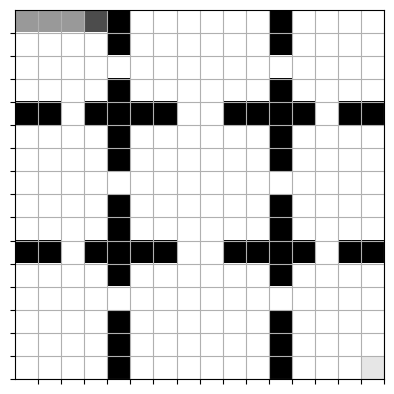

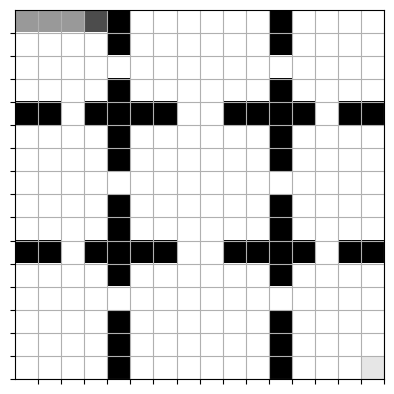

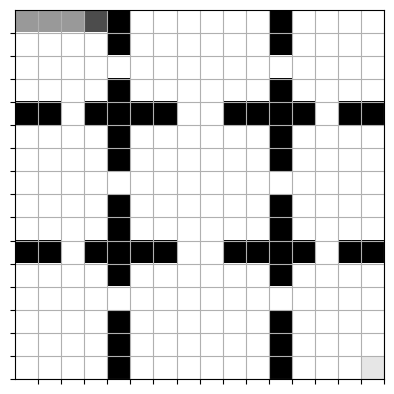

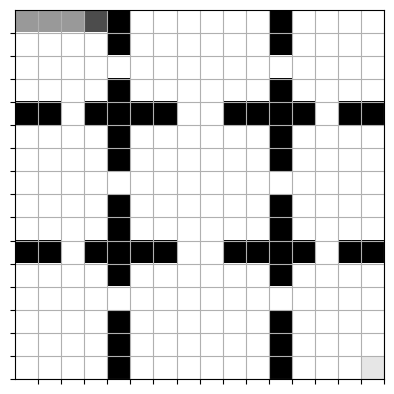

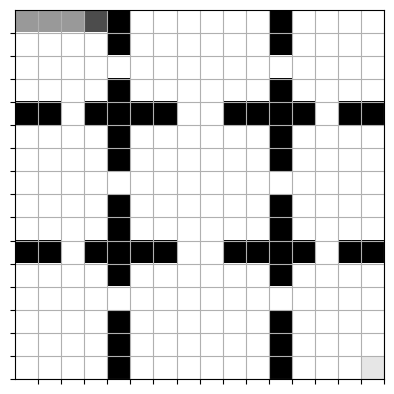

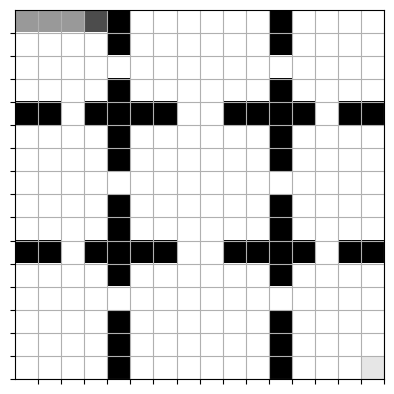

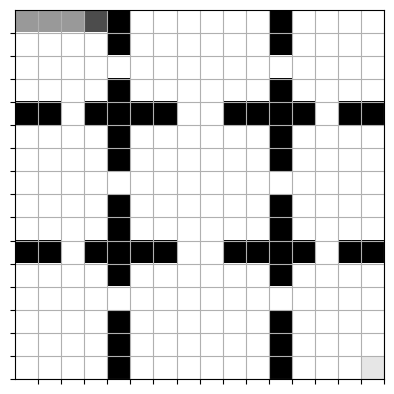

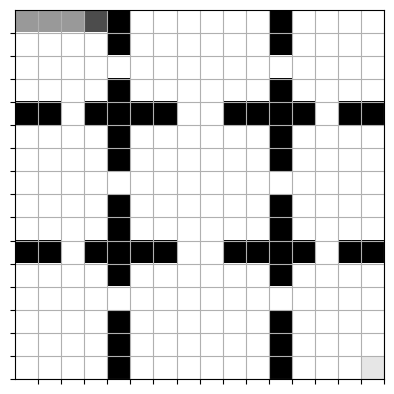

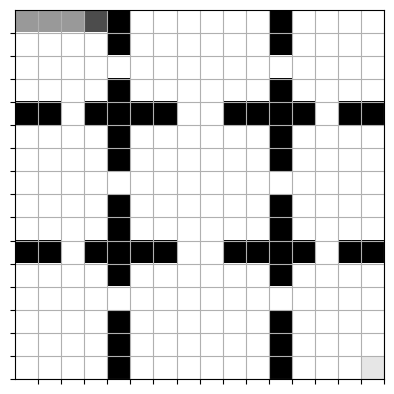

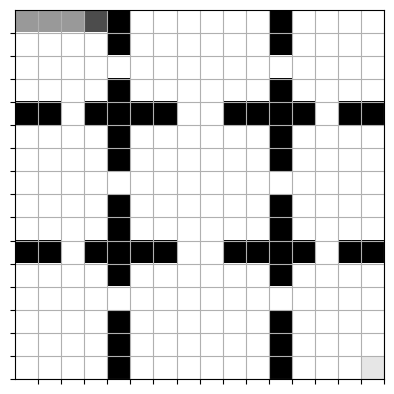

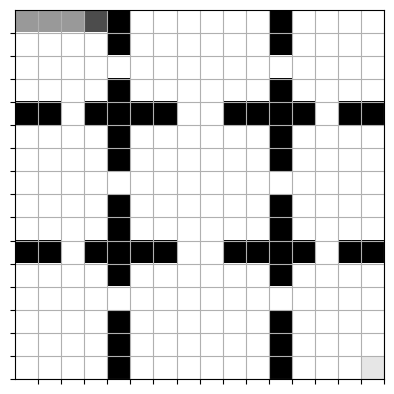

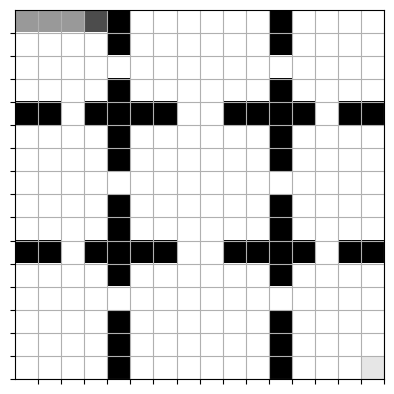

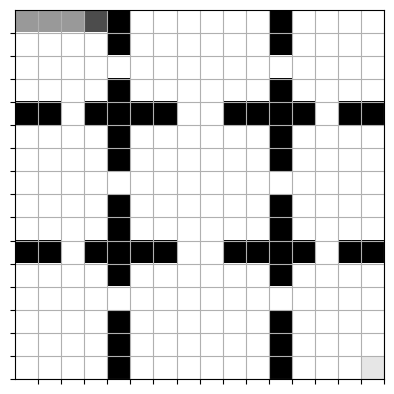

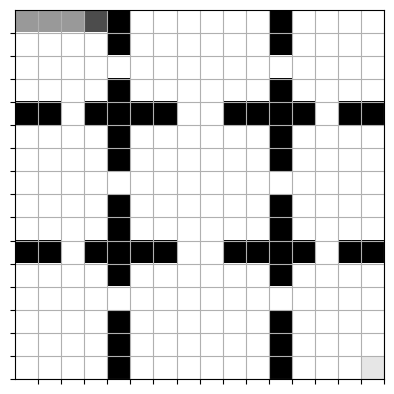

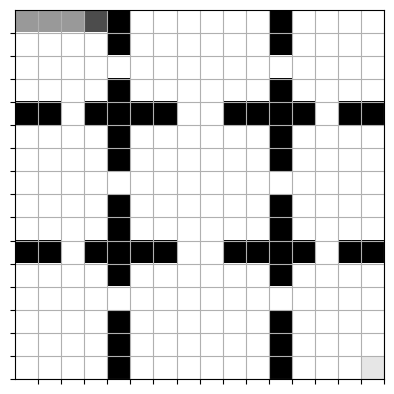

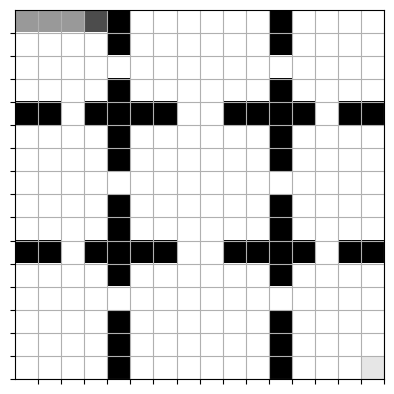

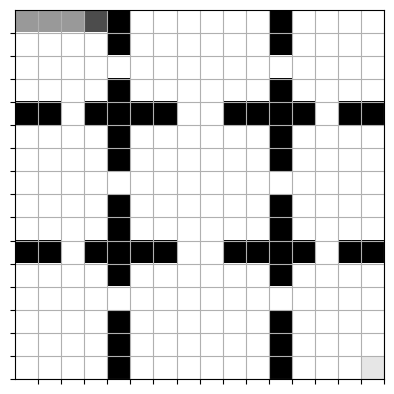

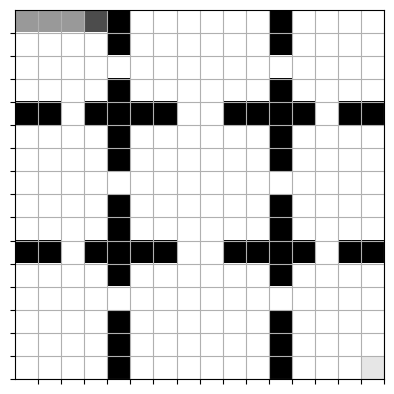

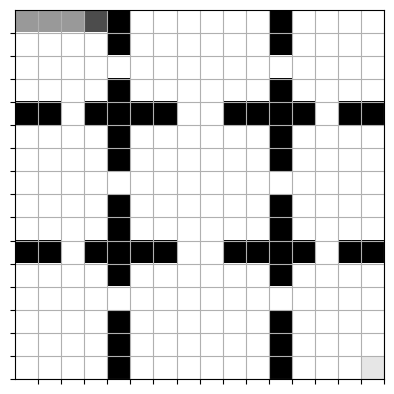

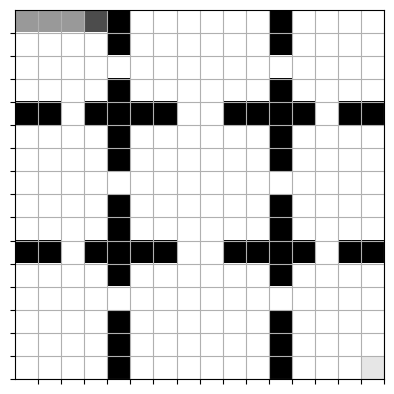

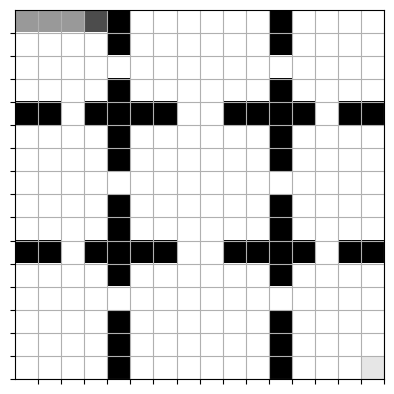

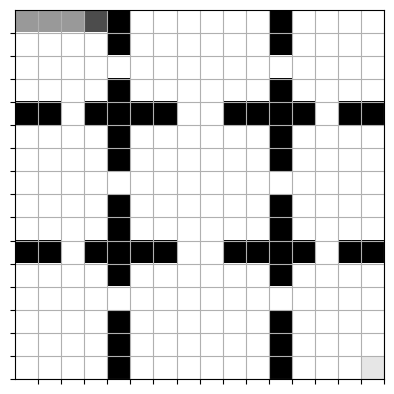

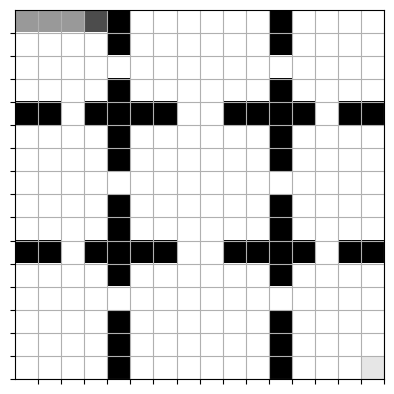

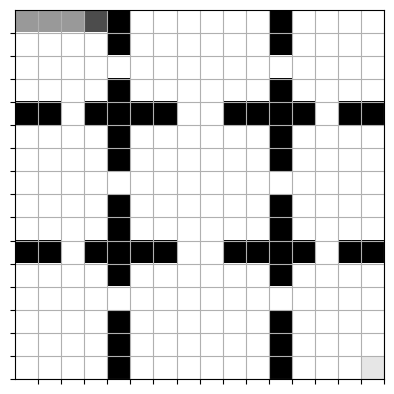

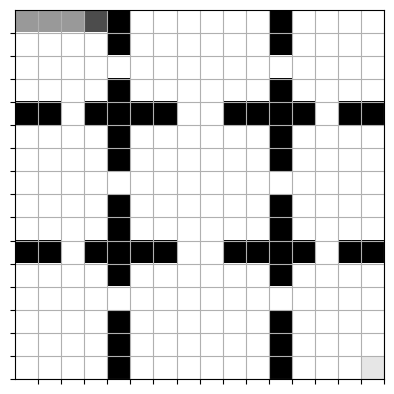

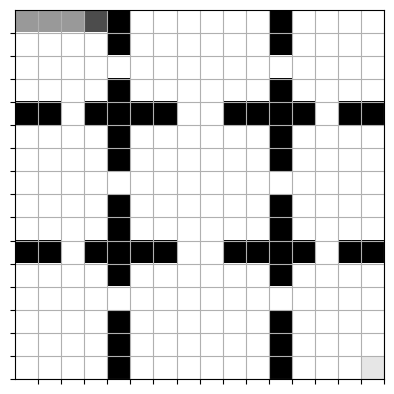

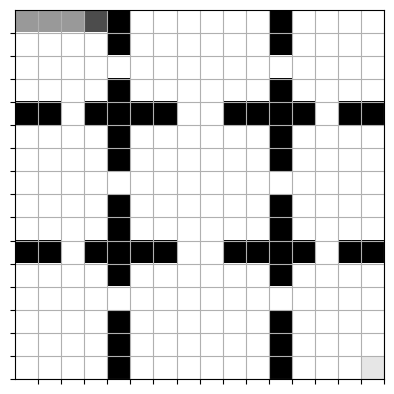

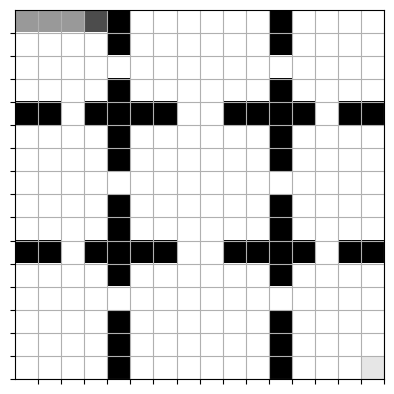

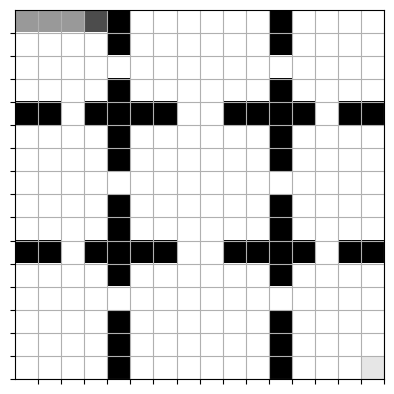

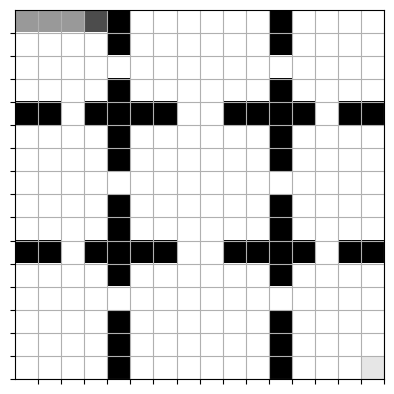

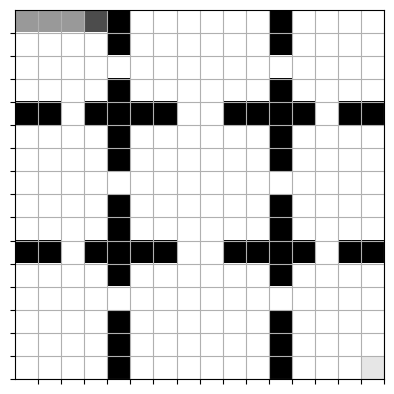

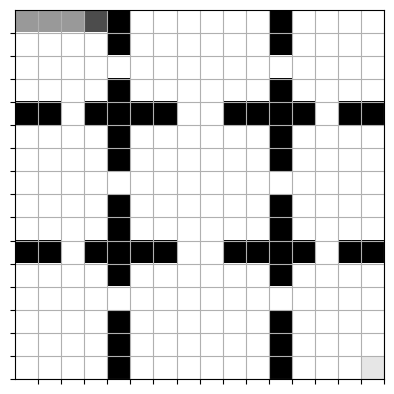

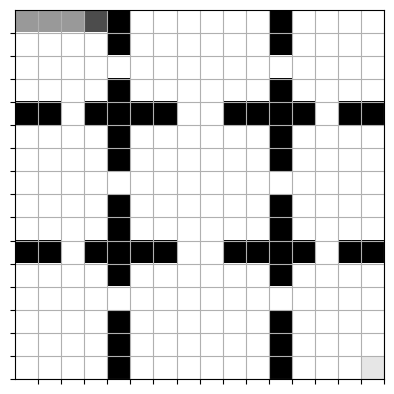

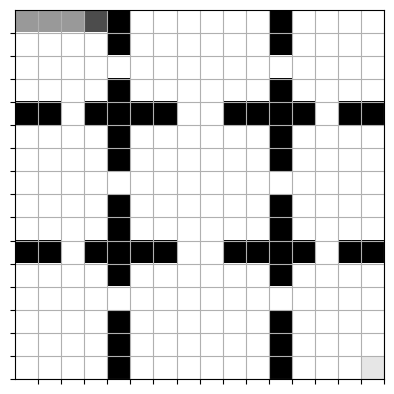

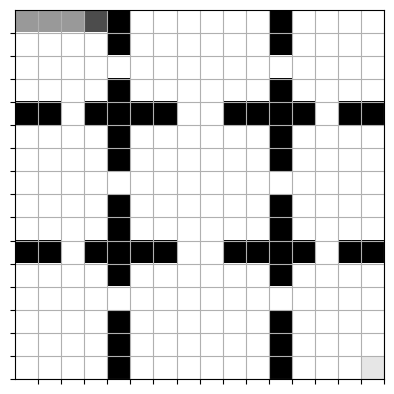

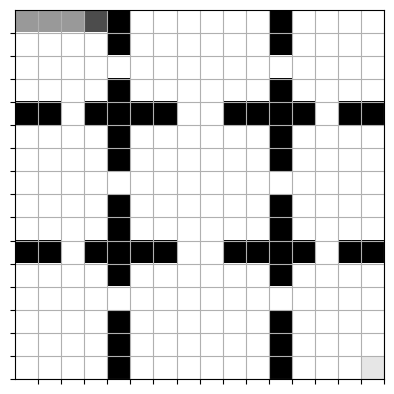

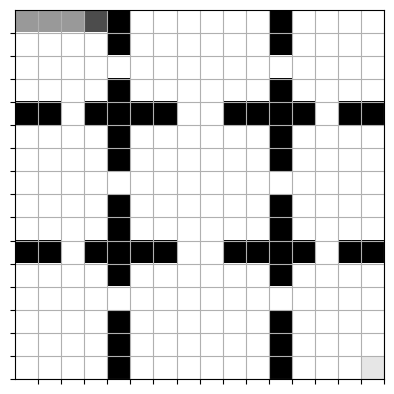

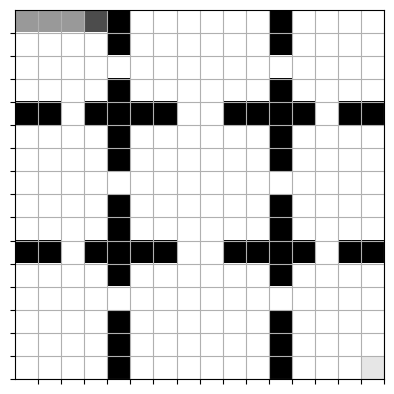

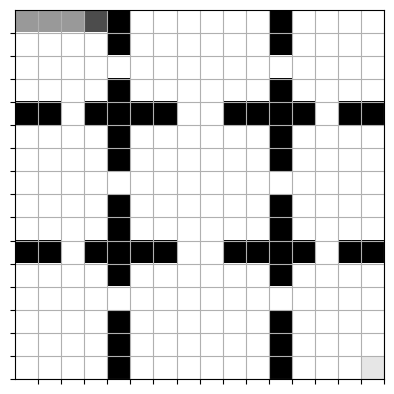

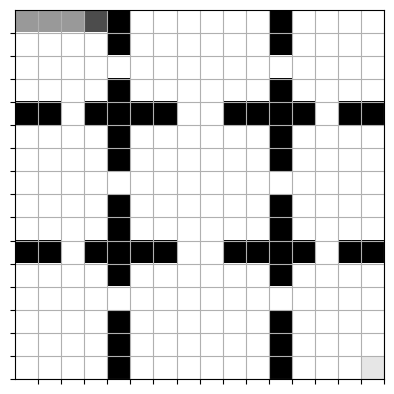

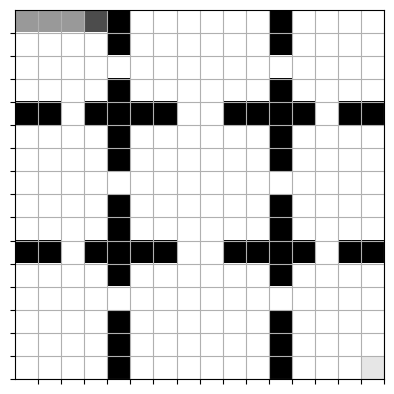

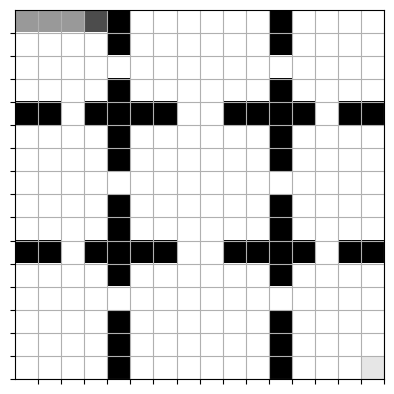

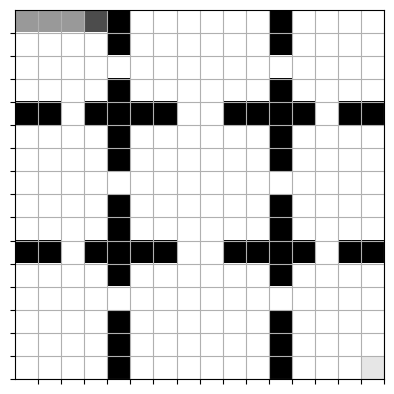

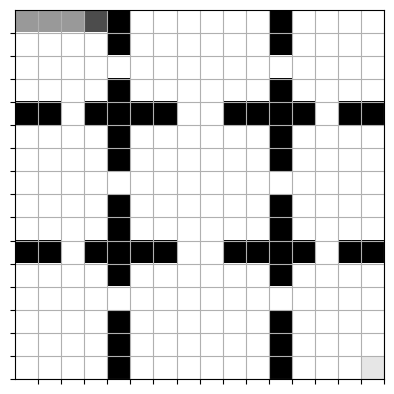

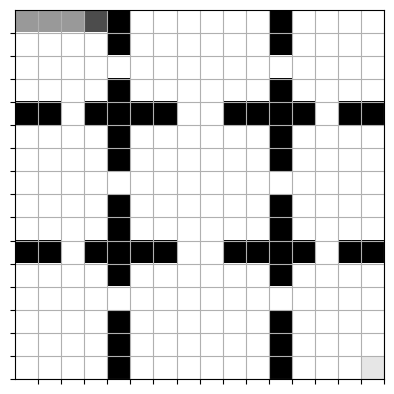

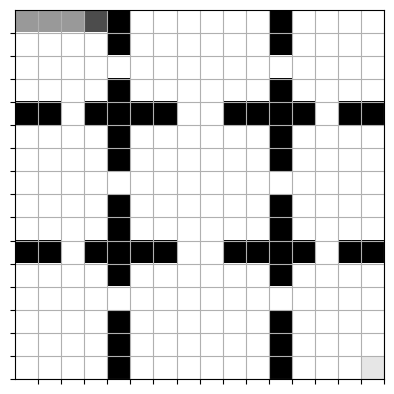

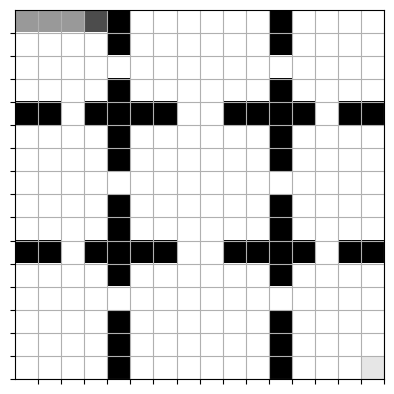

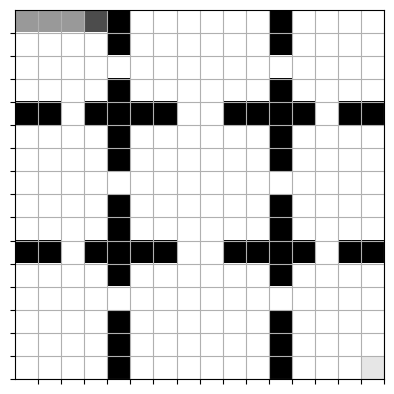

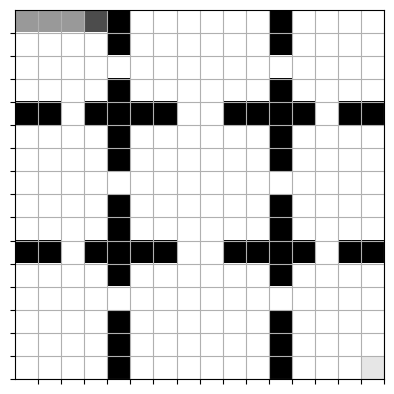

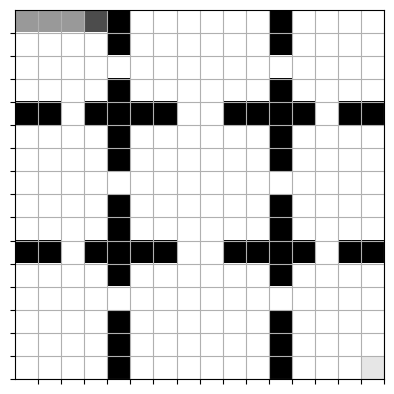

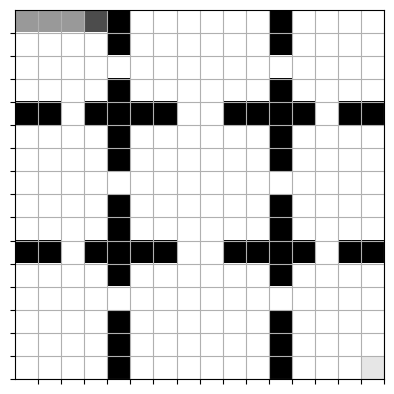

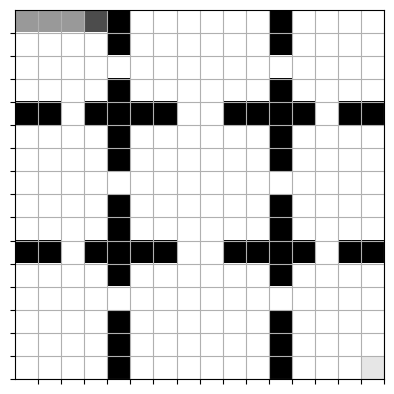

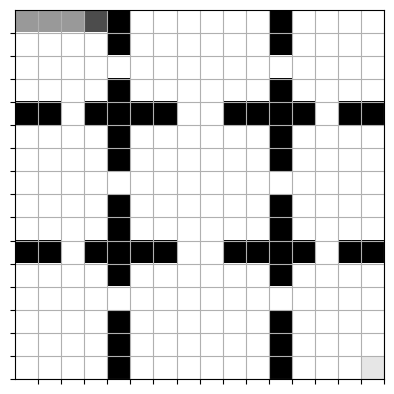

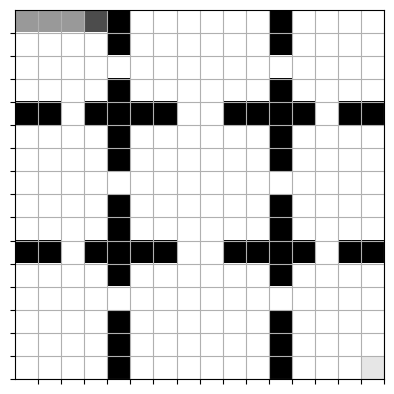

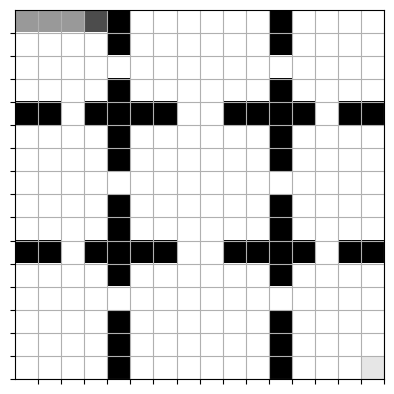

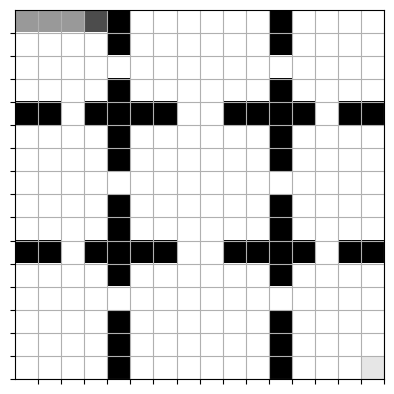

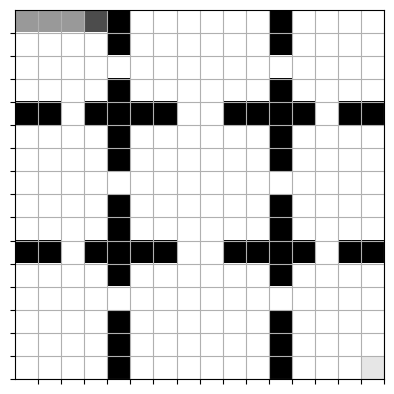

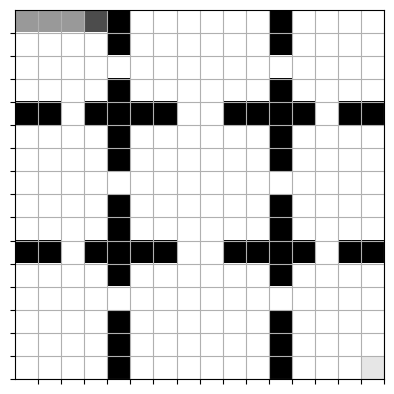

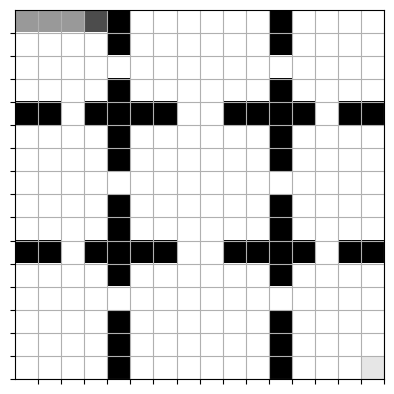

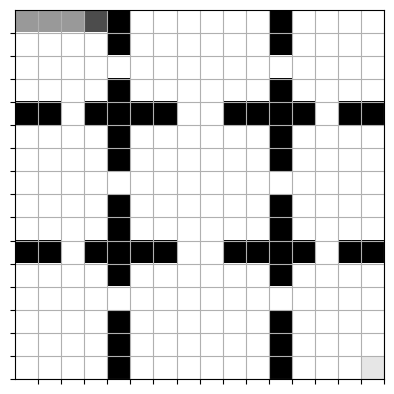

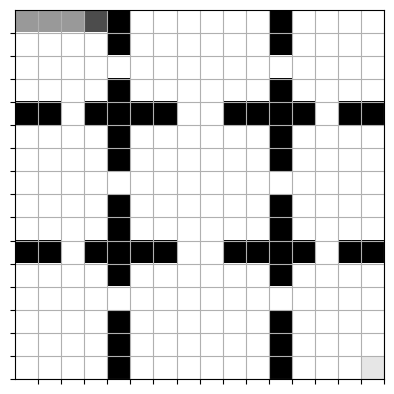

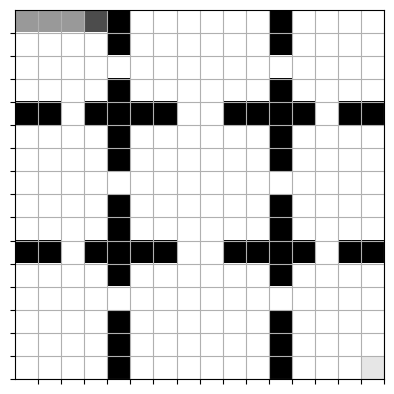

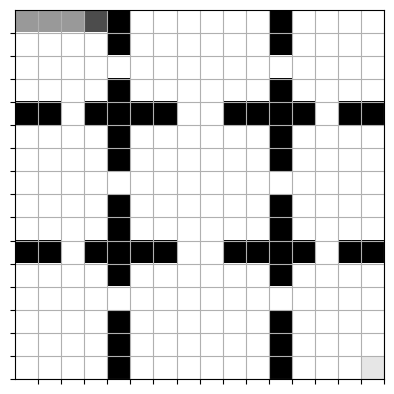

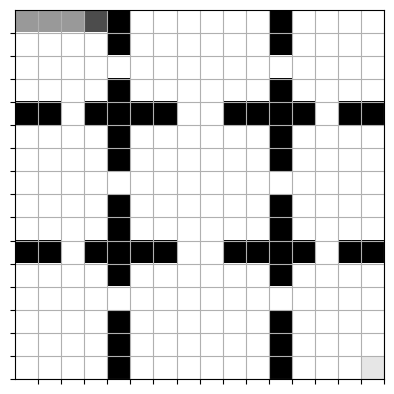

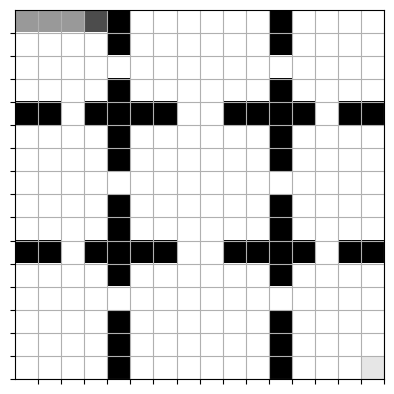

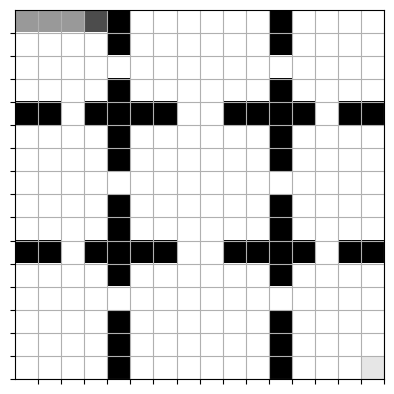

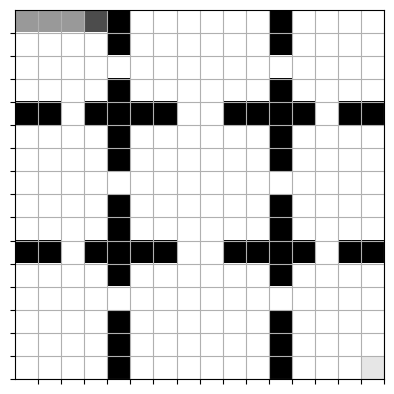

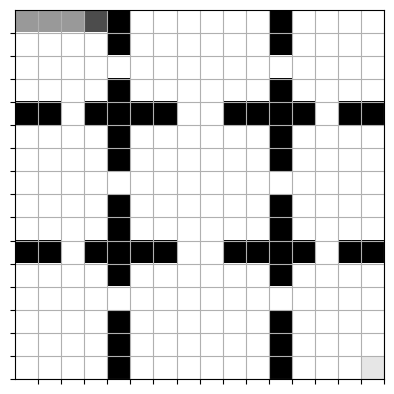

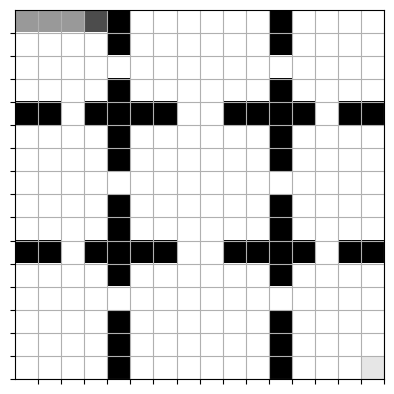

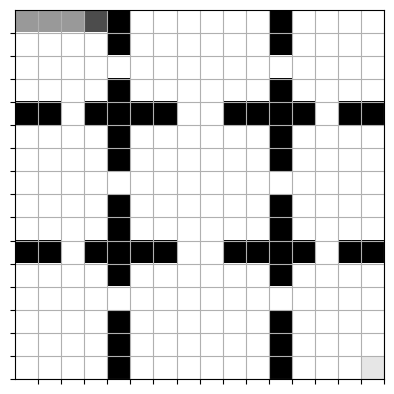

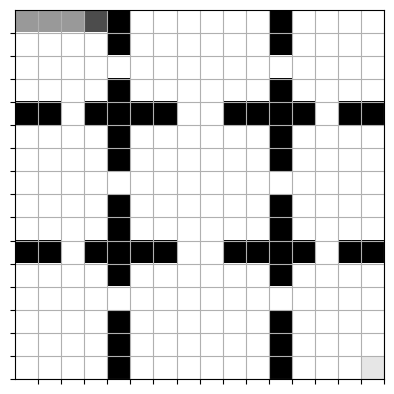

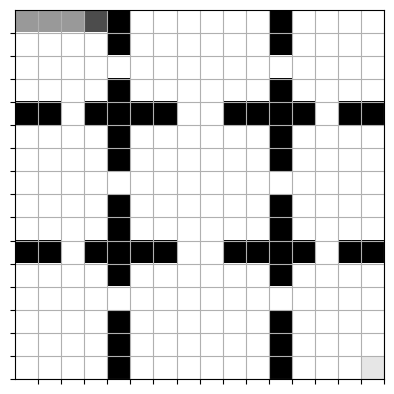

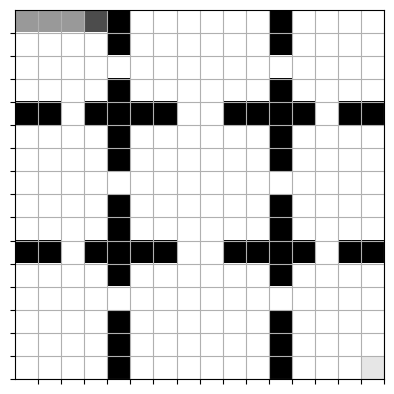

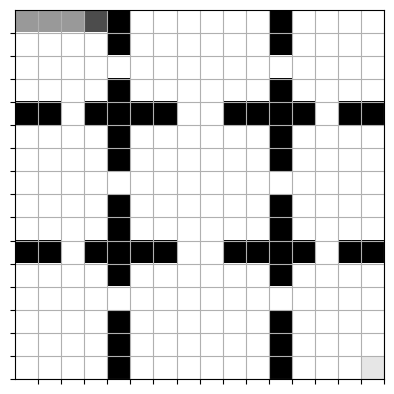

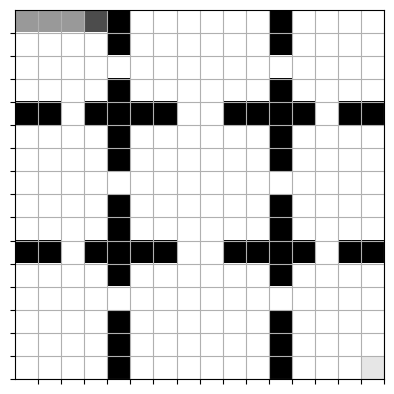

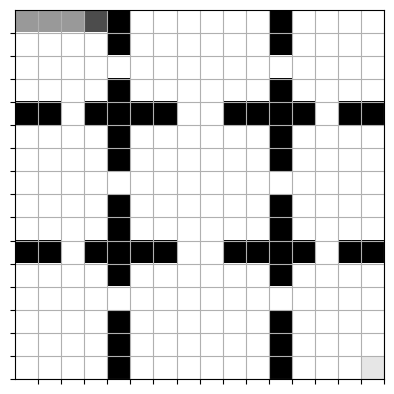

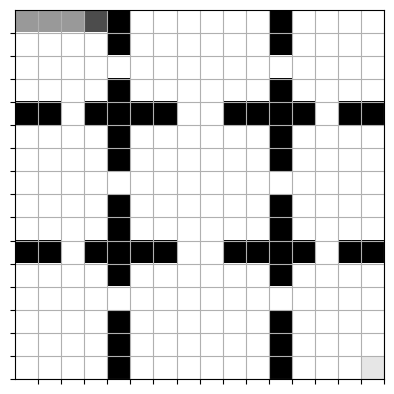

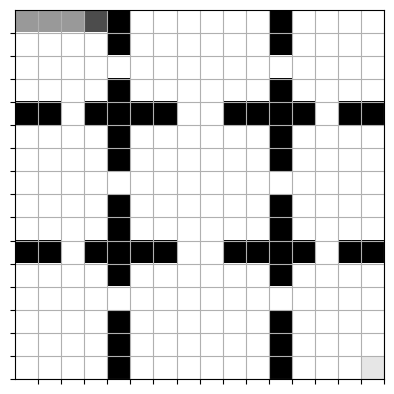

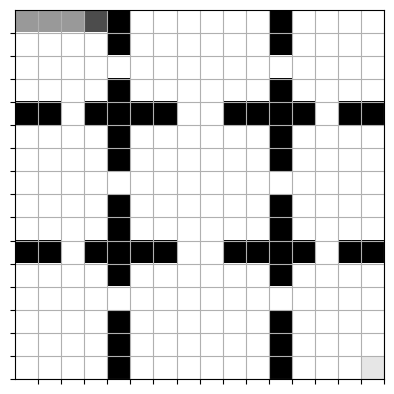

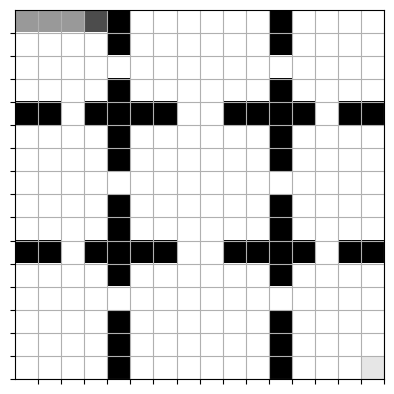

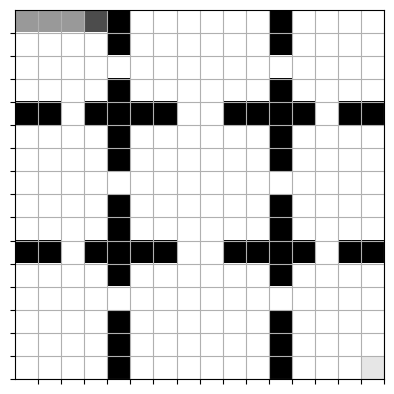

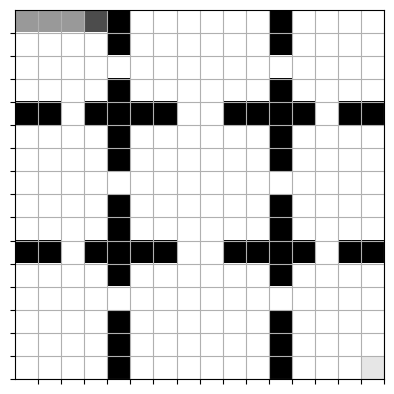

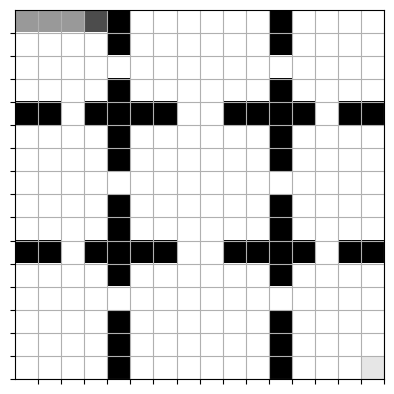

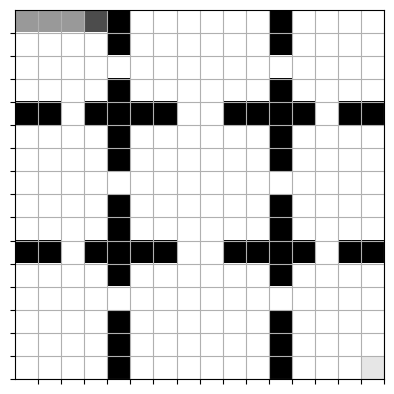

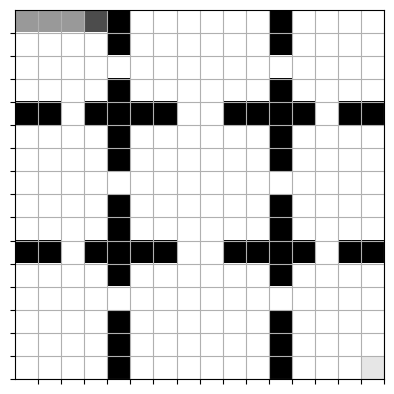

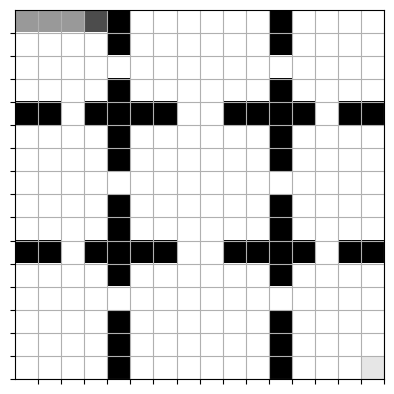

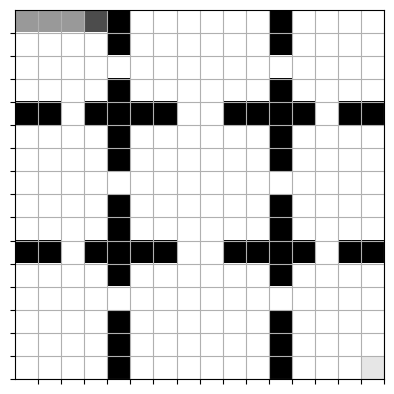

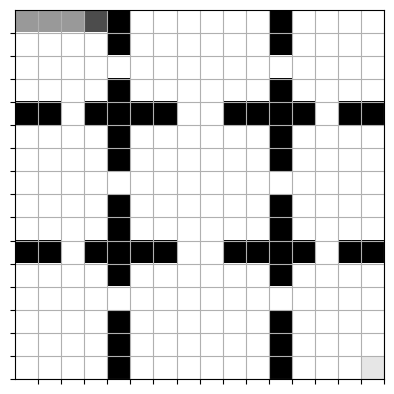

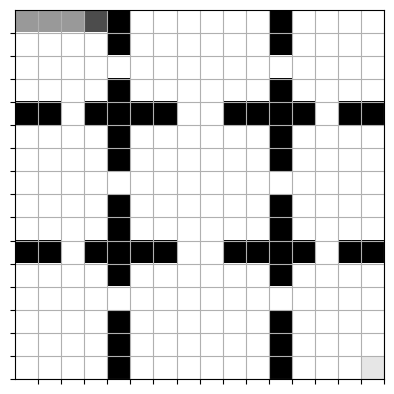

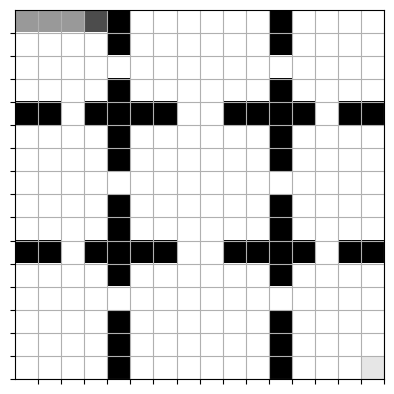

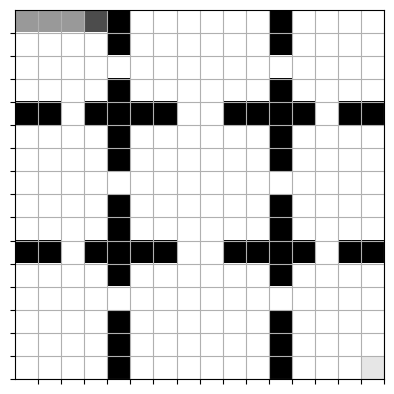

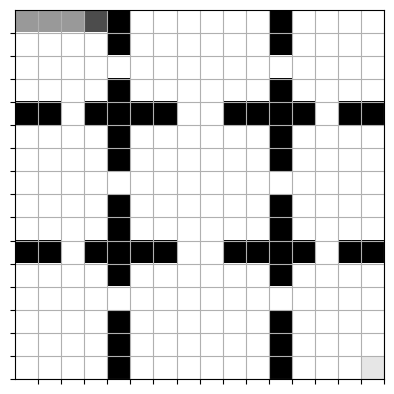

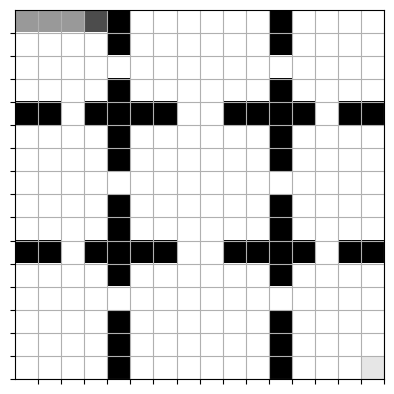

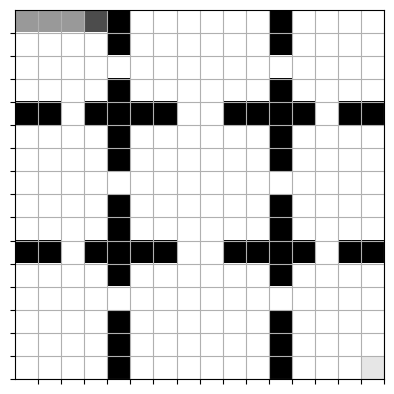

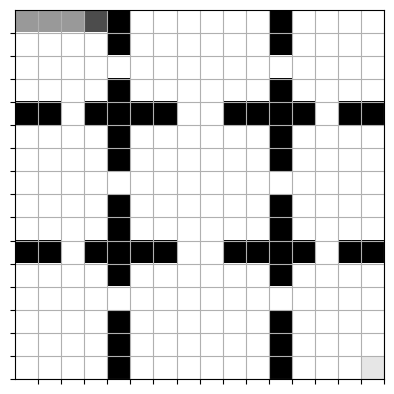

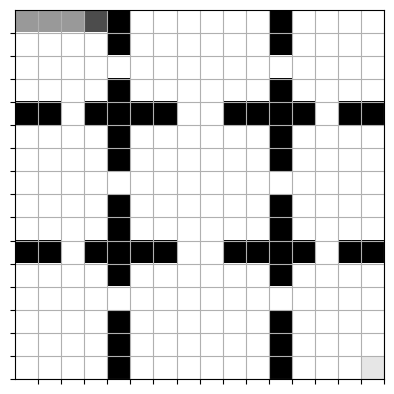

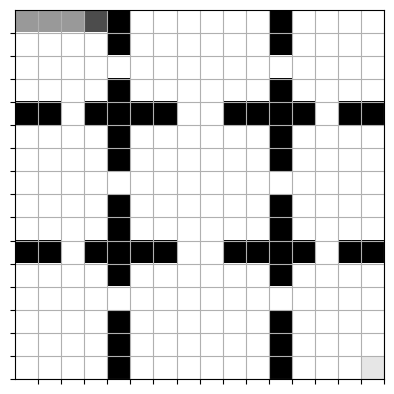

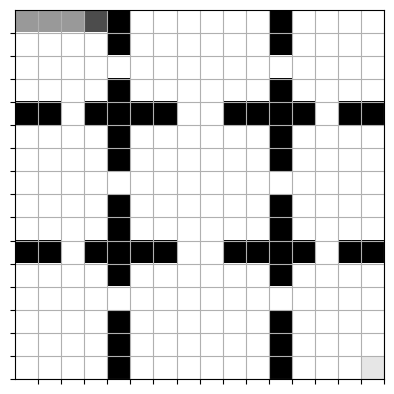

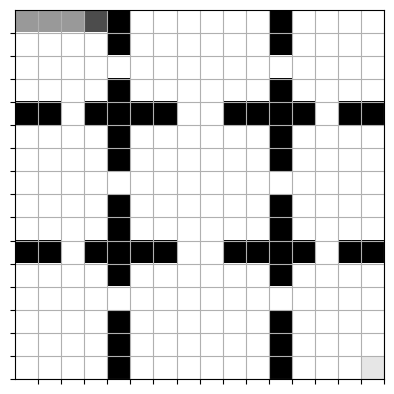

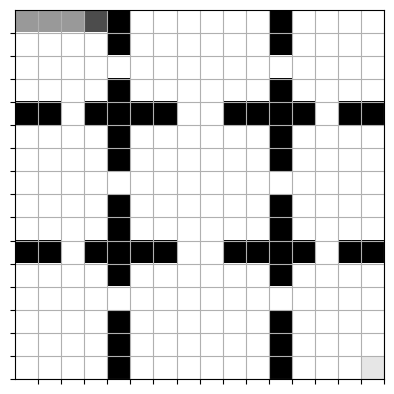

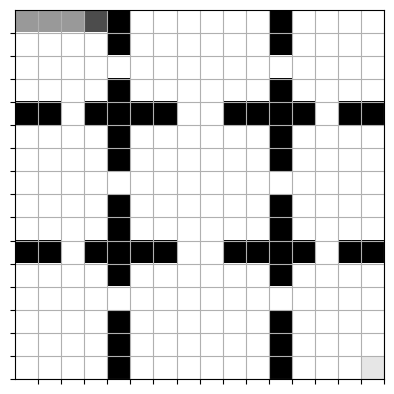

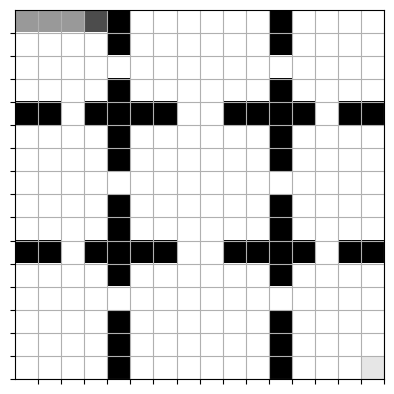

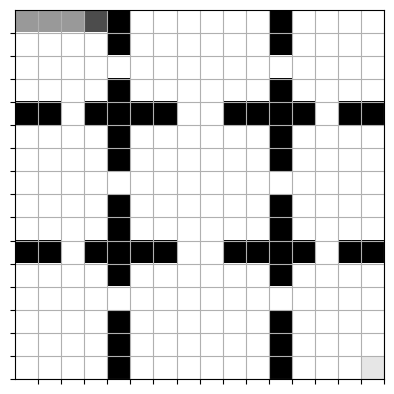

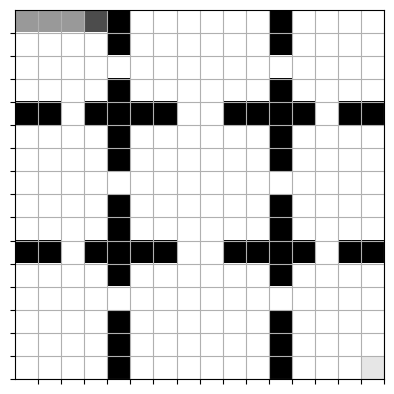

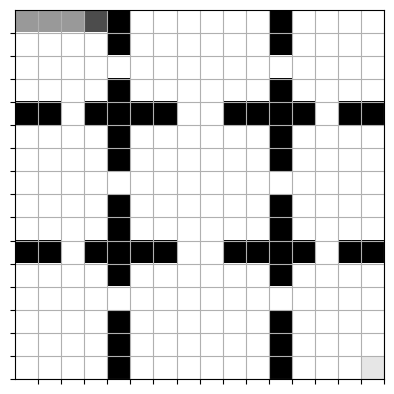

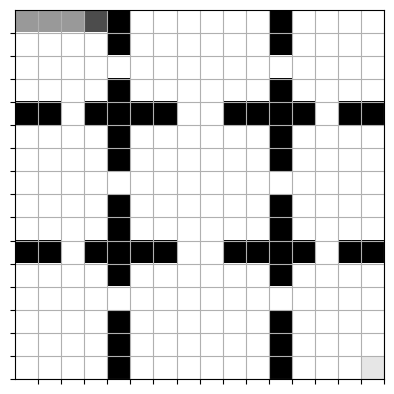

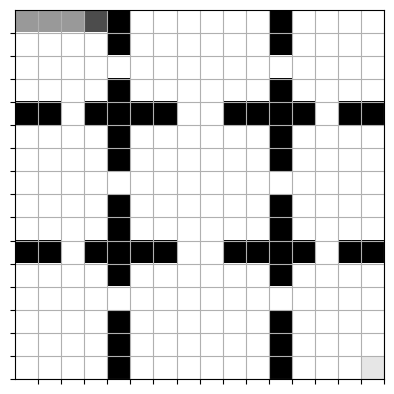

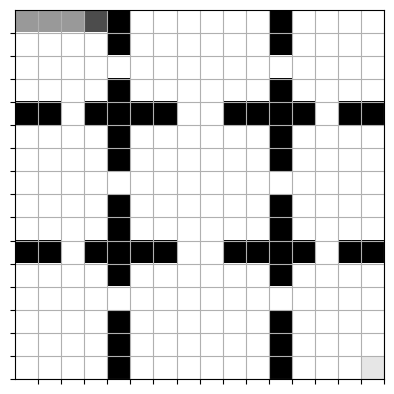

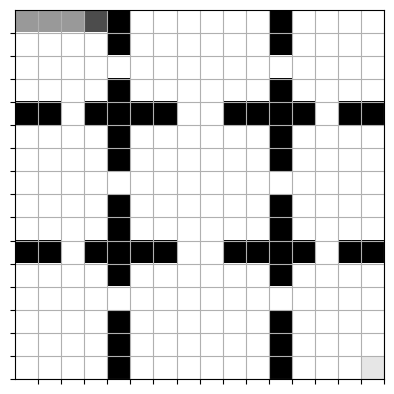

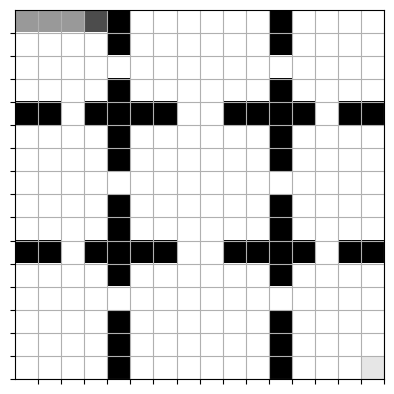

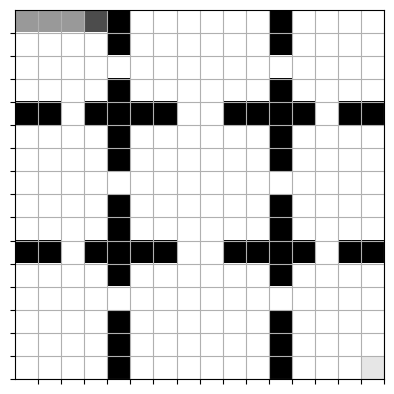

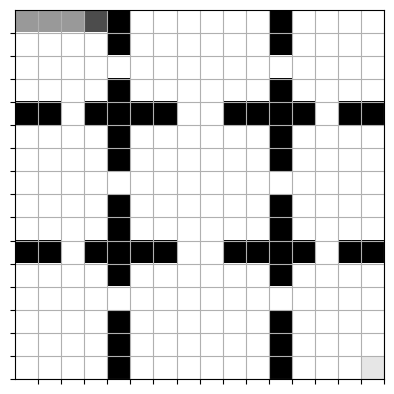

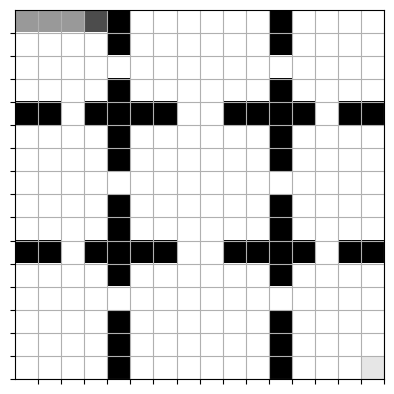

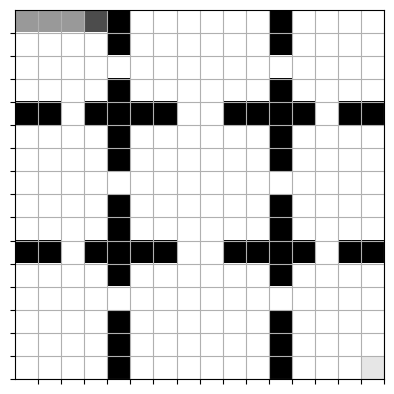

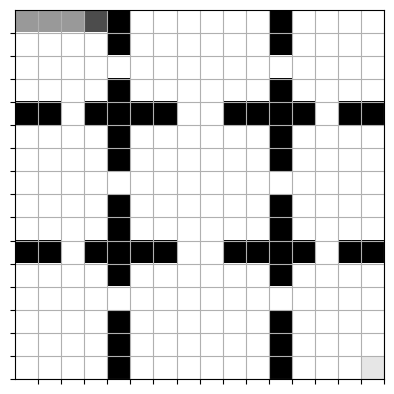

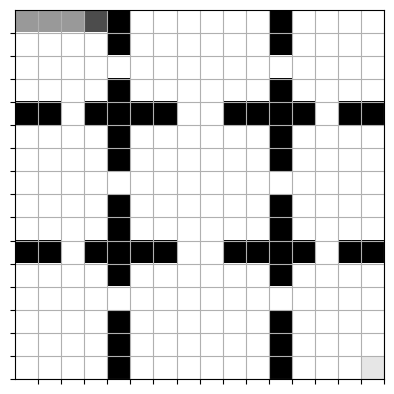

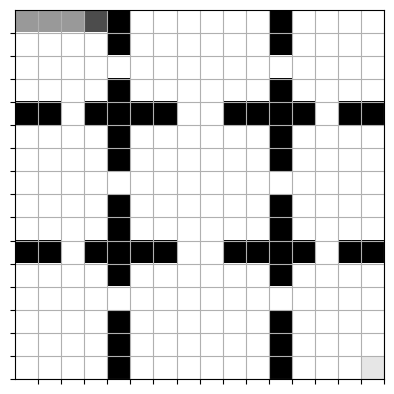

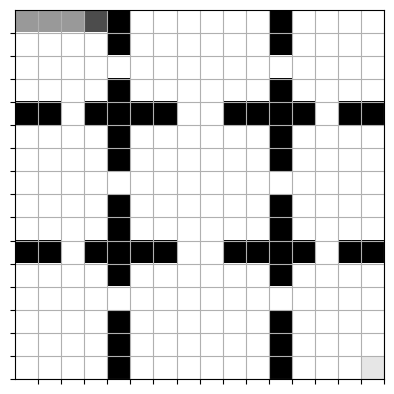

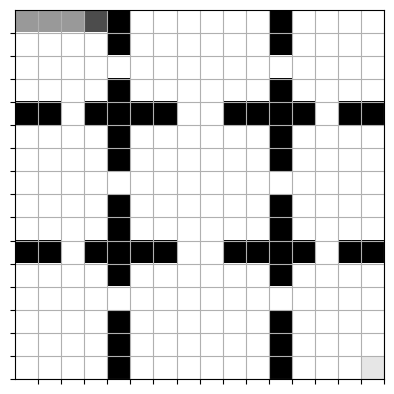

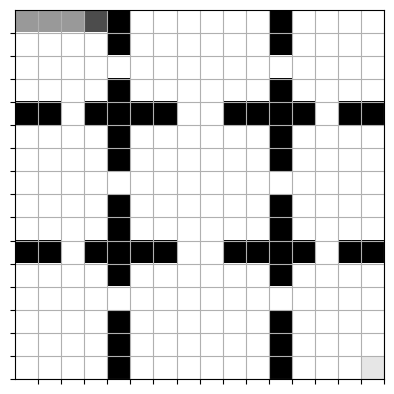

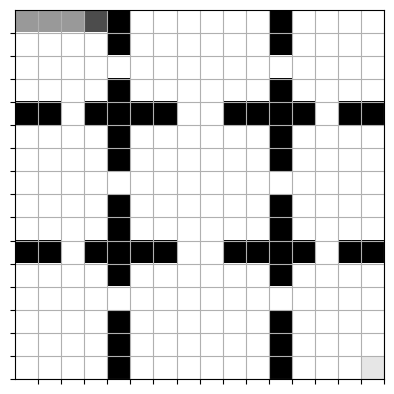

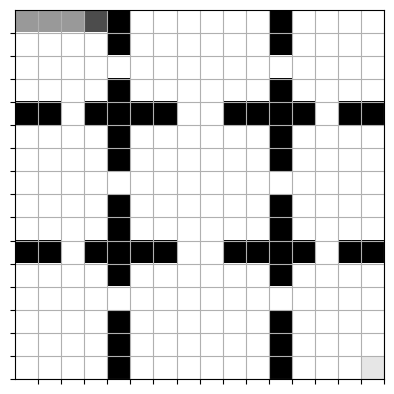

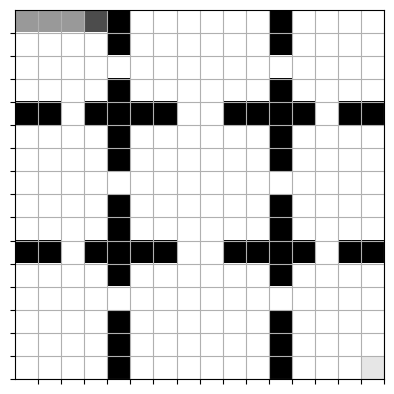

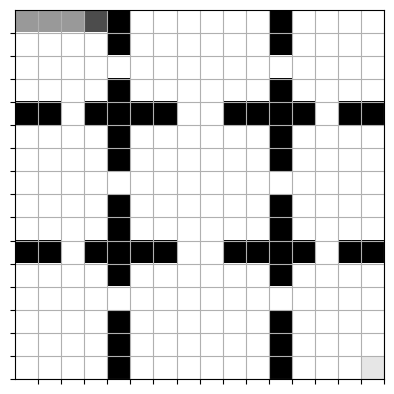

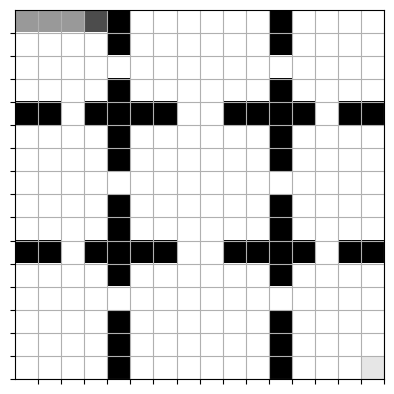

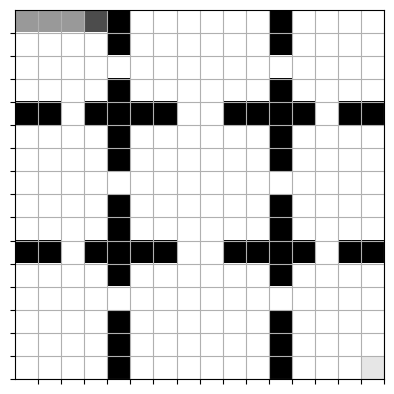

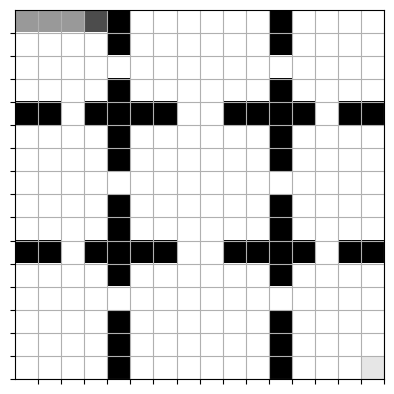

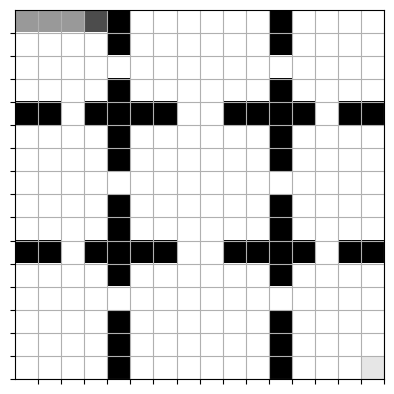

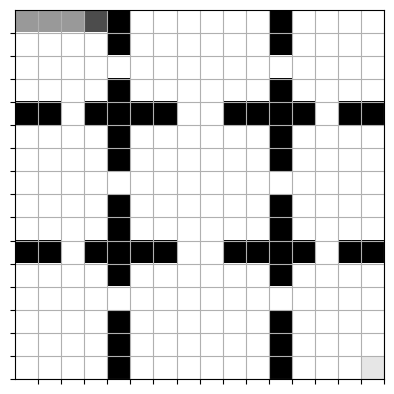

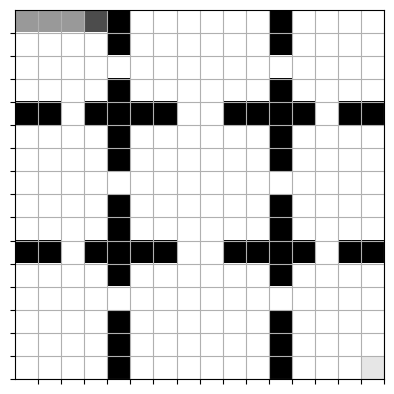

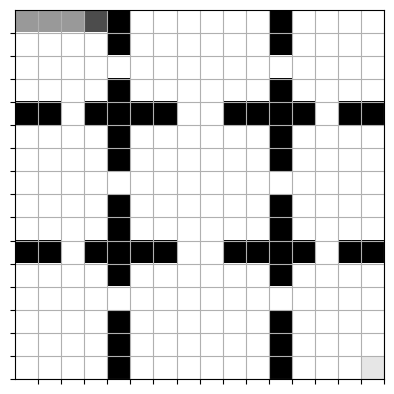

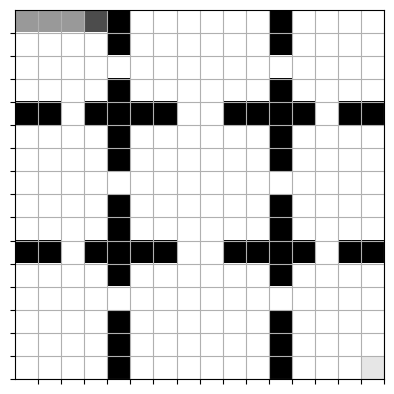

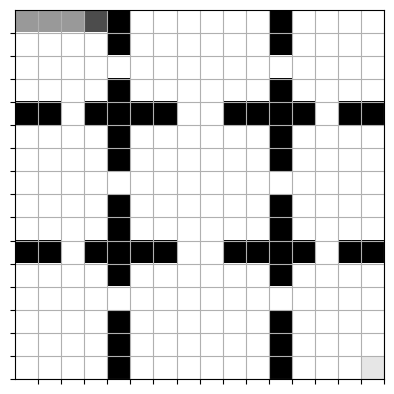

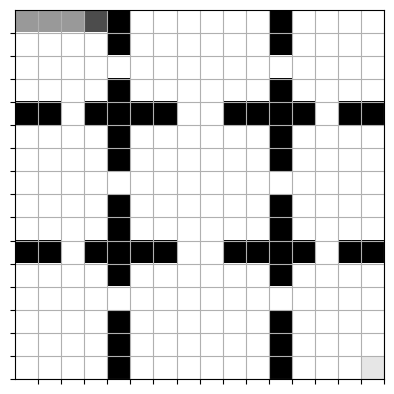

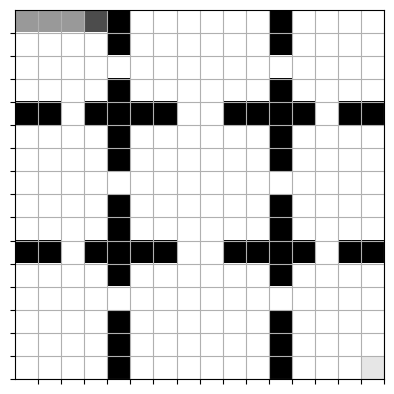

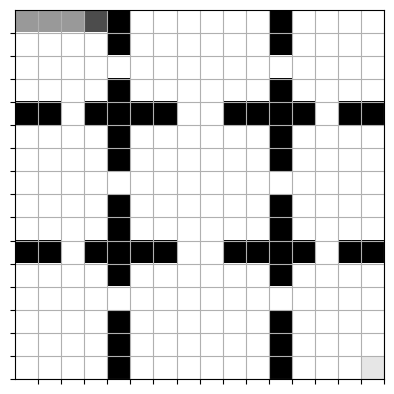

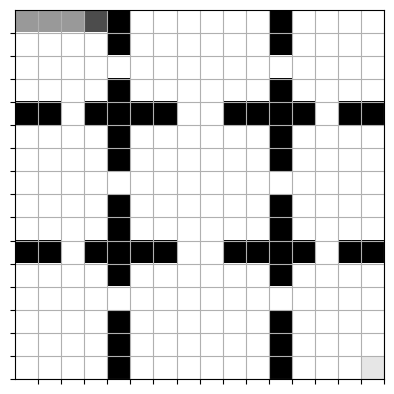

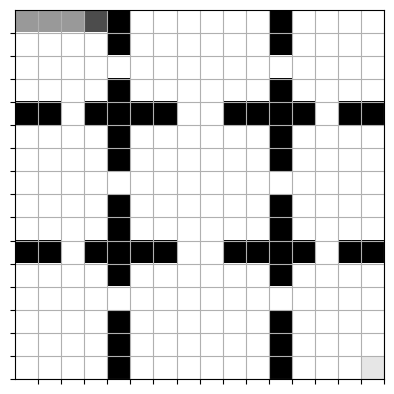

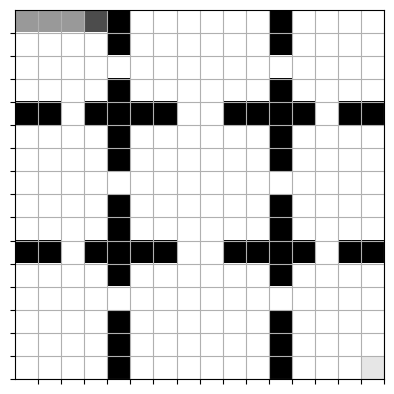

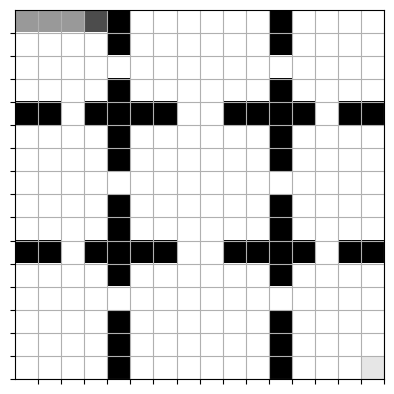

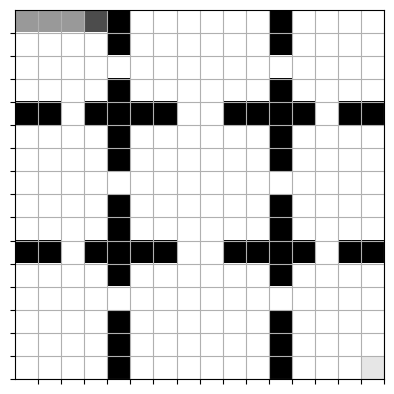

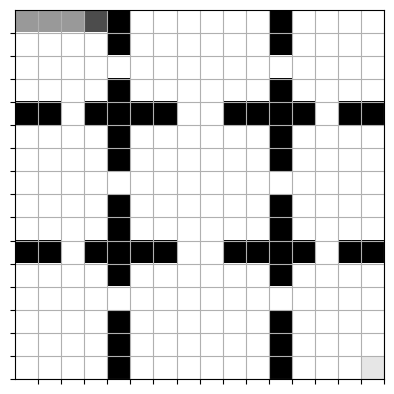

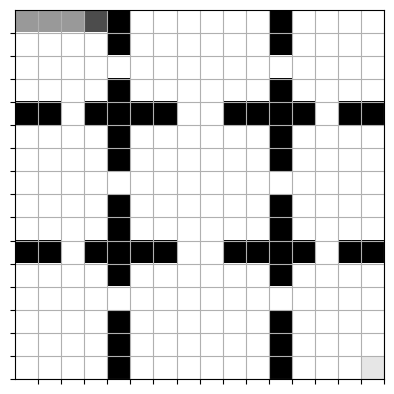

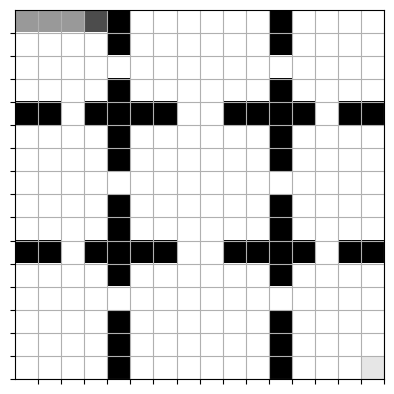

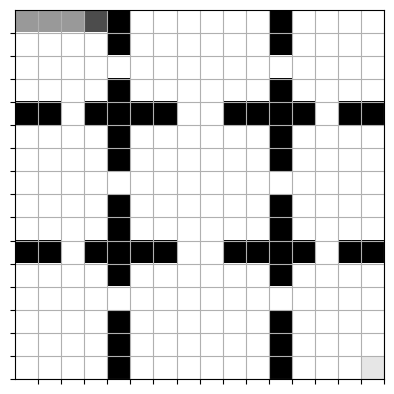

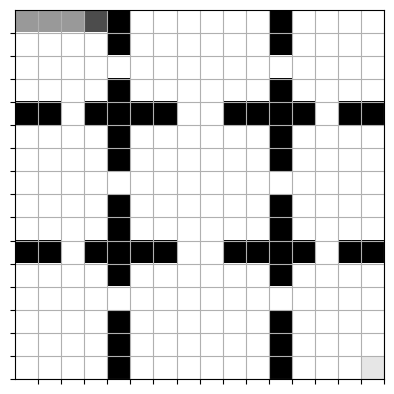

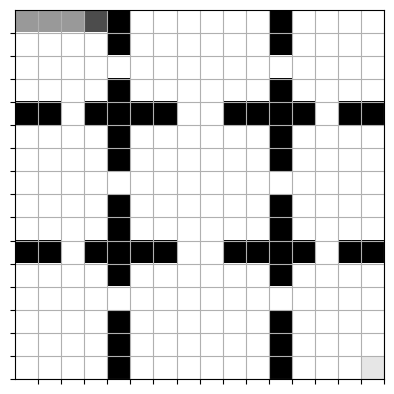

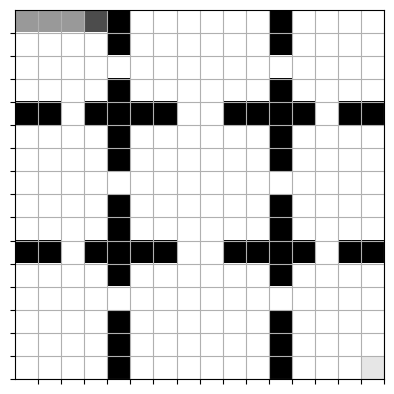

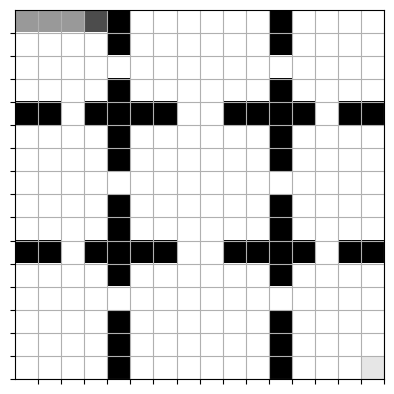

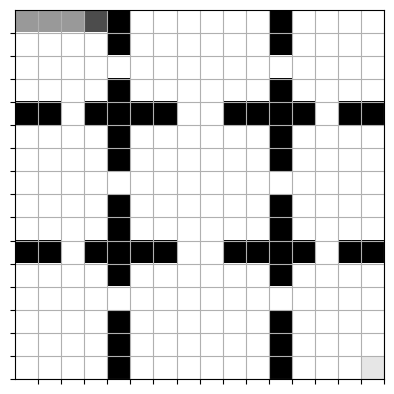

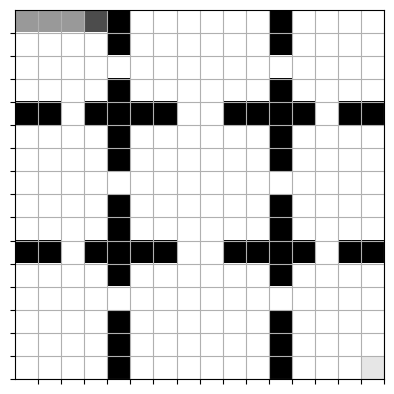

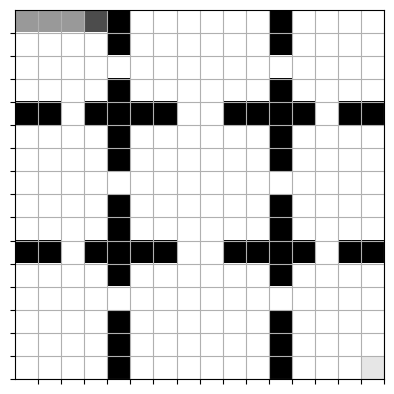

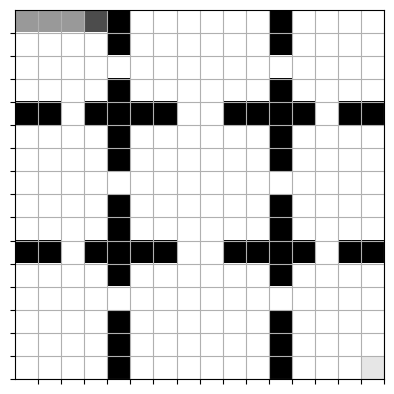

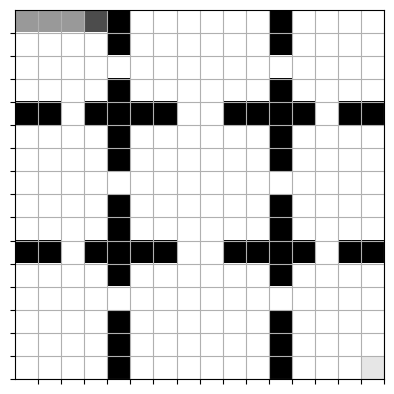

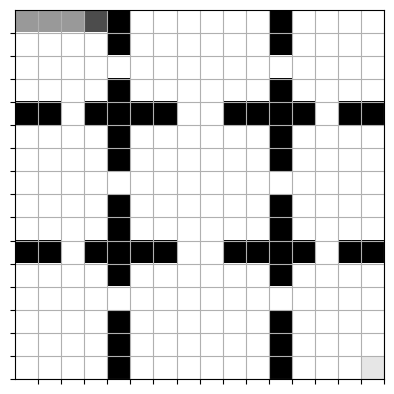

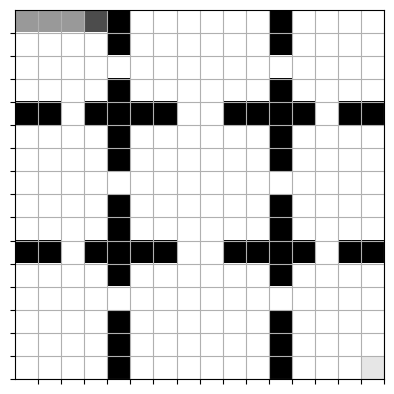

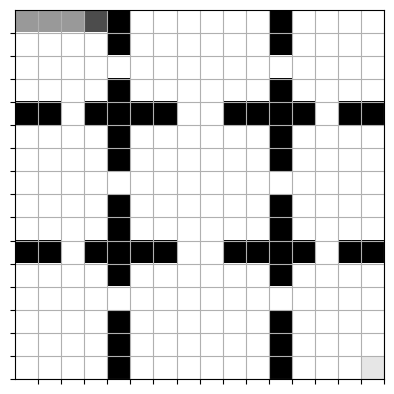

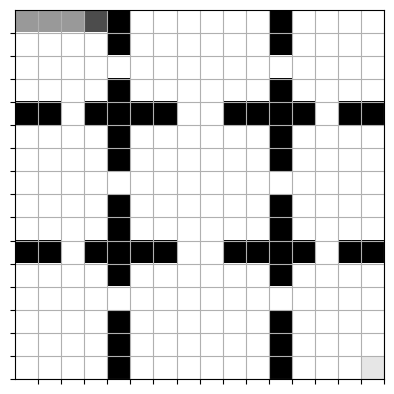

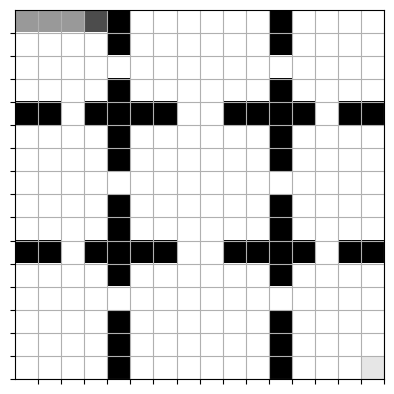

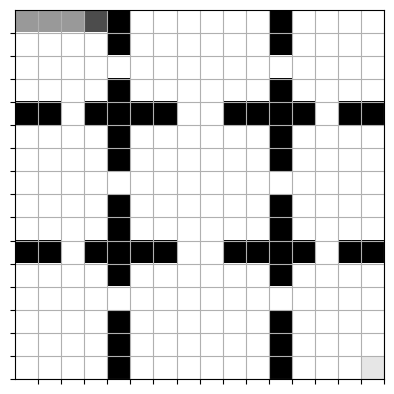

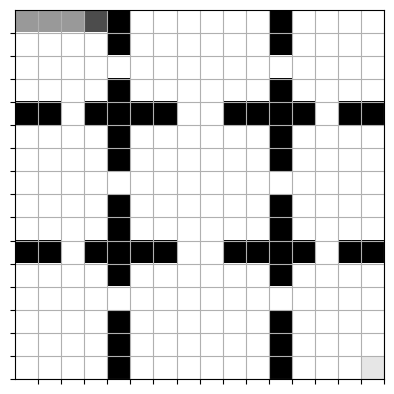

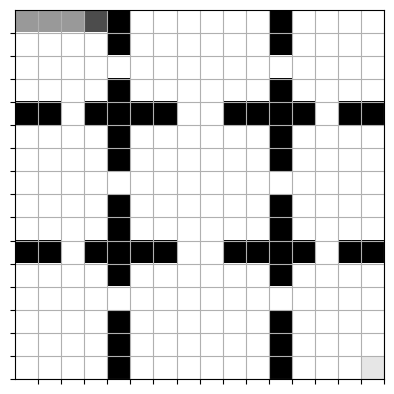

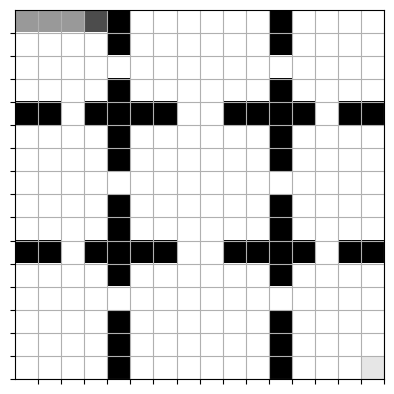

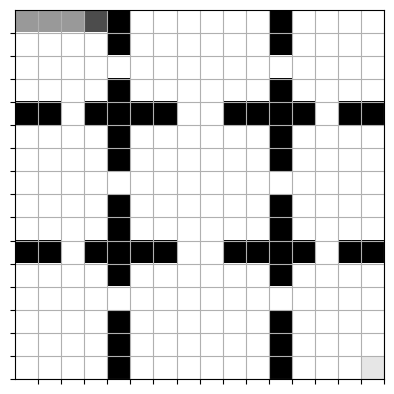

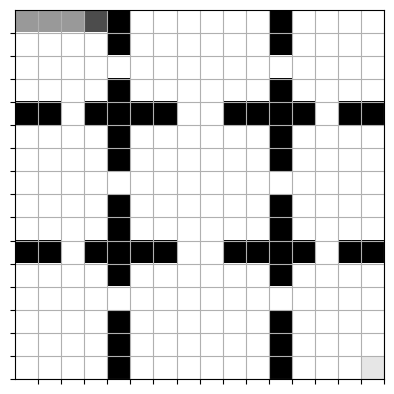

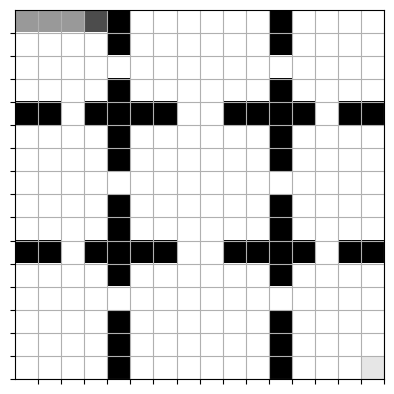

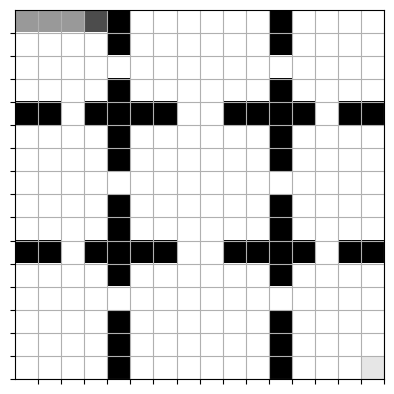

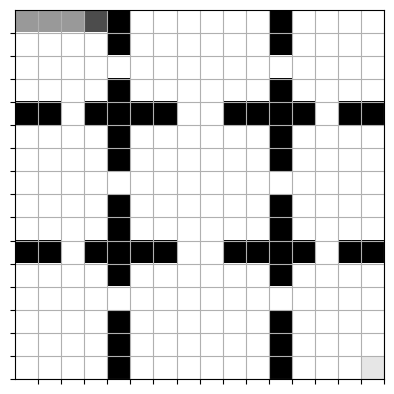

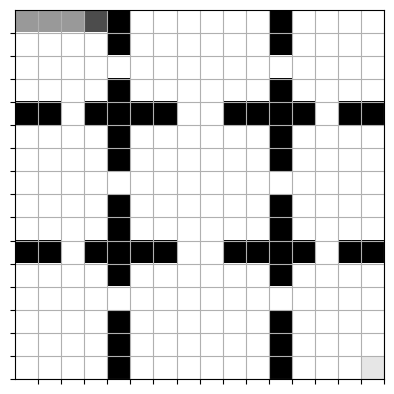

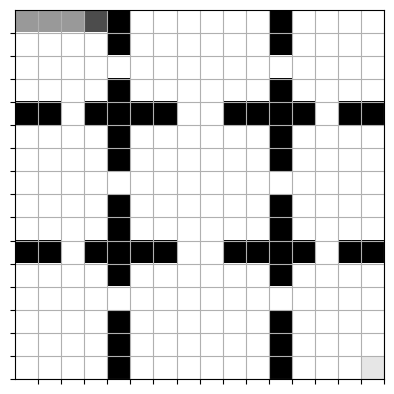

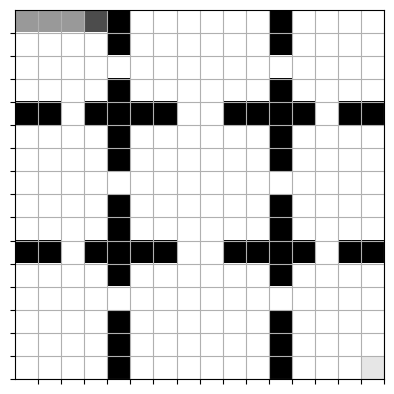

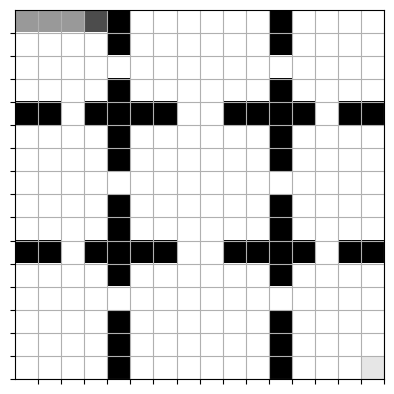

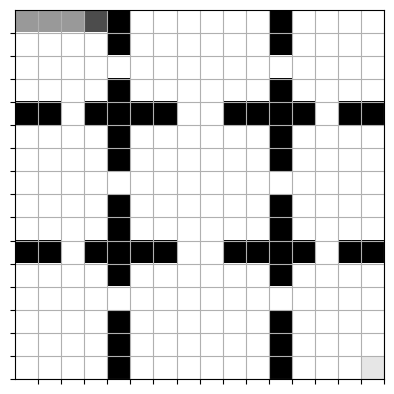

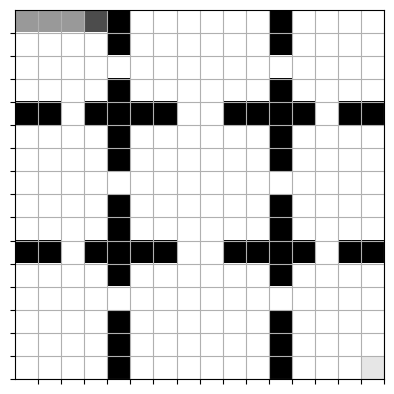

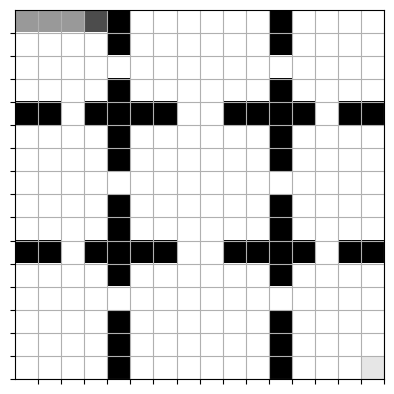

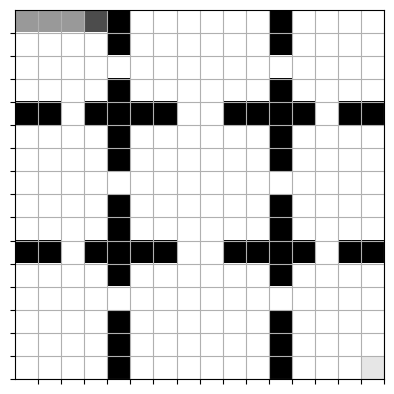

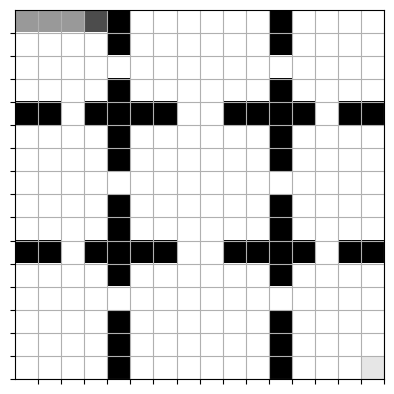

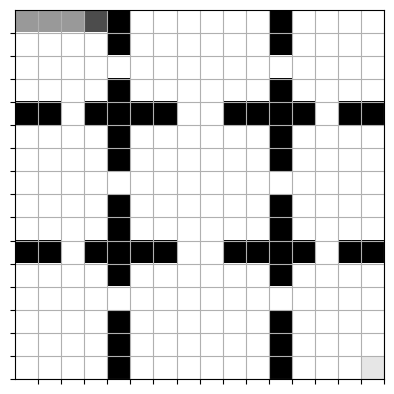

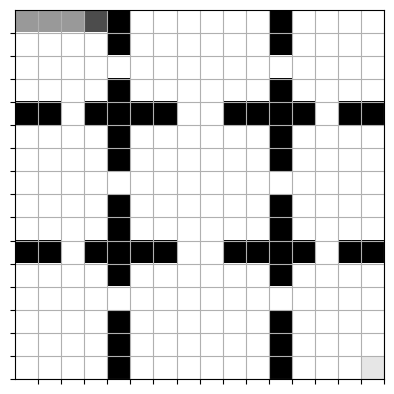

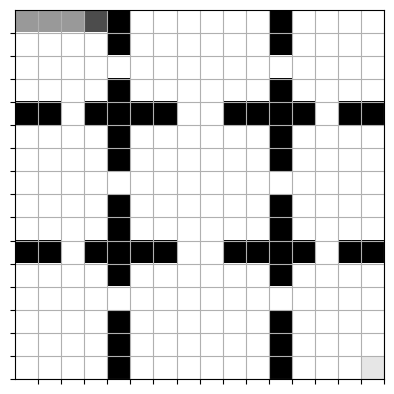

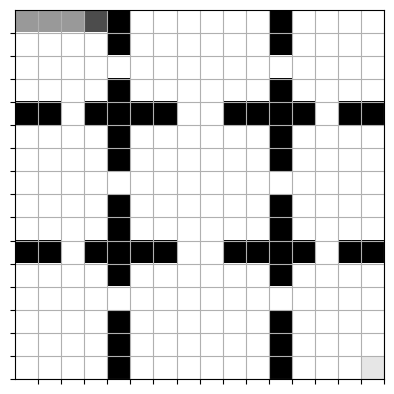

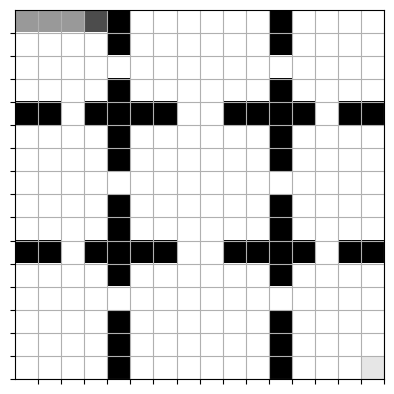

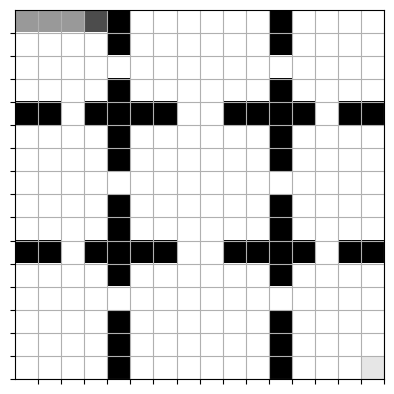

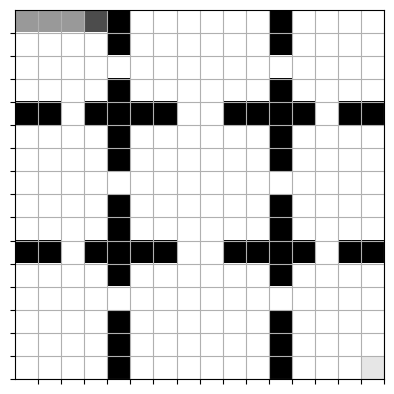

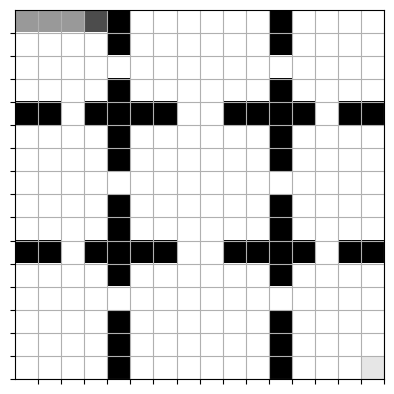

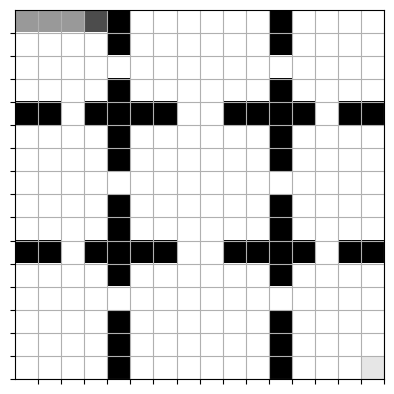

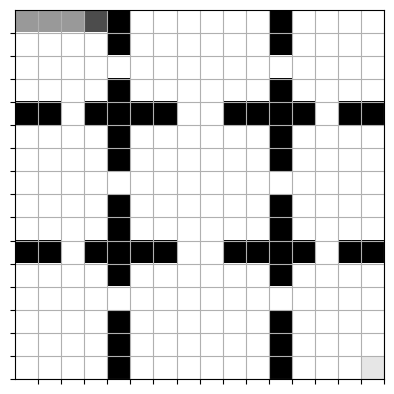

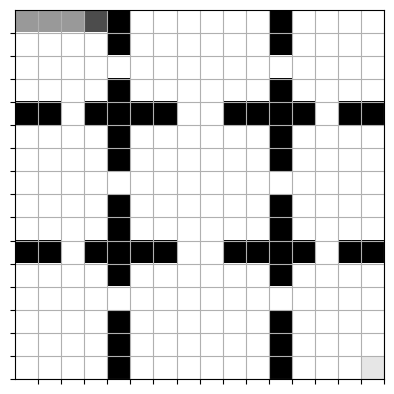

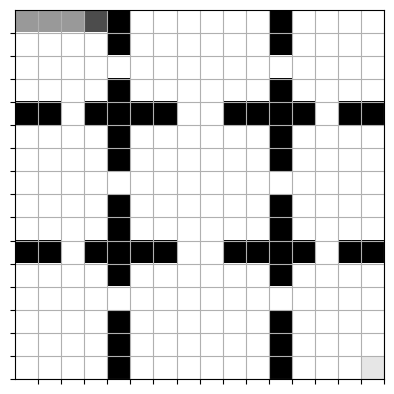

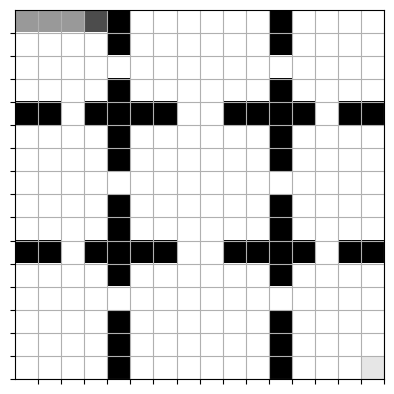

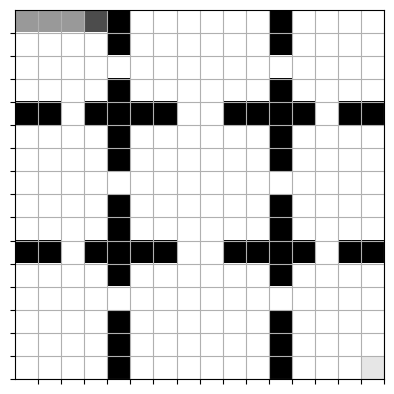

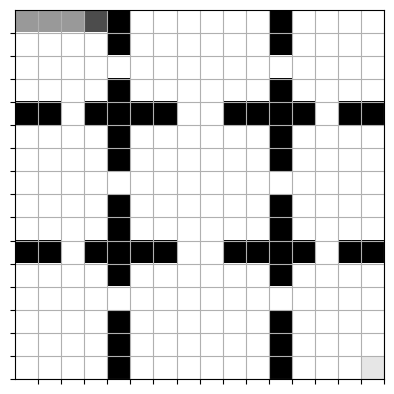

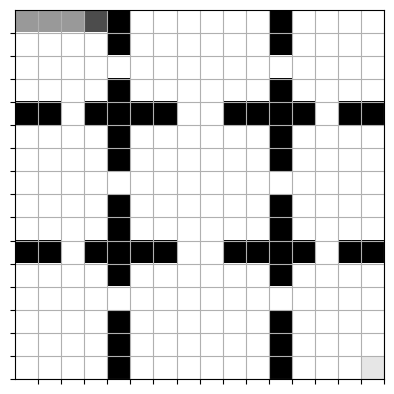

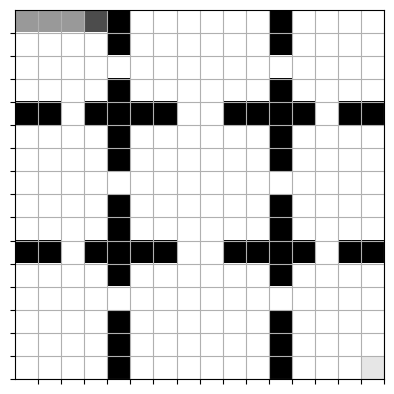

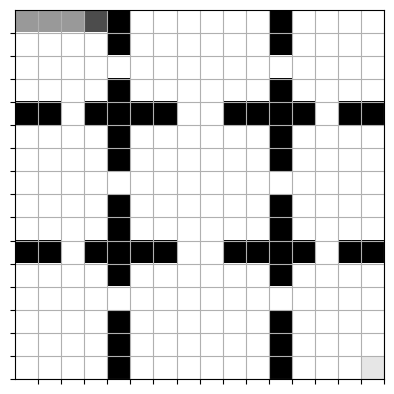

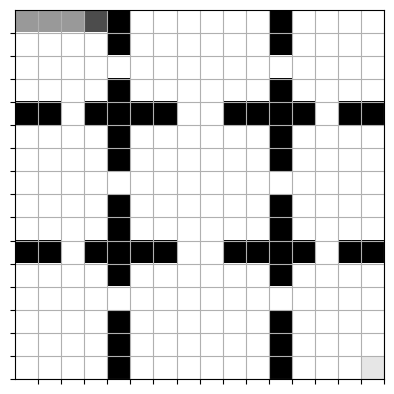

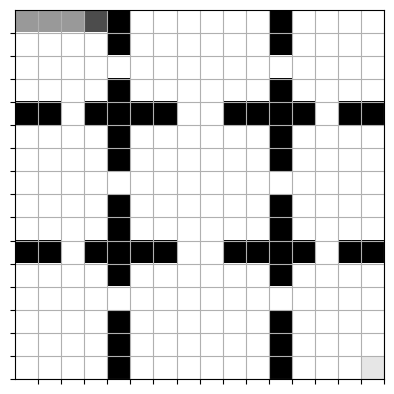

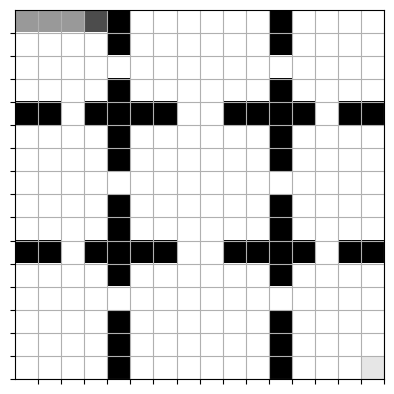

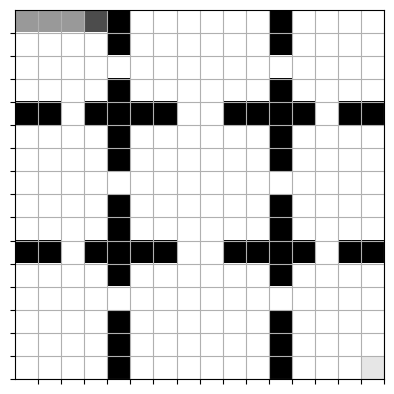

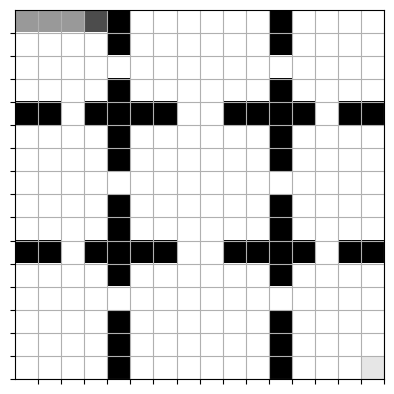

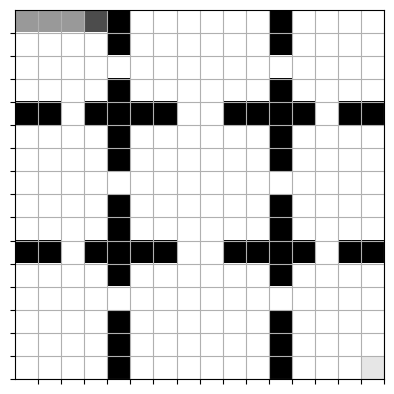

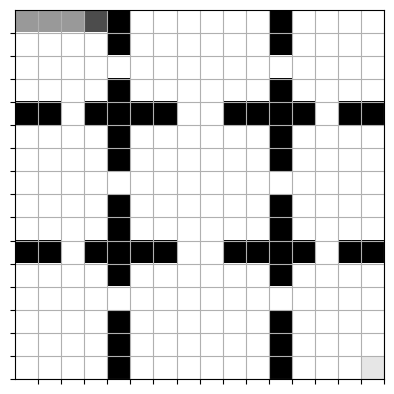

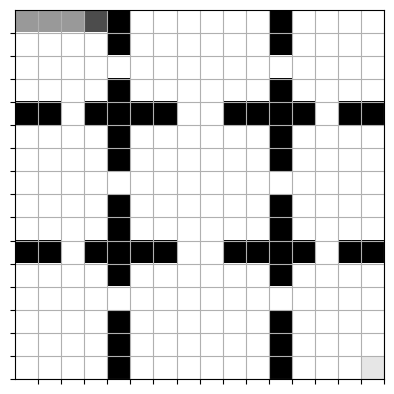

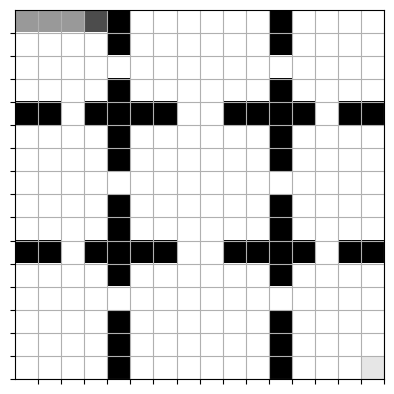

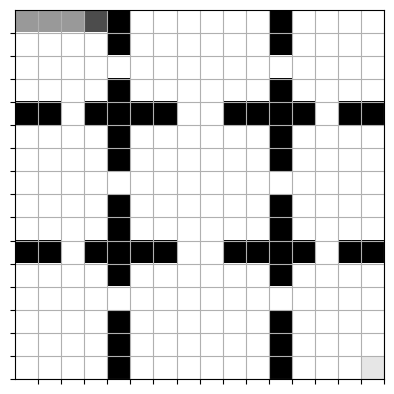

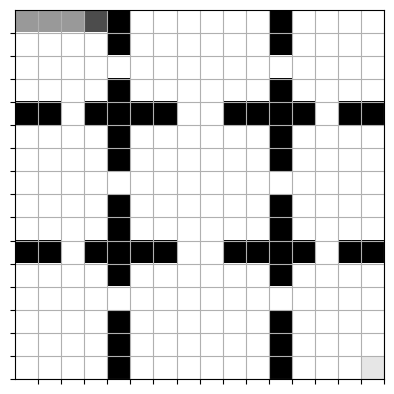

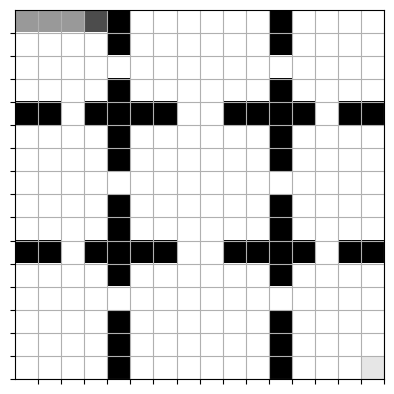

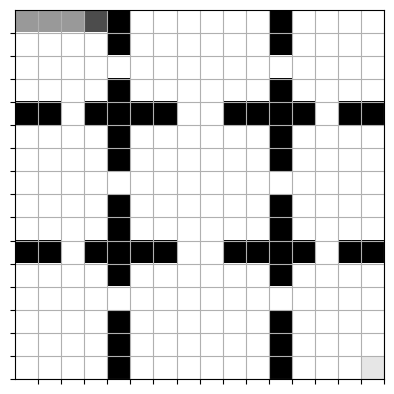

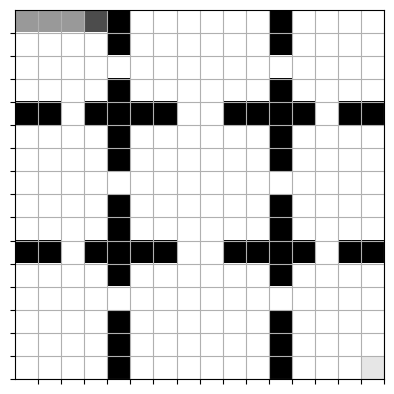

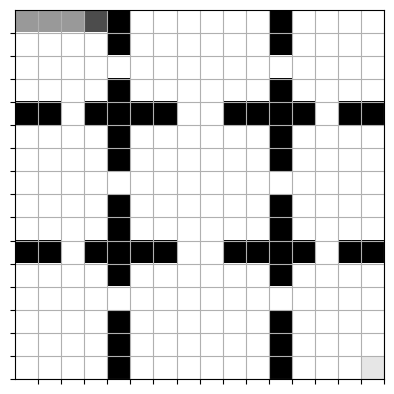

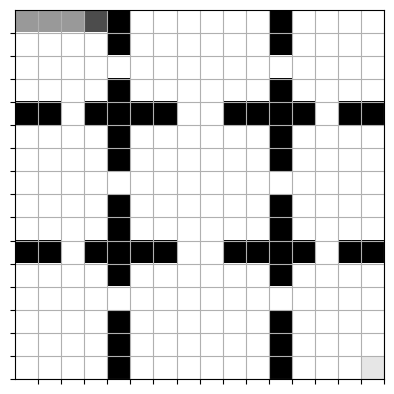

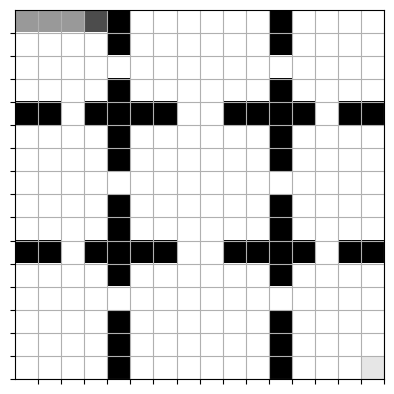

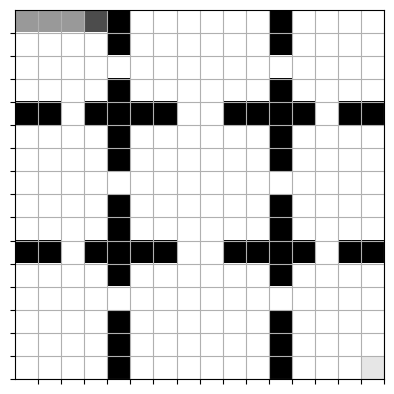

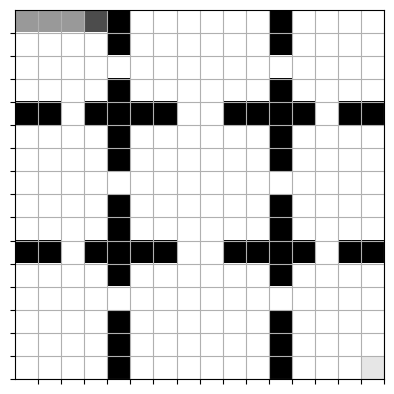

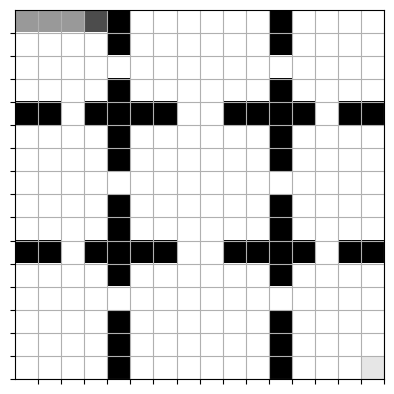

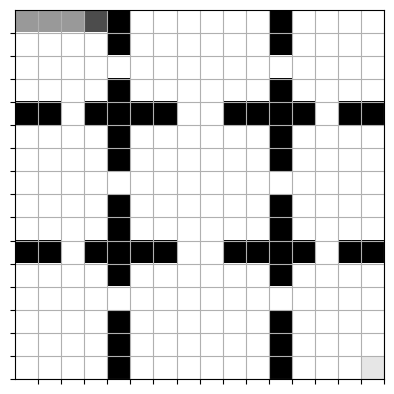

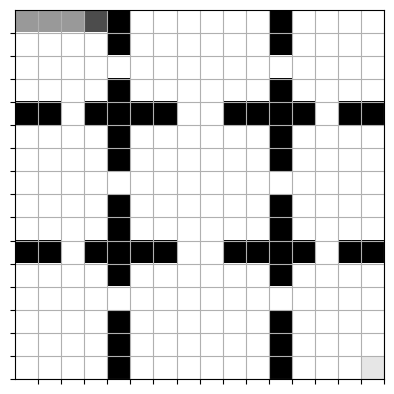

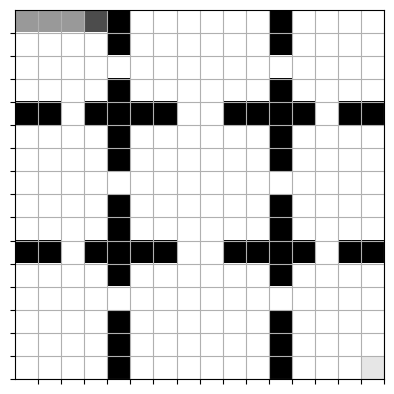

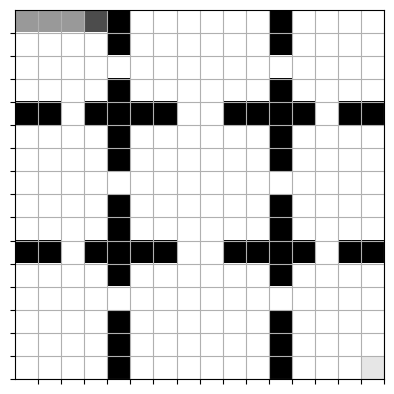

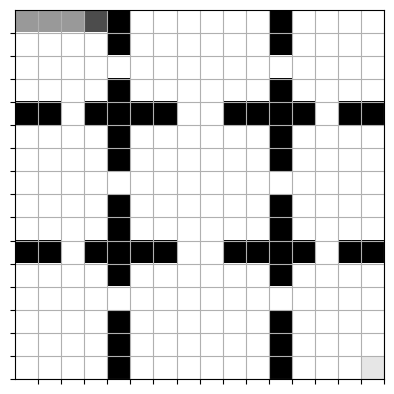

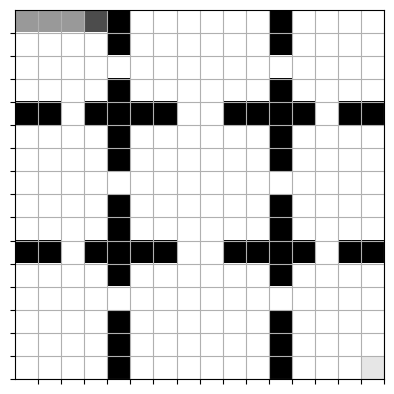

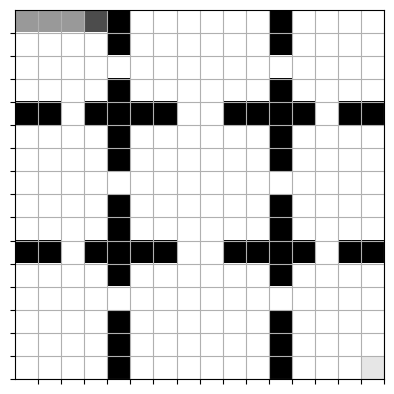

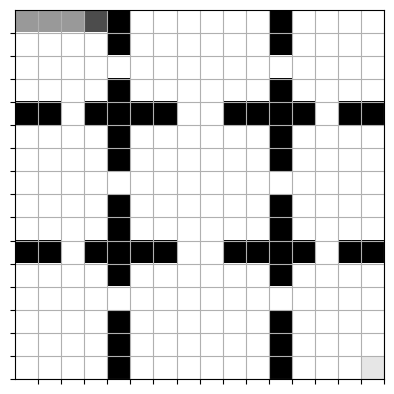

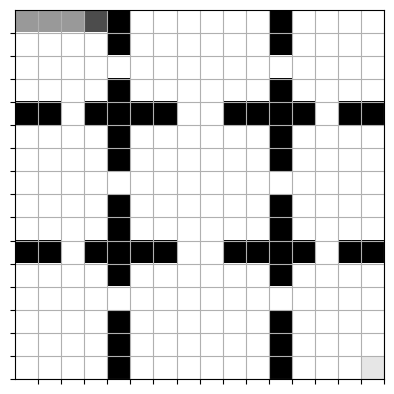

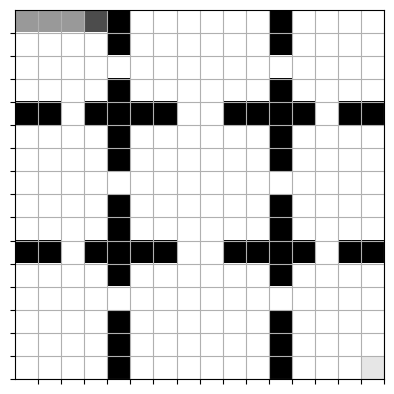

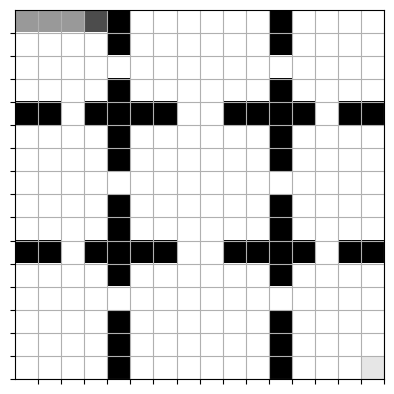

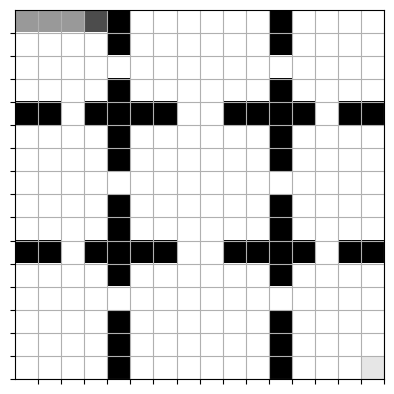

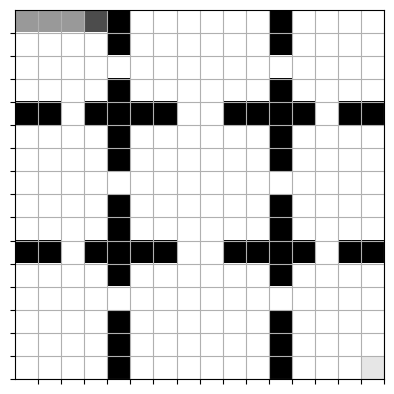

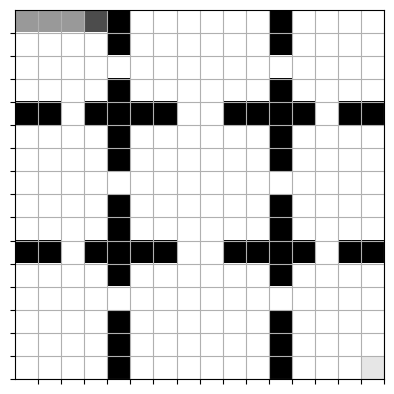

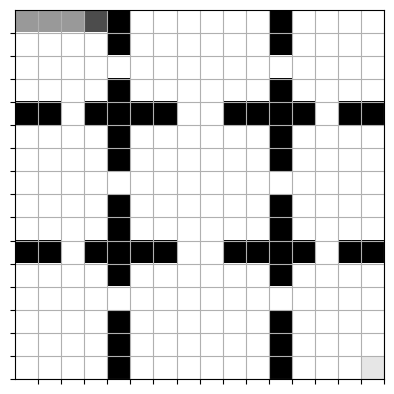

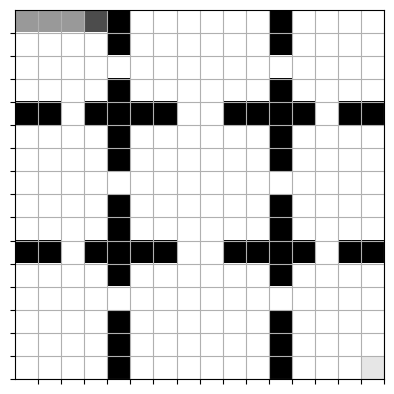

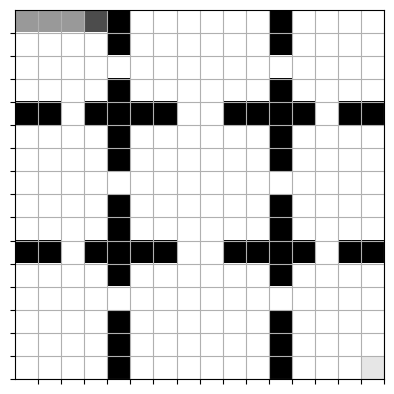

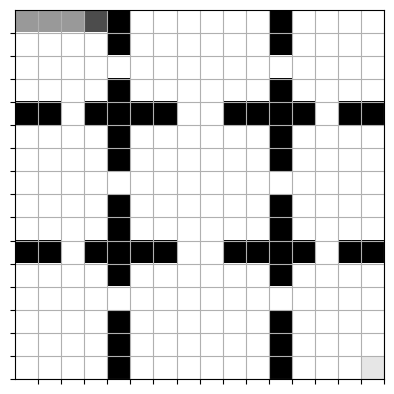

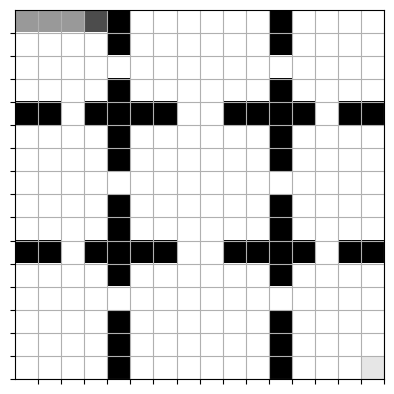

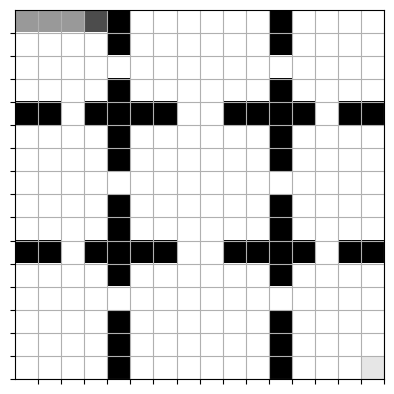

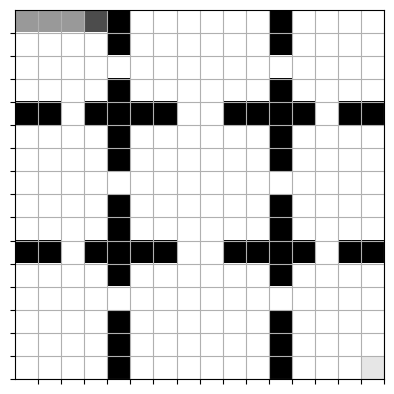

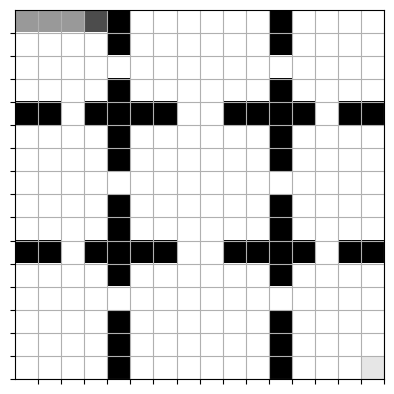

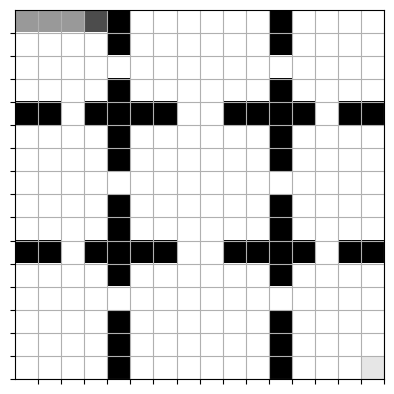

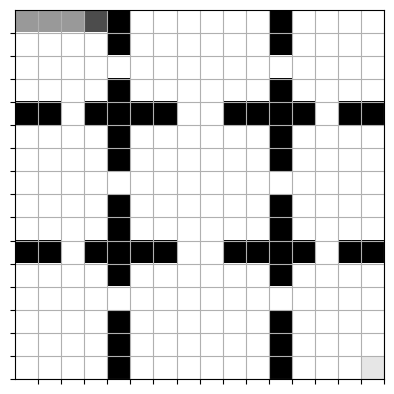

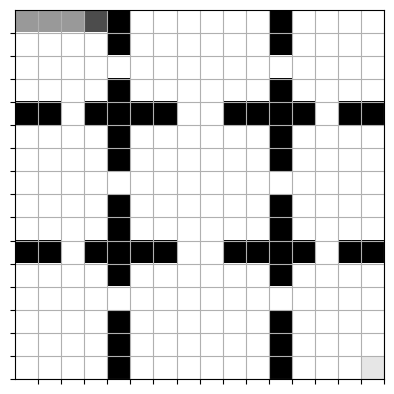

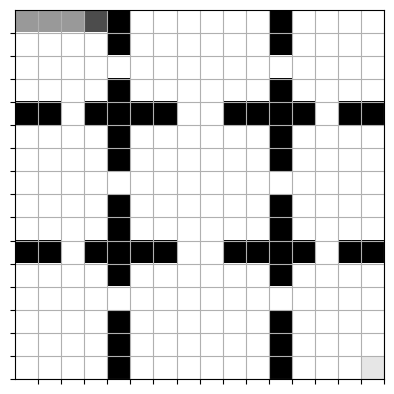

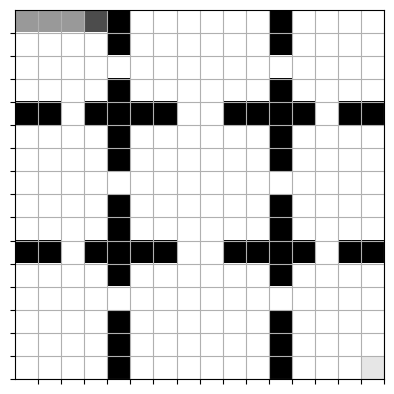

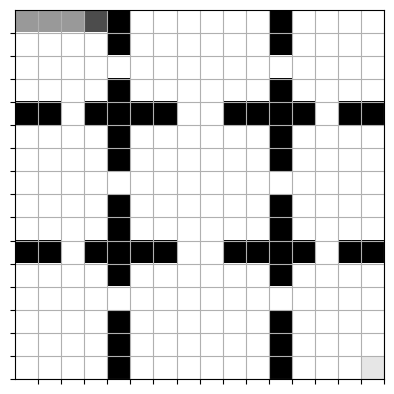

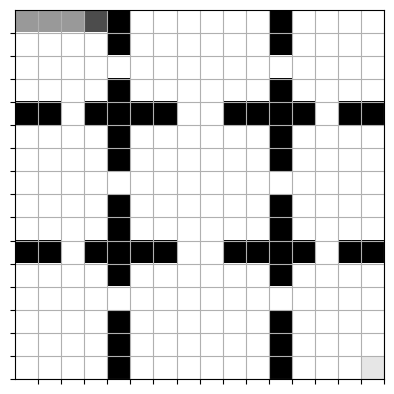

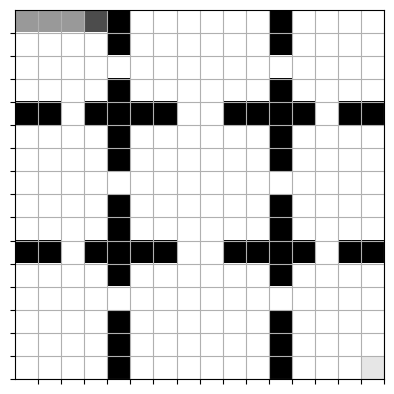

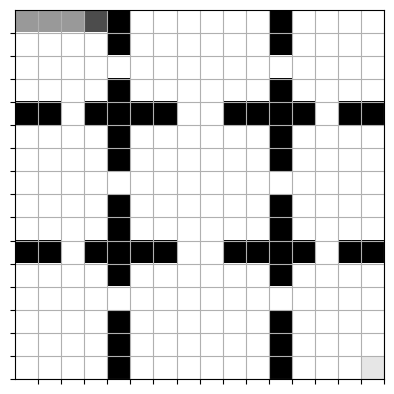

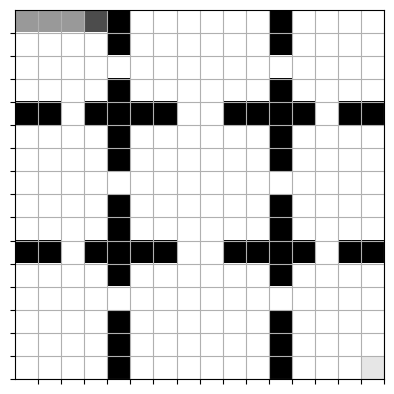

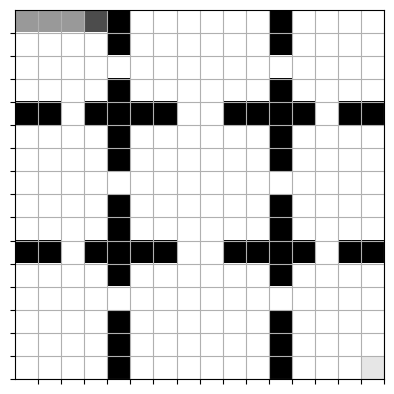

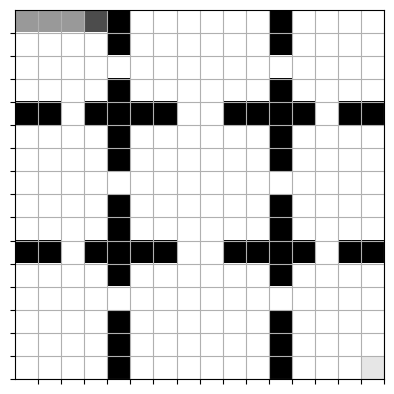

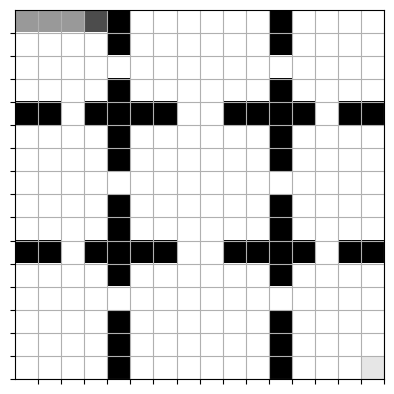

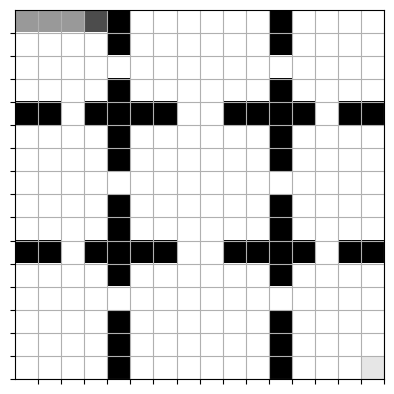

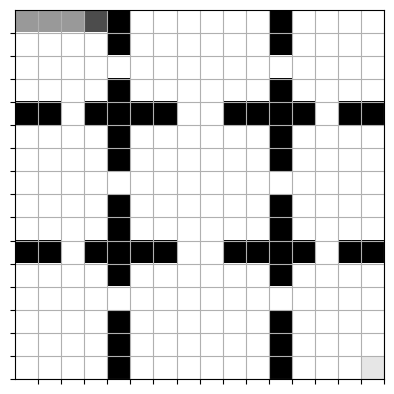

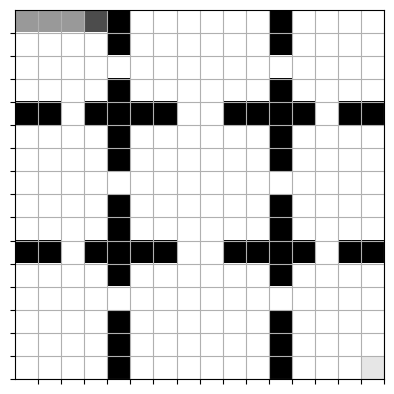

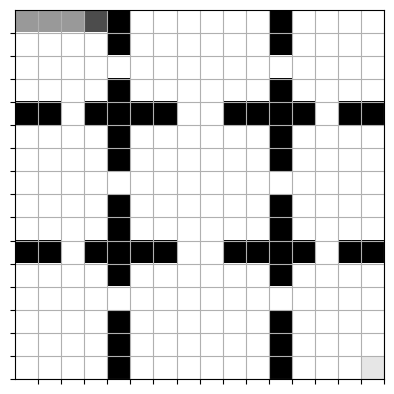

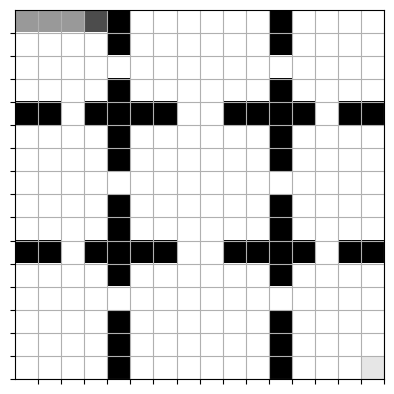

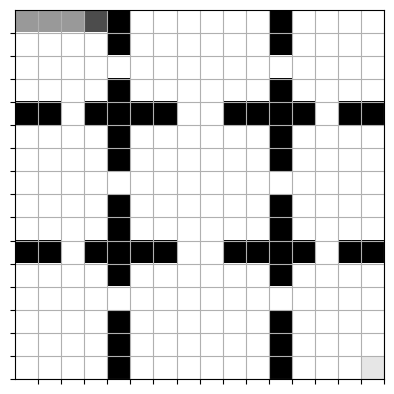

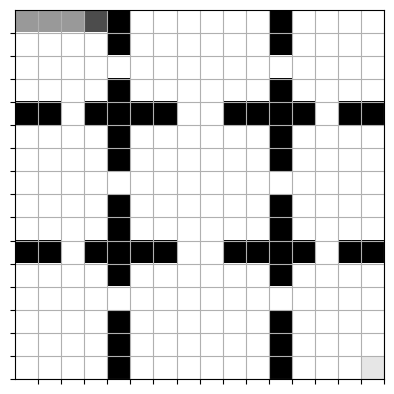

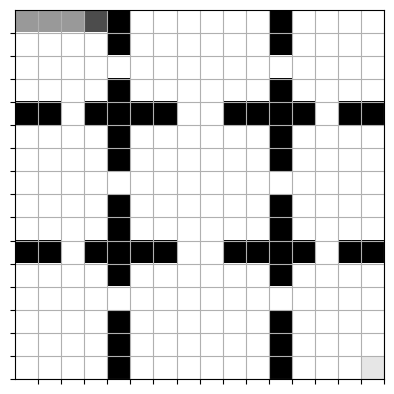

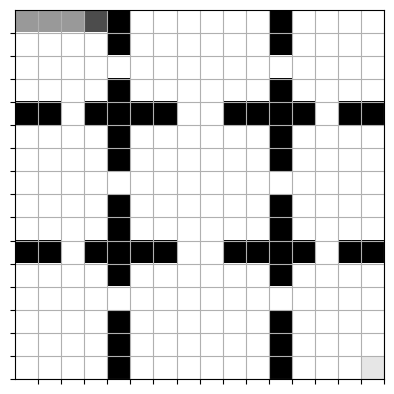

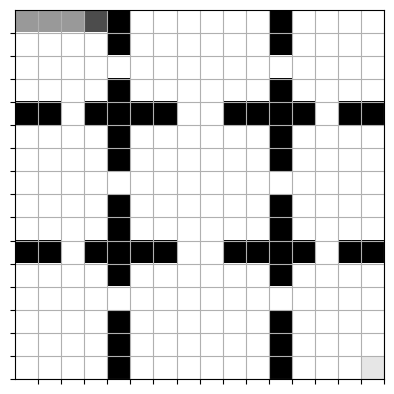

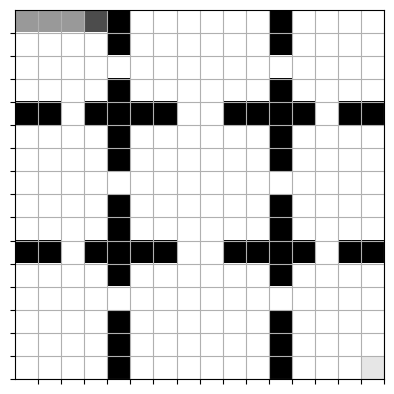

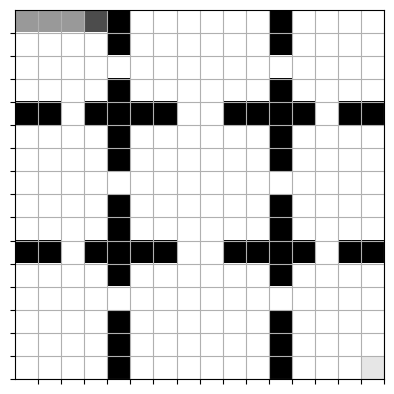

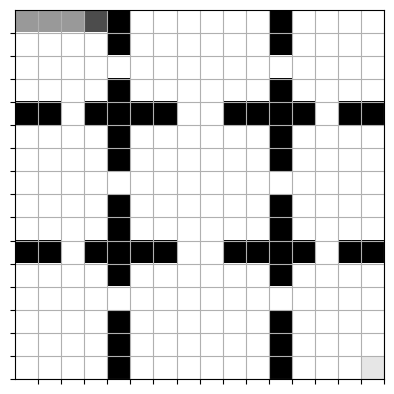

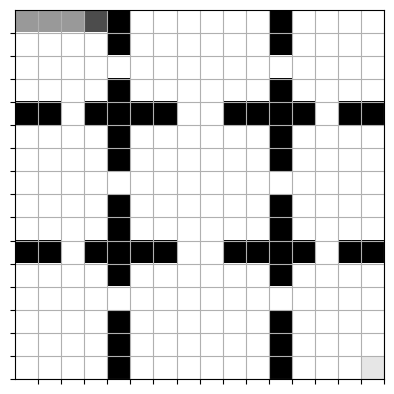

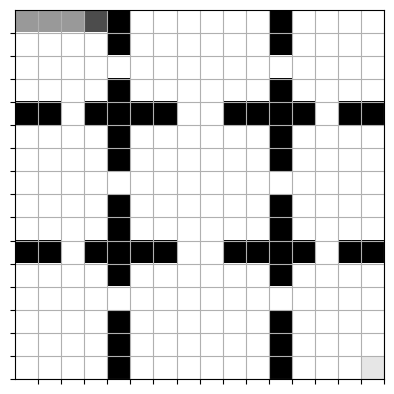

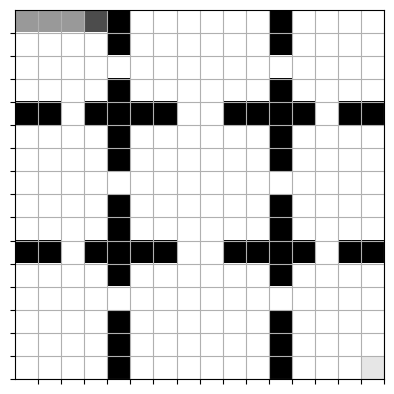

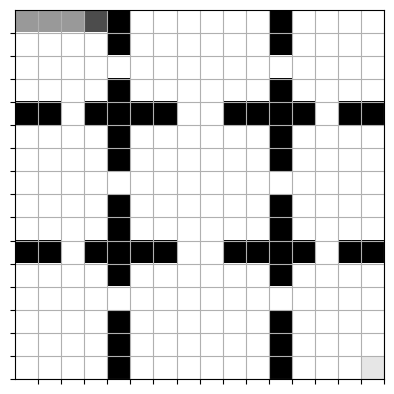

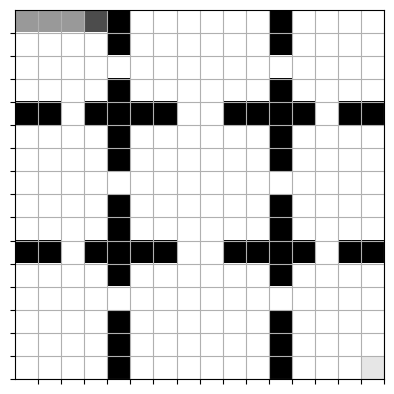

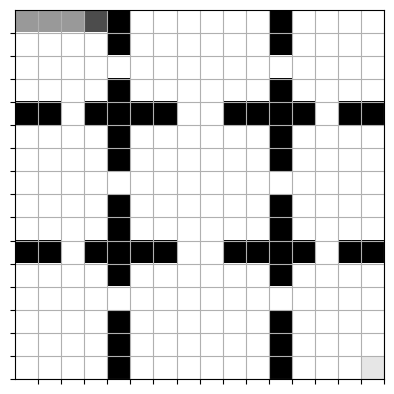

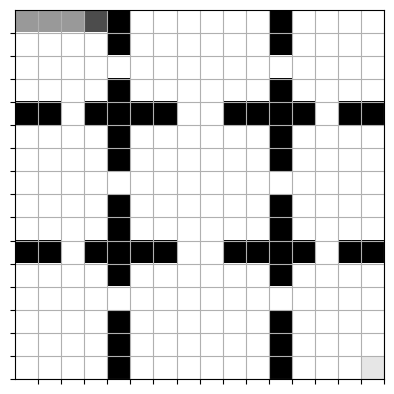

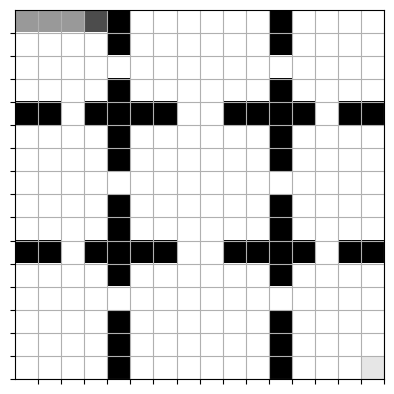

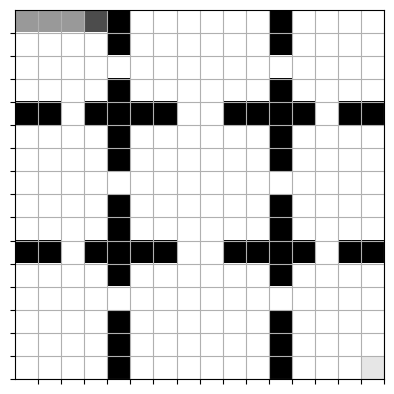

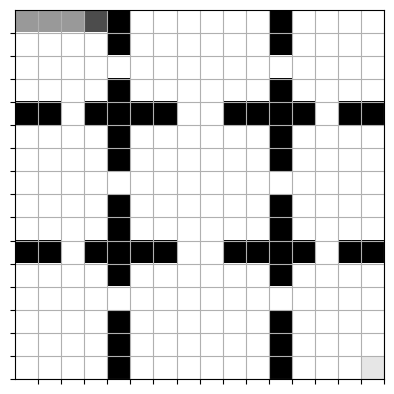

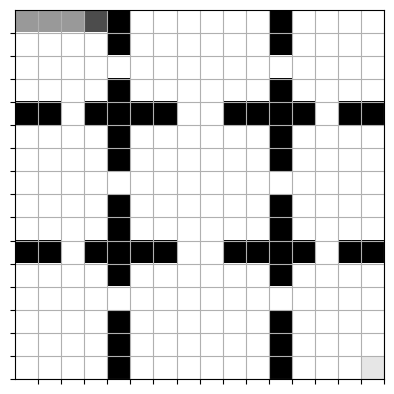

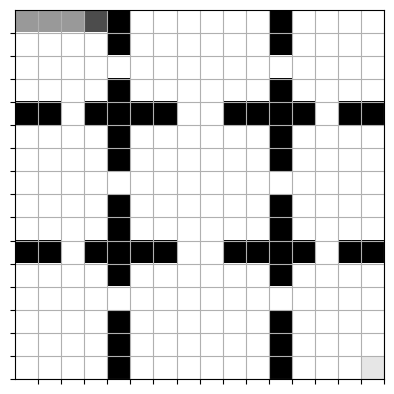

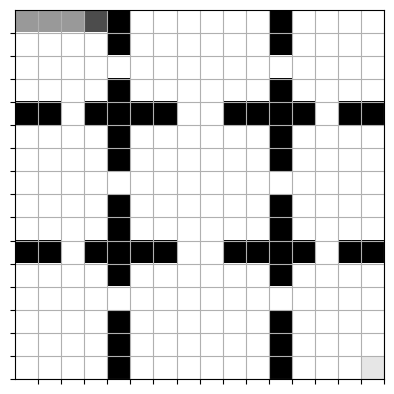

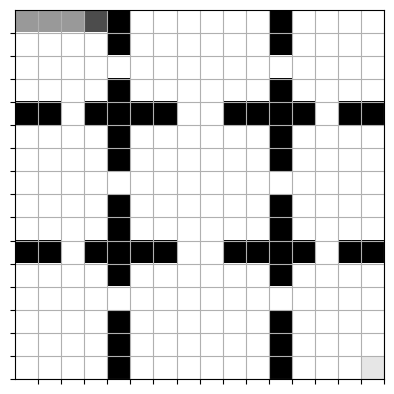

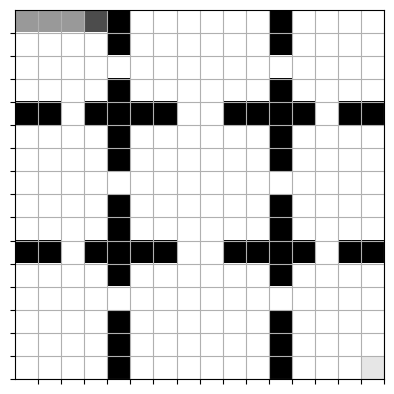

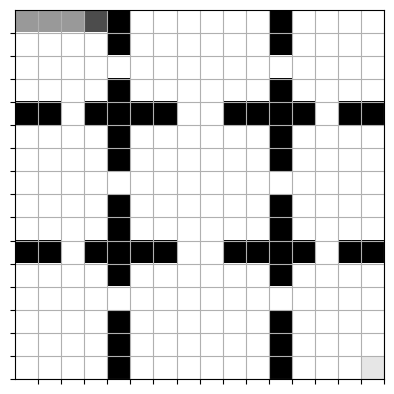

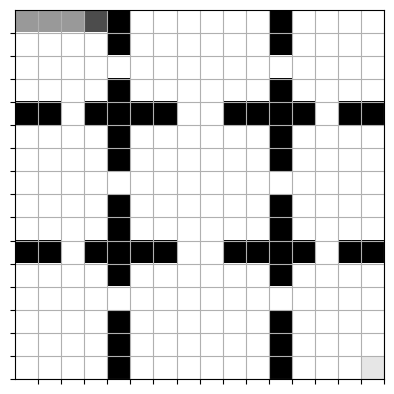

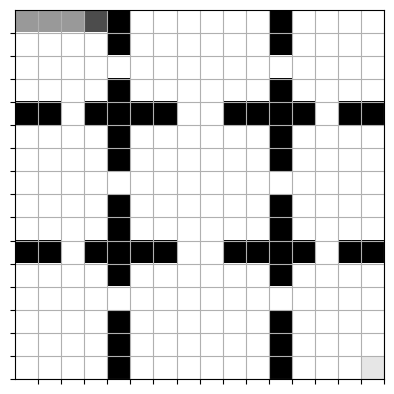

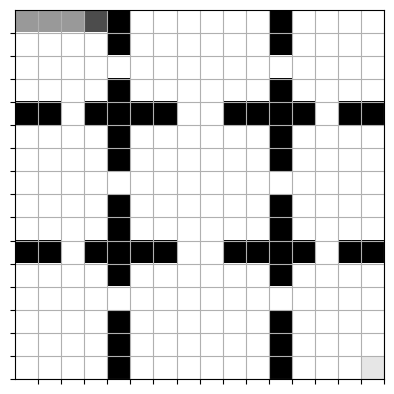

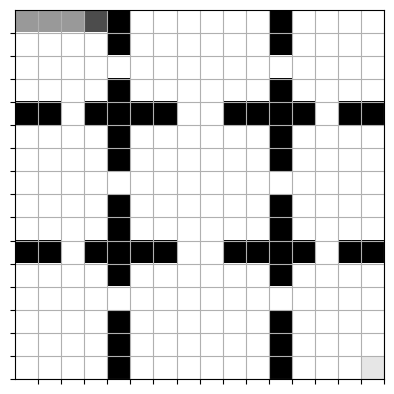

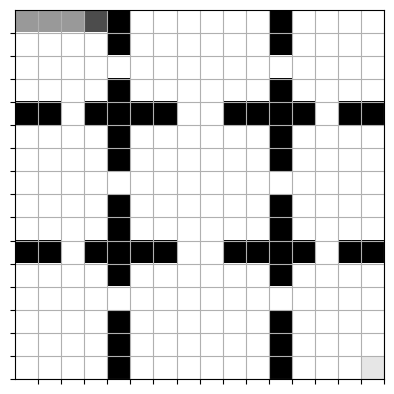

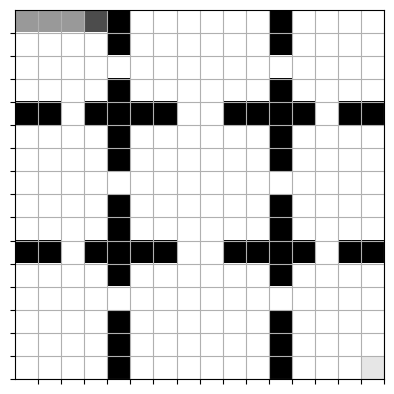

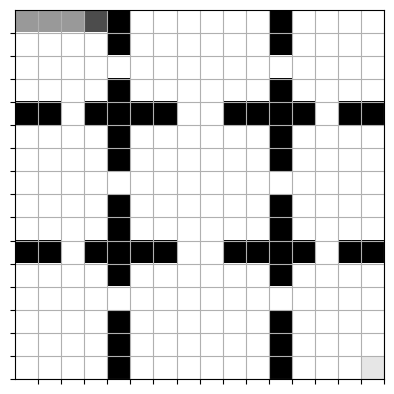

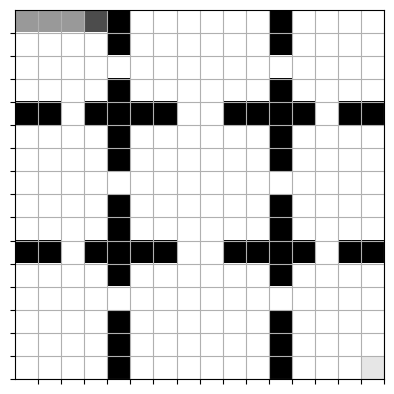

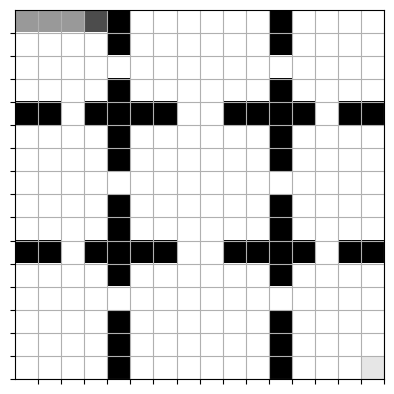

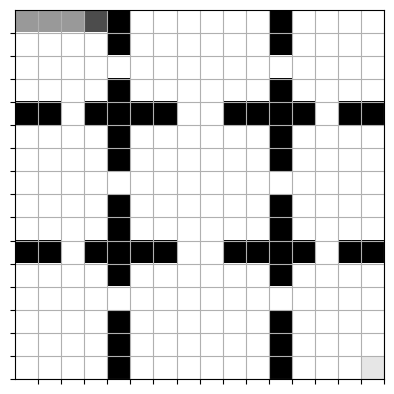

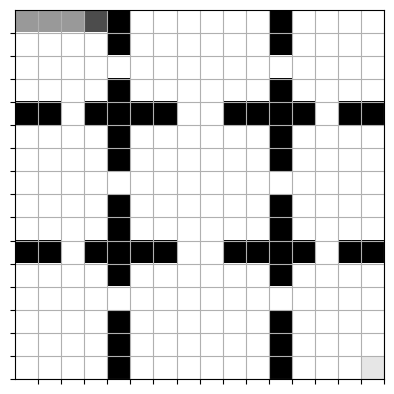

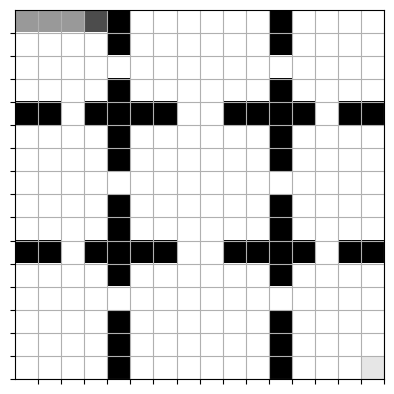

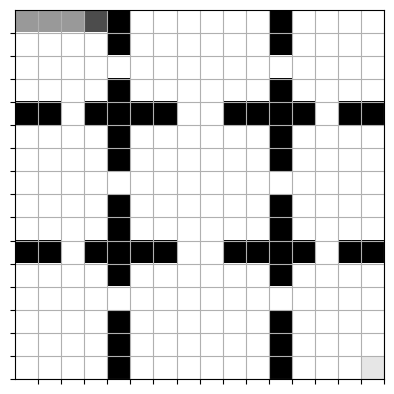

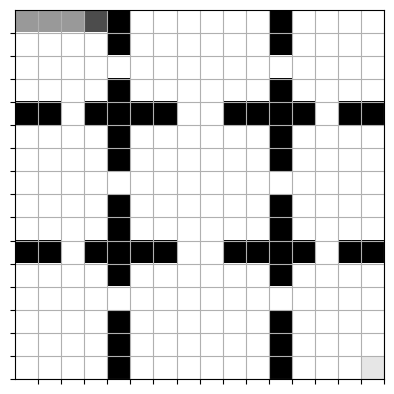

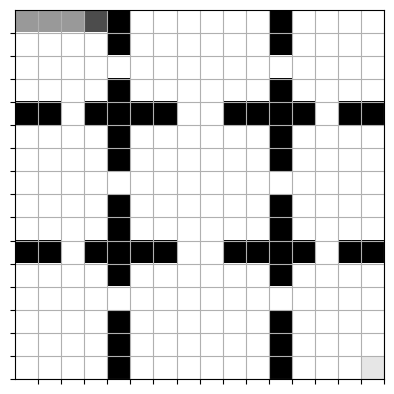

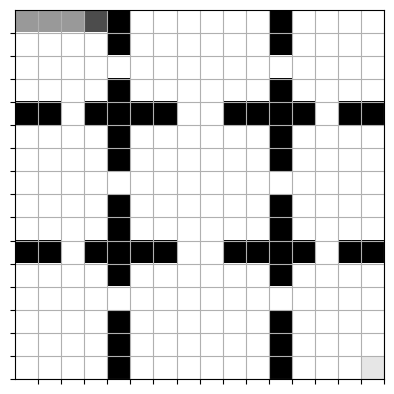

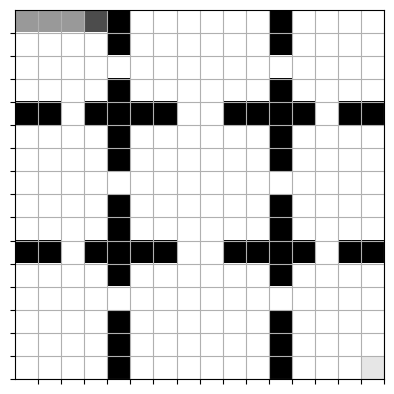

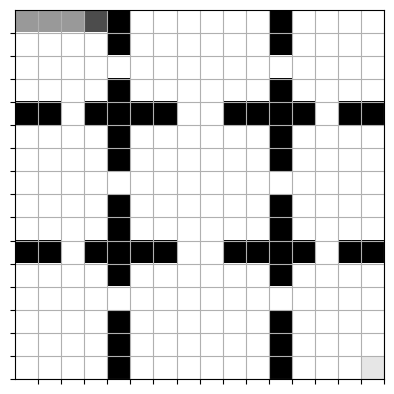

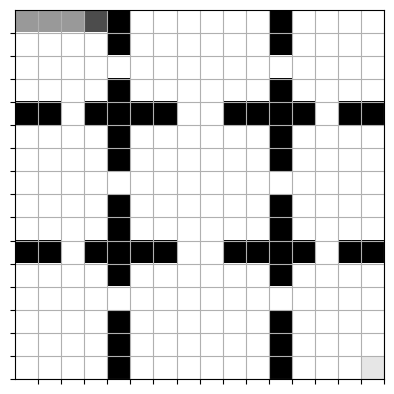

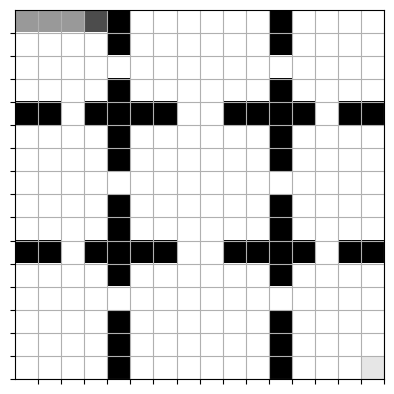

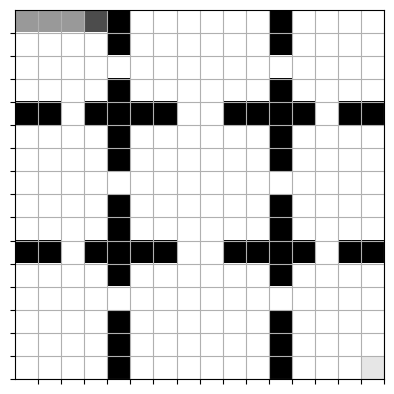

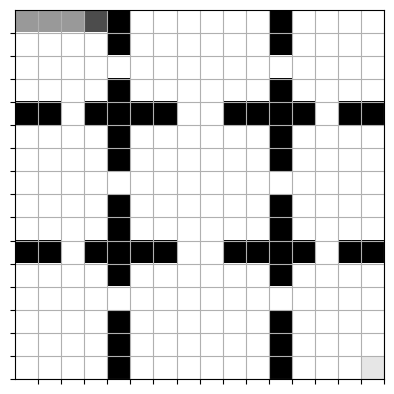

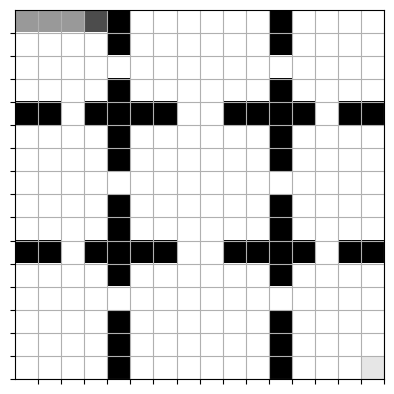

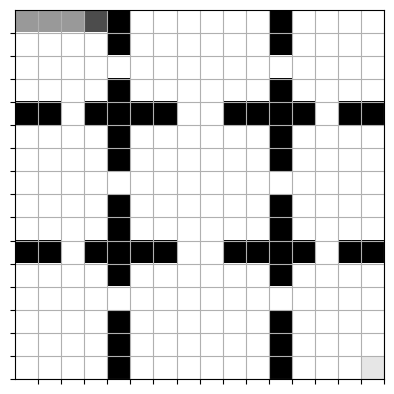

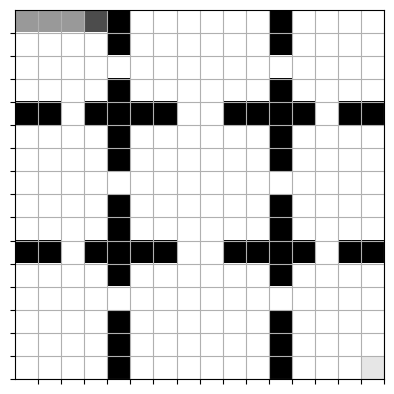

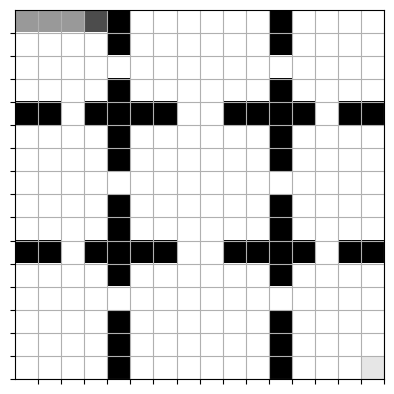

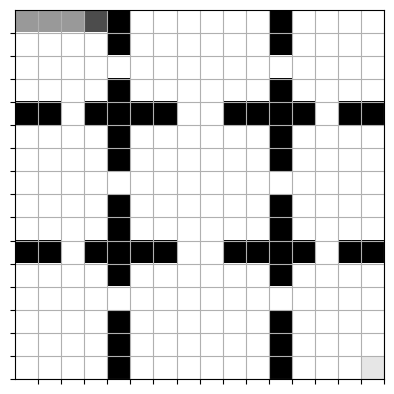

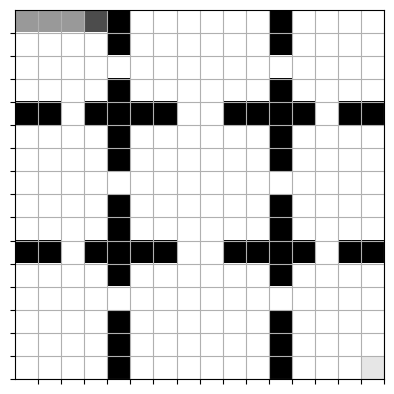

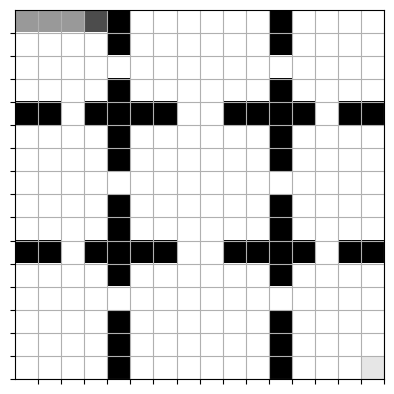

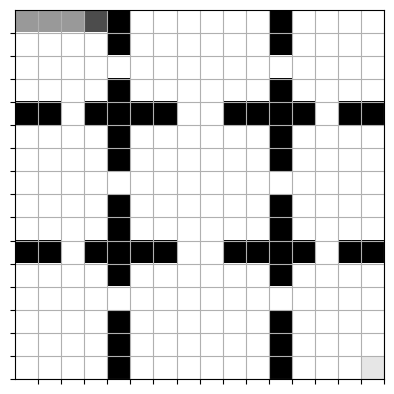

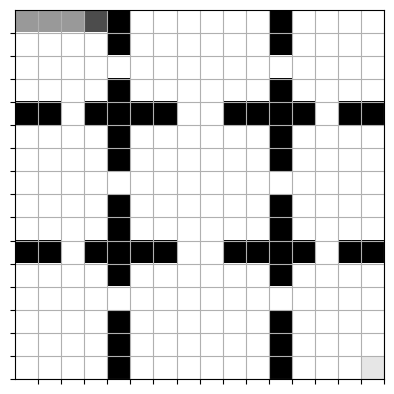

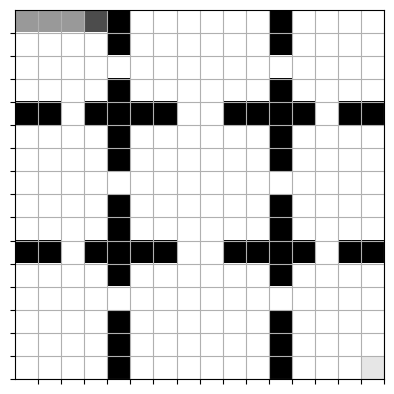

Error in callback <function flush_figures at 0x789ad08912d0> (for post_execute):


KeyboardInterrupt: ignored

In [174]:
env.reset((0, 0))
done = 'not_over'
while done == 'not_over':
    action = agent_off.choose_action(step, obs)

    new_obs, rew, done = env.act(action)

    step += 1
    obs = new_obs
    plt.figure()
    show(env)
print(step)